In [1]:
from collections import defaultdict

import farrow_and_ball as fandb
import krippendorff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, scale
from statsmodels.stats import weightstats

from utility_functions import read_survey_data

In [2]:
ranks_df_file = 'data/ranks_df_long.csv'
ratings_df_file = 'data/ratings_df_long.csv'
comb_df_file = 'data/comb_df.parquet.zstd'

orig_ranks_df, orig_rates_df = read_survey_data(ranks_df_file, ratings_df_file)
orig_comb_df = pd.read_parquet(comb_df_file).astype({'batch_order': int})
# orig_comb_df.groupby(['method', 'batch'])[['rid', 'wid']].nunique()
print(orig_comb_df.groupby('topic_class')['topic'].unique().to_latex())

\begin{tabular}{ll}
\toprule
 & topic \\
topic_class &  \\
\midrule
Analyze & ['259'] \\
Remember & ['223' '238' '283'] \\
Understand & ['213' '234' '244' '253' '261' '266' '286' '297'] \\
\bottomrule
\end{tabular}


In [3]:
q = 0.50
print(
    f"Overall {q * 100:.0f}% of participants finished within time {orig_comb_df['duration'].quantile(q=q) // 60:.0f} minutes and {orig_comb_df['duration'].quantile(q=q) % 60:.0f} seconds")
_mean = orig_comb_df["duration"].mean()
_median = orig_comb_df["duration"].median()
print(f"Mean duration: {_mean // 60:.0f} minutes and {_mean % 60:.0f} seconds")
print(f"Median duration: {_median // 60:.0f} minutes and {_median % 60:.0f} seconds")
print(
    f"with SD of {orig_comb_df['duration'].std() // 60:.0f} minutes and {orig_comb_df['duration'].std() % 60:.0f} seconds")

Overall 50% of participants finished within time 4 minutes and 21 seconds
Mean duration: 5 minutes and 17 seconds
Median duration: 4 minutes and 21 seconds
with SD of 3 minutes and 52 seconds


In [4]:
def remove_longest_sessions(_comb_df, p=0.05):
    # Dropping the longest 5% samples.
    q = 1 - p
    percentile = _comb_df['duration'].quantile(q=q)
    print(f'Dropping {(p) * 100:.1f}% of longest samples')
    print(_comb_df.loc[_comb_df["duration"] > percentile, 'method'].value_counts() / 20)
    _comb_df_ = _comb_df.loc[_comb_df["duration"] <= percentile]
    print(
        f'Total of {(len(_comb_df) - len(_comb_df_)) / 20} sessions longer than {percentile} sec (~{percentile // 60} minutes) will be dropped')

    return _comb_df_

In [5]:
def filter_unique_sessions(_comb_df):
    # Filtering sessions to remove duplicates
    ranking_duration = _comb_df.loc[_comb_df['method'] == 'Ranking'].groupby('rid')[
        ['duration', 'batch_order', 'method', 'wid', 'batch']].head(1)
    rating_duration = _comb_df.loc[_comb_df['method'] == 'Rating'].groupby('rid')[
        ['duration', 'batch_order', 'method', 'wid', 'batch']].head(1)
    comb_duration = pd.concat([ranking_duration, rating_duration])
    # Add duration in minutes and return
    return comb_duration.assign(dur_min=(comb_duration['duration'] / 60))

In [6]:
comb_duration_raw = filter_unique_sessions(orig_comb_df)

comb_df = remove_longest_sessions(orig_comb_df, 0.05)
comb_duration = filter_unique_sessions(comb_df)

Dropping 5.0% of longest samples
method
Ranking    15.0
Rating     10.0
Name: count, dtype: float64
Total of 25.0 sessions longer than 674.0 sec (~11.0 minutes) will be dropped


In [7]:
ranks_df = comb_df.loc[comb_df['method'] == 'Ranking']
rates_df = comb_df.loc[comb_df['method'] == 'Rating']

In [8]:
q = 0.50
print(
    f"Overall {q * 100:.0f}% of participants finished within time {comb_df['duration'].quantile(q=q) // 60:.0f} minutes and {comb_df['duration'].quantile(q=q) % 60:.0f} seconds")
_mean = comb_df["duration"].mean()
_median = comb_df["duration"].median()
print(f"Mean duration: {_mean // 60:.0f} minutes and {_mean % 60:.0f} seconds")
print(f"Median duration: {_median // 60:.0f} minutes and {_median % 60:.0f} seconds")
print(
    f"with SD of {comb_df['duration'].std() // 60:.0f} minutes and {comb_df['duration'].std() % 60:.0f} seconds")
np.round(comb_df['duration'].std() / 60, 2)

Overall 50% of participants finished within time 4 minutes and 9 seconds
Mean duration: 4 minutes and 40 seconds
Median duration: 4 minutes and 9 seconds
with SD of 2 minutes and 1 seconds


2.02

In [9]:
plt.rcParams.update(plt.rcParamsDefault)
paper_fmt = {
    "font.family": ["Linux Libertine O"],
    "font.serif": ["Linux Libertine O"],
    "font.sans-serif": "Linux Biolinum",
    'font.size': 12,
    'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (5, 2),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}

thesis_fmt = {
    "ps.useafm": True,
    # "ps.usedistiller": "xpdf",
    "font.family": "serif",
    "font.serif": ['garamond', 'urw-garamond', 'Garamond 3 URW'],
    # "text.latex.preamble": r"\usepackage{mathdesign}",
    "text.latex.preamble": r"\usepackage{microtype}"
                           r"\usepackage{lmodern}"
                           r"\usepackage[scaled]{beramono}"
                           r"\usepackage[urw-garamond, uppercase=upright]{mathdesign}"
                           r"\usepackage{garamondx}"
                           r"\renewcommand{\ttdefault}{lmtt}"
                           r"\usepackage{pifont}"
                           r"\usepackage{setspace}"
                           r"\linespread{1.05}"
                           r"\DeclareMathAlphabet{\xcal}{OMS}{cmsy}{m}{n}",
    # "mathtext.default": 'it',
    # "mathtext.fontset": 'custom',
    # "mathtext.rm": 'Garamond 3 URW Italic',
    # "mathtext.it": 'Garamond 3 URW Italic',
    'text.usetex': True,
    # "font.sans-serif": "Linux Biolinum",
    'font.size': 12,
    # 'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (10, 5),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}

plt.rcParams.update(thesis_fmt)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  #
plt.close()

In [10]:
comb_duration.groupby('method').describe()

duration                                                             \
           count        mean         std    min    25%    50%    75%    max   
method                                                                        
Ranking    258.0  285.147287  120.179703  102.0  191.5  262.5  350.0  654.0   
Rating     235.0  273.672340  121.918878   91.0  187.5  238.0  337.5  674.0   

        batch_order            ...           dur_min                      \
              count      mean  ...  75%  max   count      mean       std   
method                         ...                                         
Ranking       258.0  1.779070  ...  2.0  3.0   258.0  4.752455  2.002995   
Rating        235.0  1.629787  ...  2.0  3.0   235.0  4.561206  2.031981   

                                                            
              min       25%       50%       75%        max  
method                                                      
Ranking  1.700000  3.191667  4.375000  5.833333  10.900000  
Rating   1.516667  3.125000  3.966667  5.625000  11.233333  

[2 rows x 24 columns]

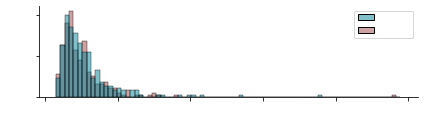

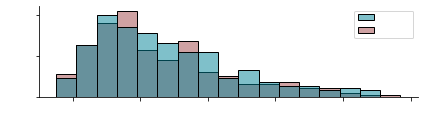

In [11]:
def plot_dur_hist(comb_duration):
    max = comb_duration['dur_min'].max()
    fig, ax = plt.subplots(figsize=(6, 2))
    ax = sns.histplot(data=comb_duration, x='dur_min', hue='method', multiple='layer', kde=False,
                      kde_kws=dict(clip=(0, max + 1)), common_norm=False, stat='count',
                      bins=np.arange(1.5, max + 1, 0.6), ax=ax,
                      palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=True)
    # ax = sns.boxplot(data=comb_duration, y='dur_min', x='method', palette={'Ranking': '#008297', 'Rating': '#A14648'})
    # lss = ['--', '-.']
    # handles = ax.legend_.legendHandles[::-1]
    #
    # for line, ls, handle in zip(ax.collections, lss, handles):
    #     line.set_linestyle(ls)
    #     handle.set_ls(ls)

    sns.despine()
    ax.set_ylabel('Count')
    ax.set_xlabel('Duration in Min.')
    ax.legend_.set_title(None)
    ax.set_title(None)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

    plt.tight_layout(h_pad=1.5)
    return plt
    # plt.show()


x = plot_dur_hist(comb_duration_raw)
x.savefig('plots/duration_hist_1.pdf', dpi=300)
x.show()
y = plot_dur_hist(comb_duration)
y.savefig('plots/duration_hist_2.pdf', dpi=300)
y.show()

In [12]:
print(comb_duration.groupby('method').median(numeric_only=True).to_markdown(floatfmt='.2f'))

| method   |   duration |   batch_order |   dur_min |
|:---------|-----------:|--------------:|----------:|
| Ranking  |     262.50 |          2.00 |      4.38 |
| Rating   |     238.00 |          1.00 |      3.97 |


In [13]:
comb_df.groupby(['batch'])['duration'].median(numeric_only=True) / 60

batch
blue     4.025
green    4.475
red      3.700
Name: duration, dtype: float64

In [14]:
comb_df.groupby(['method', 'batch'])['duration'].median(numeric_only=True) / 60

method   batch
Ranking  blue     4.016667
         green    4.658333
         red      4.383333
Rating   blue     4.033333
         green    4.316667
         red      3.383333
Name: duration, dtype: float64

In [15]:
grpbywid = comb_duration.groupby('wid')['batch_order'].count()
wids_did_all = grpbywid.loc[(grpbywid == 3)].index
print(f"{len(wids_did_all)} out of {comb_duration['wid'].nunique()} did all 3 HITs after filtering")
print(f"{len(comb_duration.loc[comb_duration['wid'].isin(wids_did_all)])}")

97 out of 255 did all 3 HITs after filtering
291


In [16]:
plt.rcParams.update(plt.rcParamsDefault)
paper_fmt = {
    "font.family": ["Linux Libertine O"],
    "font.serif": ["Linux Libertine O"],
    "font.sans-serif": "Linux Biolinum",
    'font.size': 12,
    'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (6, 3),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    #     'axes.titlesize':'medium',
    #     'axes.labelsize':'medium'
}
plt.rcParams.update(thesis_fmt)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  #
plt.close()

In [17]:
comb_duration.loc[comb_duration['wid'].isin(wids_did_all)].astype({'batch_order': int})

duration  batch_order   method             wid batch   dur_min
0          204            2  Ranking  A39MKVROUZ1UWR   red  3.400000
10         197            3  Ranking  A23BWWRR7J5XLS   red  3.283333
15         211            1  Ranking  A1CB72B51L7TKE   red  3.516667
20         299            3  Ranking  A12R2U6TBB3OOG   red  4.983333
25         454            2  Ranking   APRHR60T52KR9   red  7.566667
...        ...          ...      ...             ...   ...       ...
7000       238            2   Rating  A28AXX4NCWPH1F  blue  3.966667
7005       194            2   Rating  A2VUF0V7HT51Q3  blue  3.233333
7010        91            3   Rating  A110KENBXU7SUJ  blue  1.516667
7015       356            3   Rating  A3HQXCWOIQKT4F  blue  5.933333
7045       328            3   Rating  A1YH2I4Y2SYAXJ  blue  5.466667

[291 rows x 6 columns]

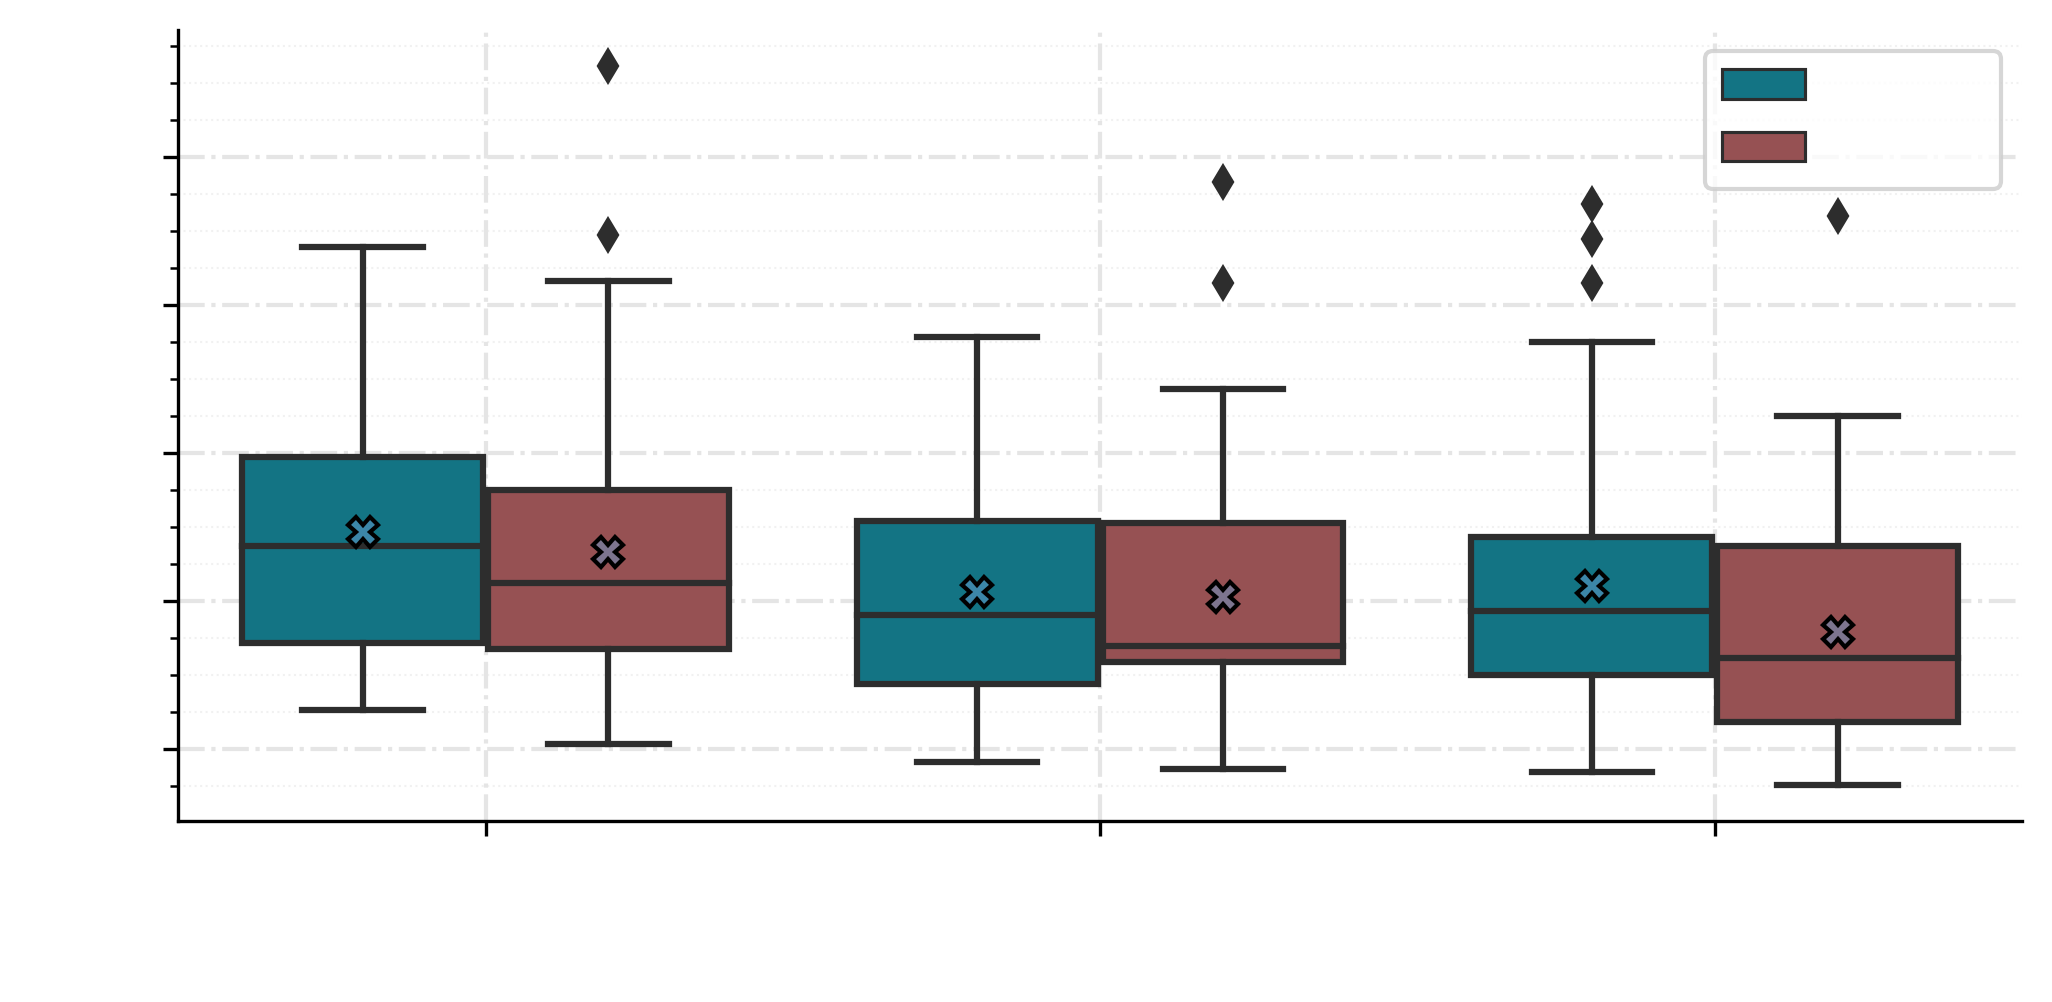

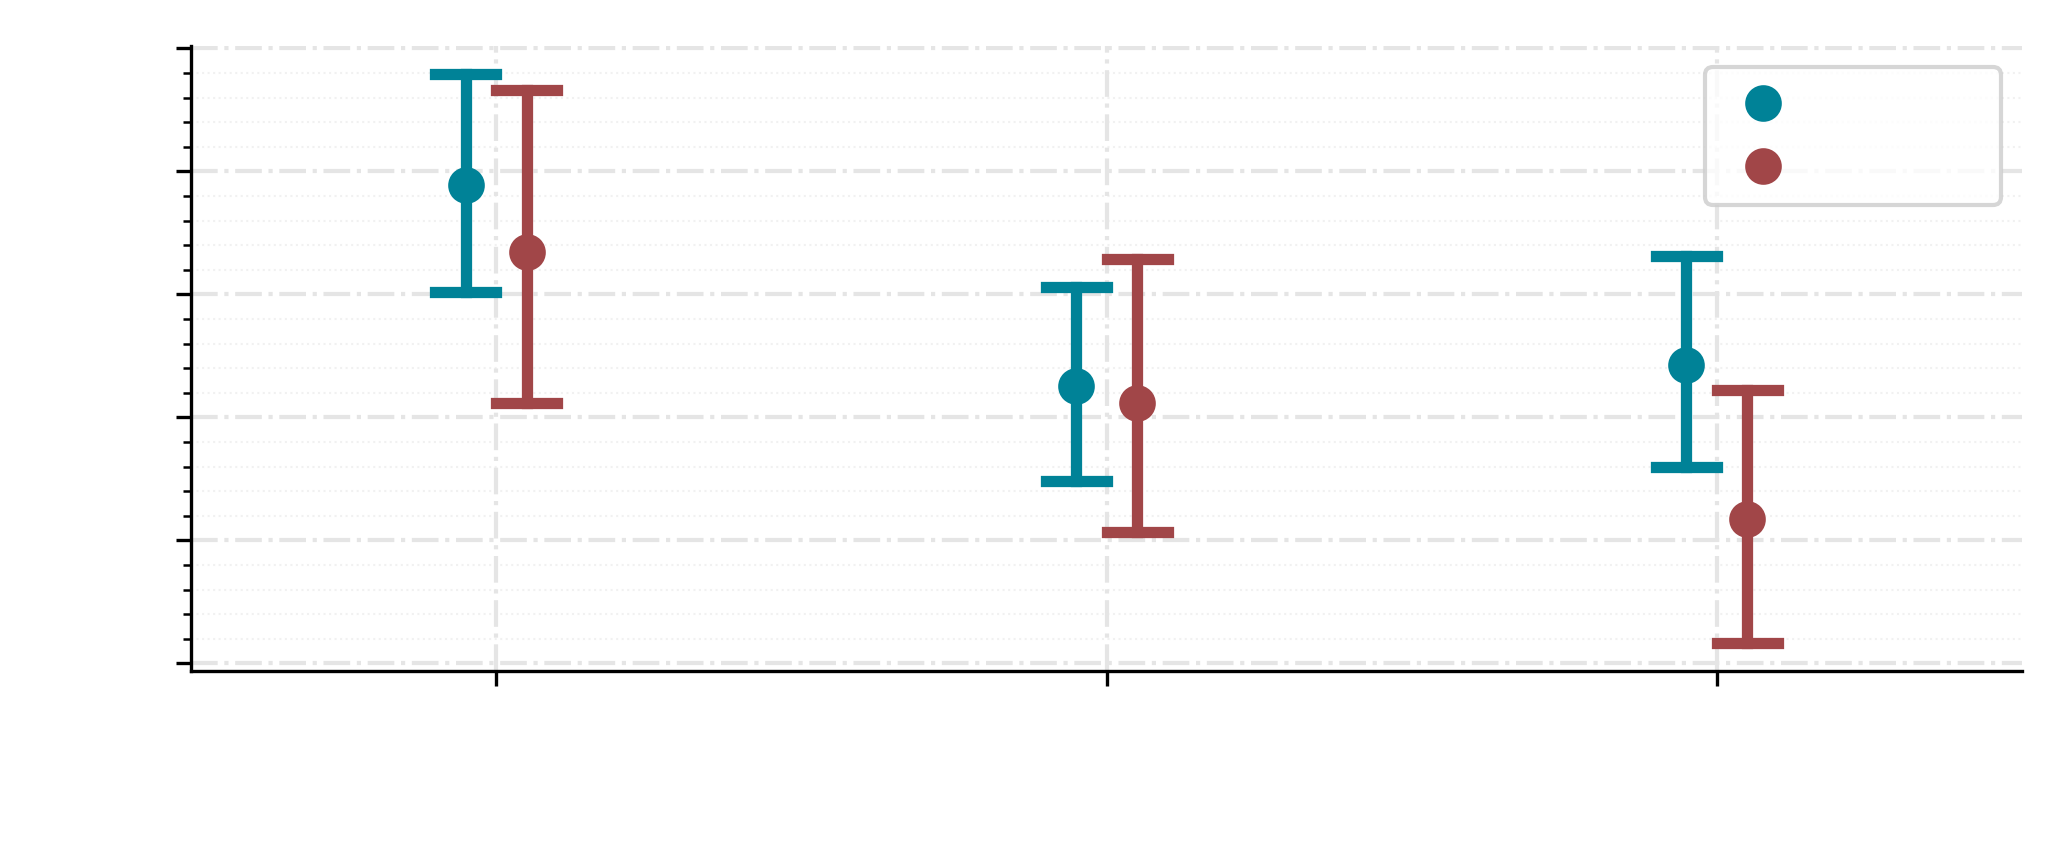

In [18]:
plt.figure(figsize=(7, 3.5))
ax1 = sns.boxplot(data=comb_duration.loc[comb_duration['wid'].isin(wids_did_all)].astype({'batch_order': int}),
                  x='batch_order', y='dur_min', hue='method', showmeans=True, zorder=30, boxprops=dict(zorder=10),
                  palette={'Ranking': '#008297', 'Rating': '#A14648'},
                  meanprops={"marker": "X", "markersize": 7, "markerfacecolor": (.4, .6, .8, .5),
                             "markeredgecolor": "black", "color": (.9, .9, .9, .9), "linewidth": 2})

ax1.grid(visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
ax1.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5,
         ms=0)

ax1.minorticks_on()
ax1.tick_params(axis='x', which='minor', bottom=False)

# for l in ax1.lines + ax1.collections:
#     l.set_zorder(20)

sns.despine()
ax1.set_xlabel('HIT Order')
ax1.set_ylabel('Duration in Min.')
ax1.legend_.set_title(None)
ax1.set_title(None)
# plt.title('Boxplots of time estimates (min.)')
plt.tight_layout()
plt.savefig('plots/order_duration_box.pdf', dpi=300, bbox_inches='tight')
plt.show()
# 
# # Nonparallel lines indicate interaction
# # plt.figure(figsize=(10, 4))
# # ax2 = sns.pointplot(data=comb_duration.loc[comb_duration['wid'].isin(wids_did_all)], x='batch_order', y='dur_min',
# #                     capsize=0.1, palette={'Ranking': '#008297', 'Rating': '#A14648'}, join=False,
# #                     hue='method', estimator='mean', errorbar=('ci', 95), n_boot=5000)
# 
# ax2 = sns.barplot(data=comb_duration.loc[comb_duration['wid'].isin(wids_did_all)].astype({'batch_order': int}),
#                   x='batch_order', y='dur_min',
#                   capsize=0.1, palette={'Ranking': '#008297', 'Rating': '#A14648'},
#                   hue='method', estimator='mean', errorbar=('ci', 95), n_boot=5000)
# sns.despine()
# ax2.set_xlabel('HIT Order', fontsize=16)
# ax2.set_ylabel('Duration in Min.', fontsize=16)
# ax2.legend_.set_title(None)
# ax2.set_title(None)
# # plt.title('Mean time estimates (min.) with 95% CI bars')
# plt.tight_layout()
# # plt.savefig('plots/oreder_duration_points.pdf', dpi=300)
# plt.savefig('plots/order_duration_bars.pdf', dpi=300)
# plt.show()

plt.figure(figsize=(7, 3))
ax3 = sns.pointplot(data=comb_duration.loc[comb_duration['wid'].isin(wids_did_all)].astype({'batch_order': int}),
                    x='batch_order', y='dur_min', capsize=0.1, palette={'Ranking': '#008297', 'Rating': '#A14648'},
                    hue='method', join=False, estimator='mean', errorbar=('ci', 95), dodge=0.1, n_boot=5000)

ax3.grid(visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=1, ms=0)
ax3.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5,
         ms=0)

ax3.minorticks_on()
ax3.tick_params(axis='x', which='minor', bottom=False)

for l in ax3.lines + ax3.collections:
    l.set_zorder(10)

sns.despine()
ax3.set_xlabel('HIT Order')
ax3.set_ylabel('Duration in Min.')
ax3.legend_.set_title(None)
ax3.set_title(None)
plt.tight_layout()
plt.savefig('plots/order_duration_points.pdf', dpi=300, bbox_inches='tight')
plt.show()

# plt.figure(figsize=(10, 4))
# g = sns.catplot(data=comb_duration.loc[comb_duration['wid'].isin(wids_did_all)], kind='point', x='batch_order',
#                 y='dur_min',
#                 col='batch', capsize=0.1, palette={'Ranking': '#008297', 'Rating': '#A14648'}, hue='method', join=False,
#                 estimator='mean', errorbar=('ci', 95), dodge=0.1)
# # plt.title('Median time estimates (min.) with SE bars')
# plt.show()

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


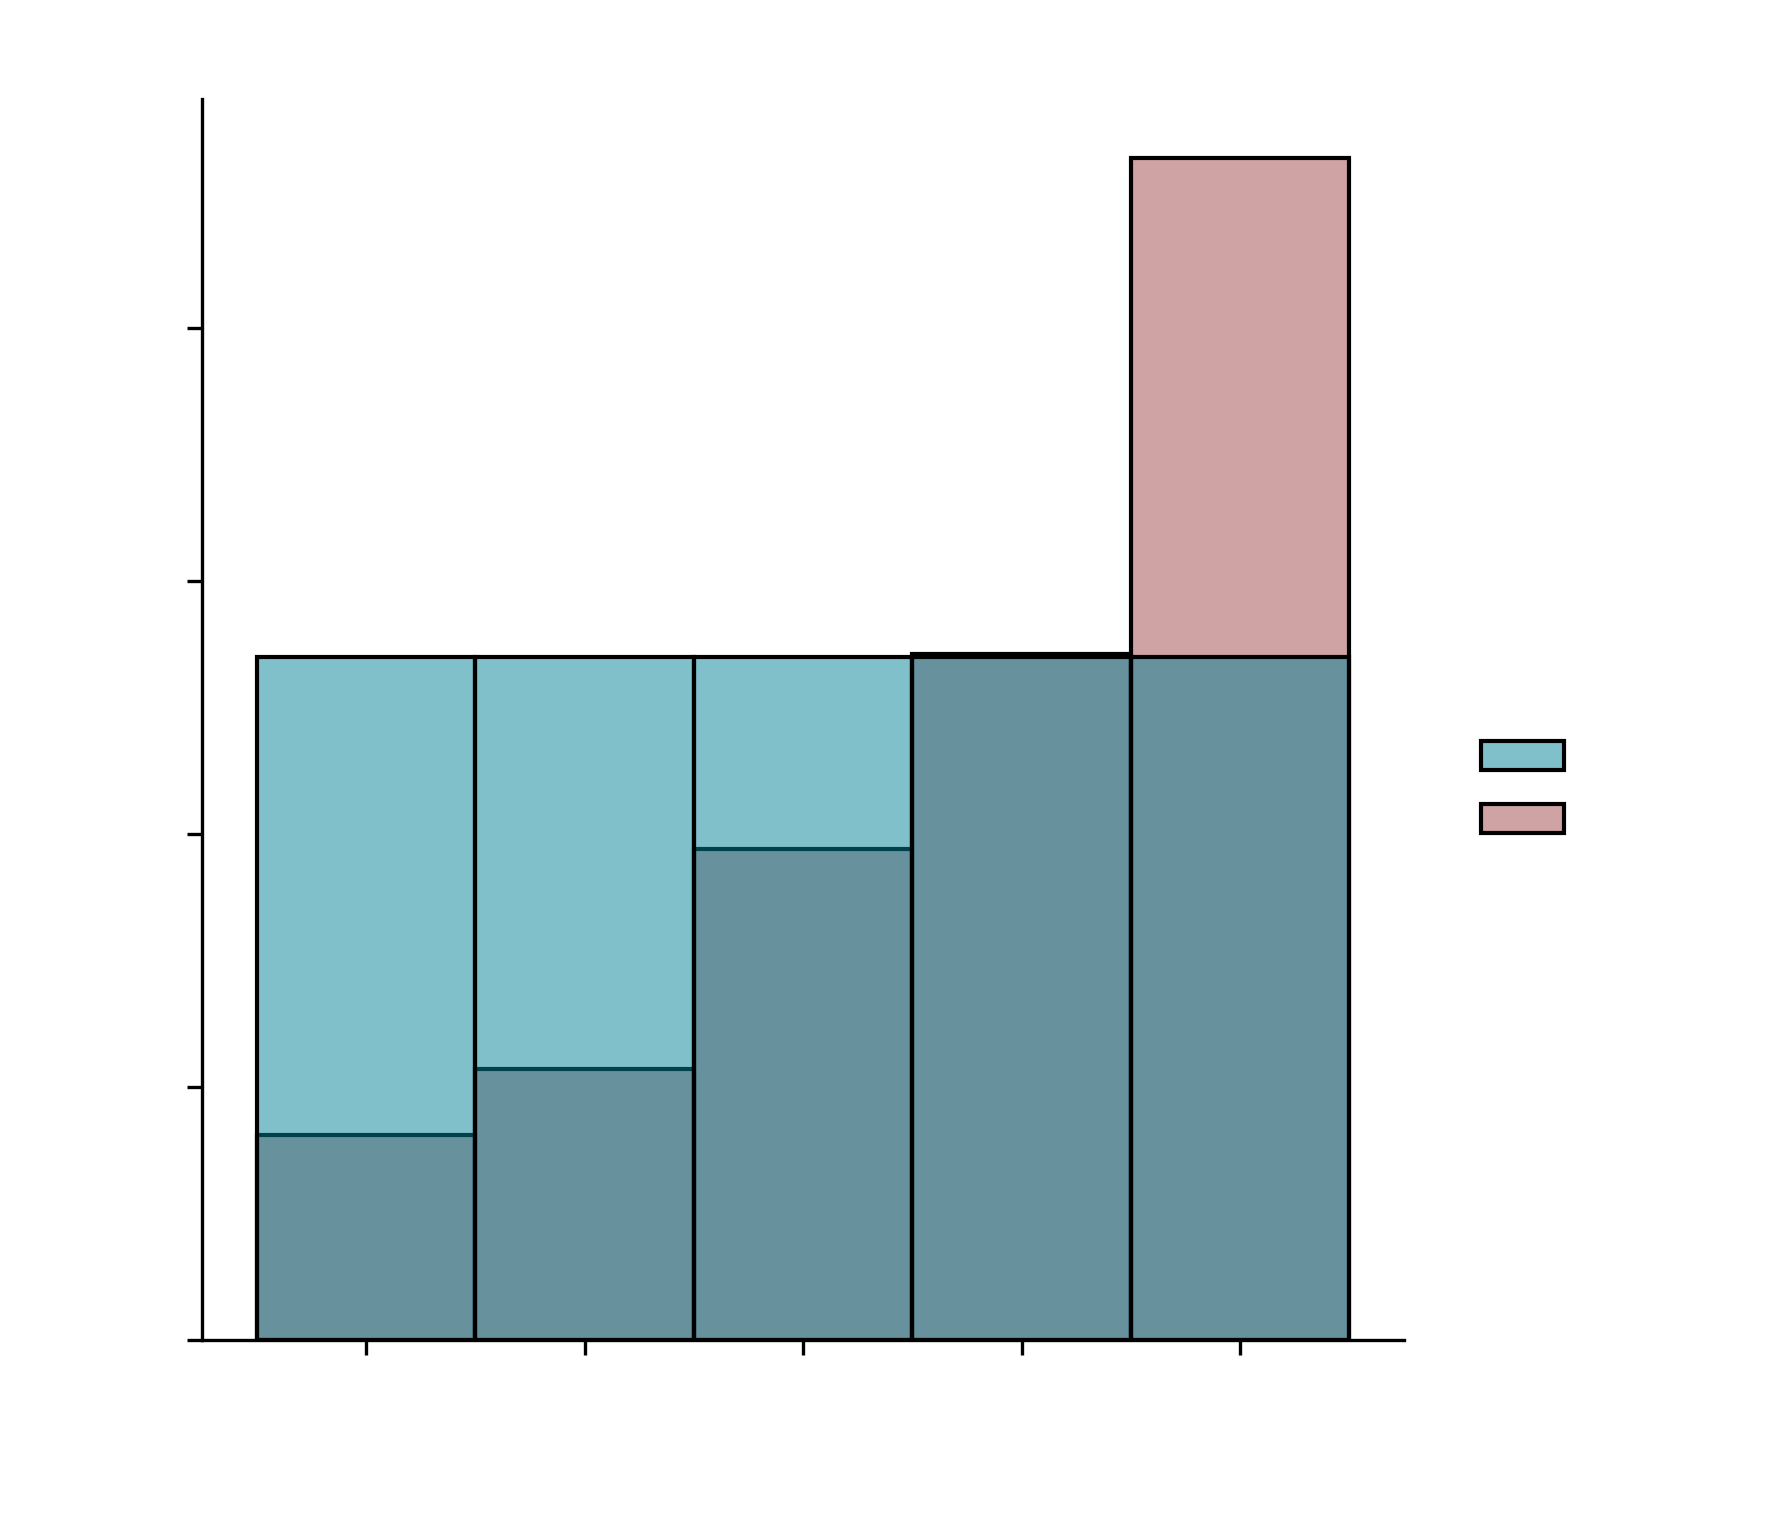

In [19]:
sns.displot(data=comb_df.set_index('query', append=True), x='value', hue='method', stat='frequency', multiple='layer',
            discrete=True, palette={'Ranking': '#008297', 'Rating': '#A14648'})
plt.title('Histogram of query scores over all workers')
plt.show()
# The histogram shows that the scores for rating are left skewed, workers tend to give higher scores to queries

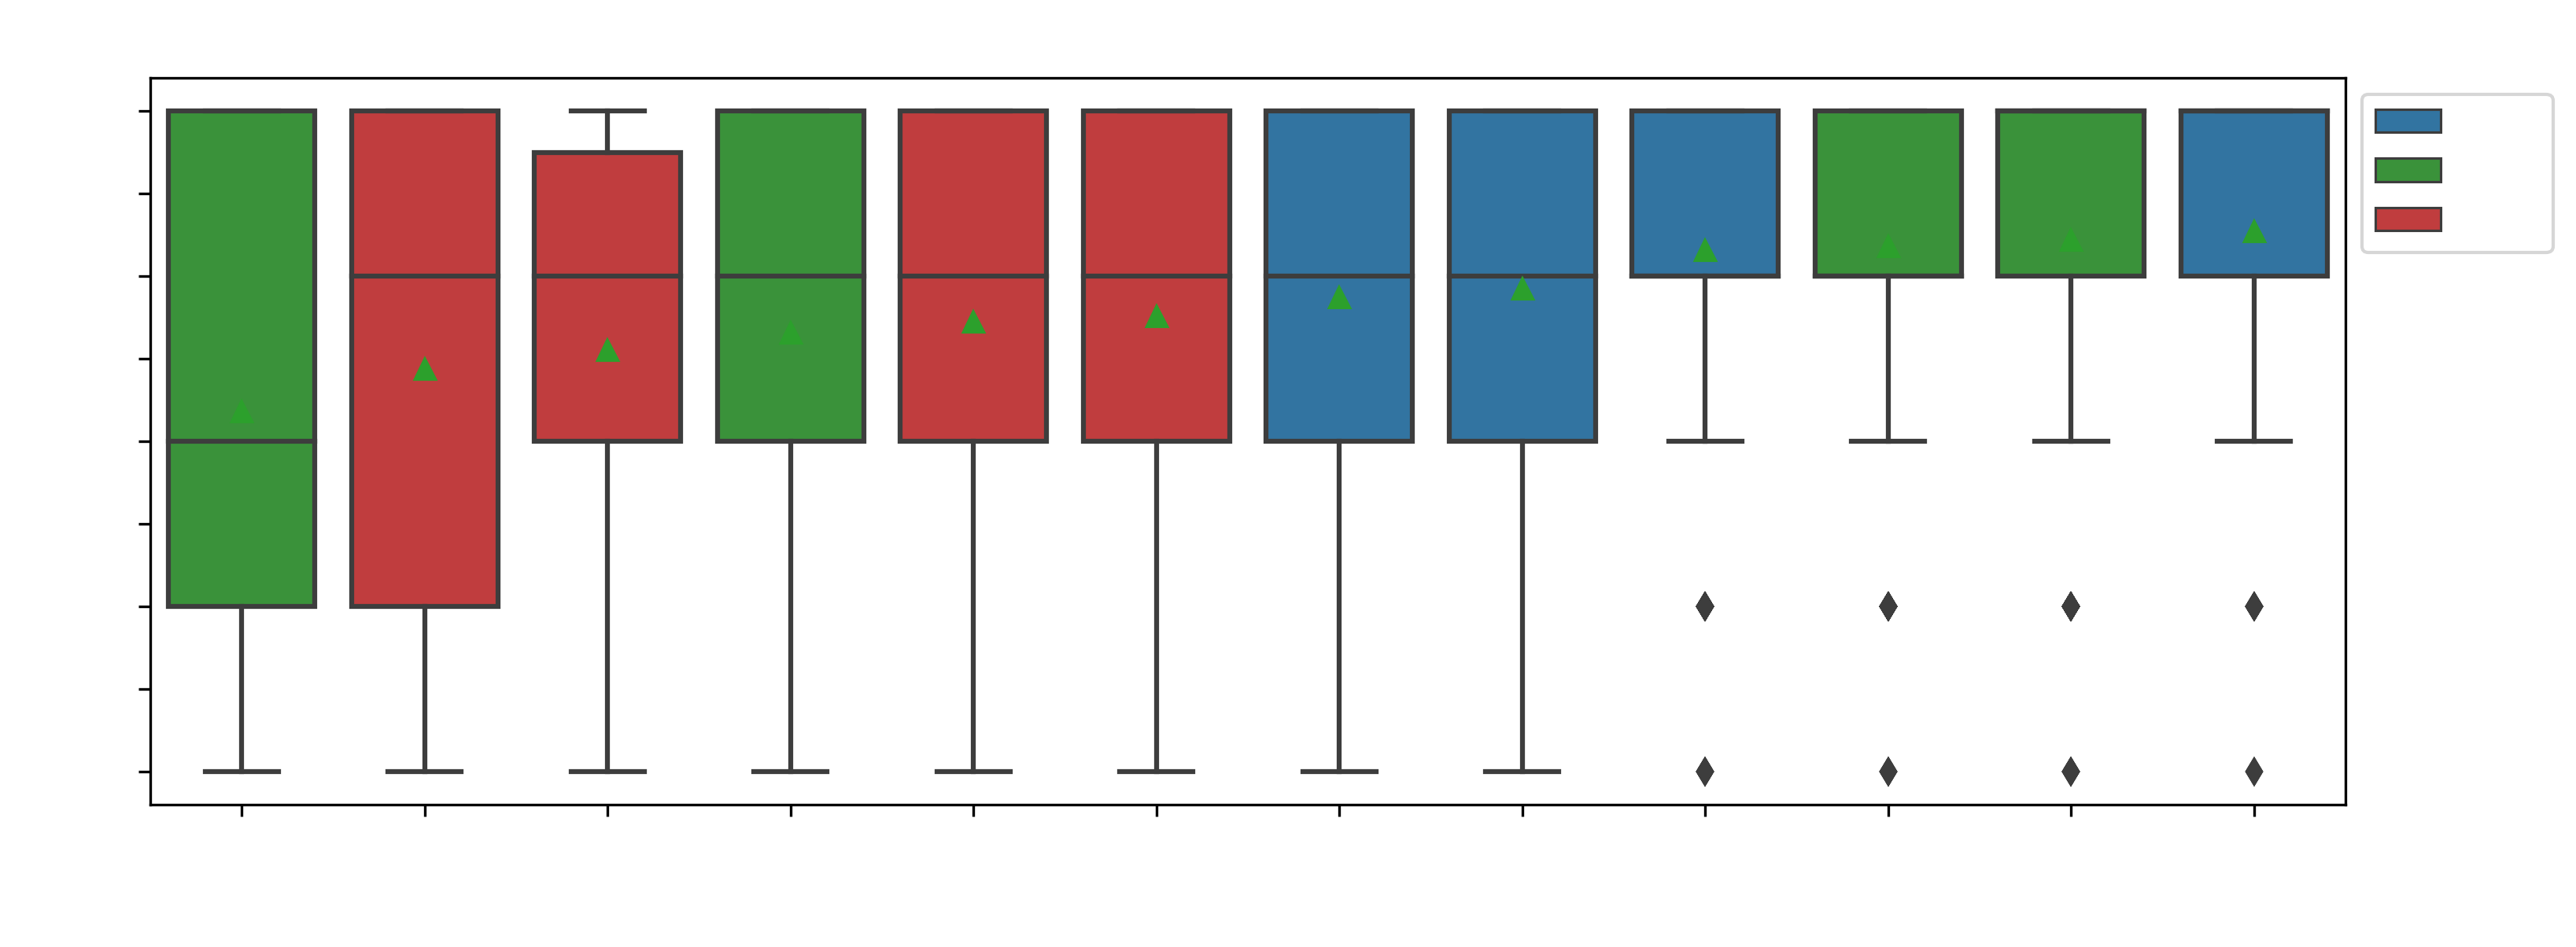

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


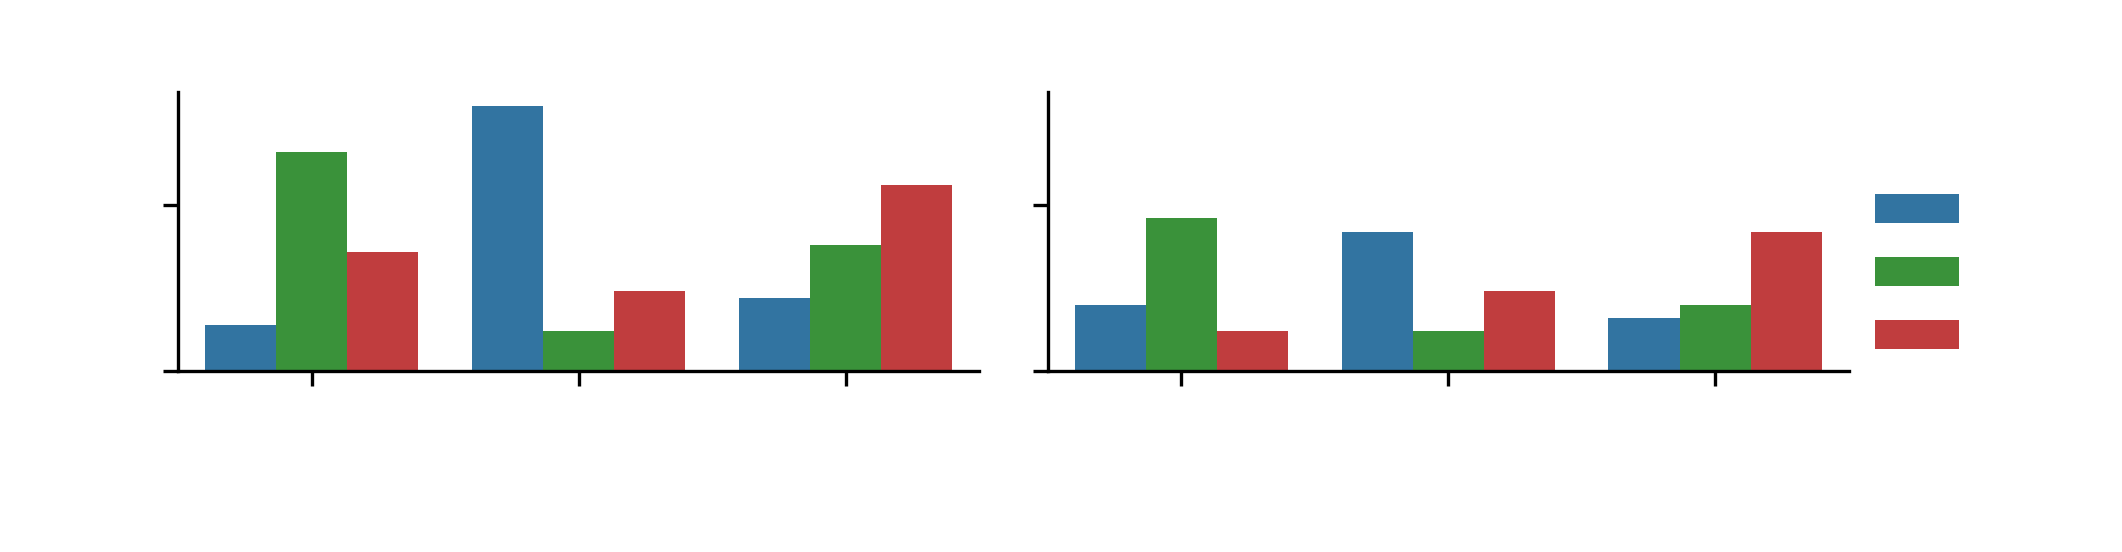

In [20]:
topics_order = comb_df.loc[comb_df['method'] == 'Rating'].groupby('topic')['value'].mean().sort_values().index
plt.figure(figsize=(12, 4))
sns.boxplot(data=comb_df.loc[comb_df['method'] == 'Rating'].set_index('query', append=True), x='topic', y='value',
            dodge=False, hue='batch', showmeans=True, palette={'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4'},
            order=topics_order, hue_order=['blue', 'green', 'red'])
plt.title('Box plots of all the ratings given to queries by all workers per topic')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

plt.rcParams.update(thesis_fmt)

g = sns.catplot(
    data=(comb_df.loc[comb_df['wid'].isin(wids_did_all)].value_counts(['batch', 'batch_order', 'method'],
                                                                      normalize=False).sort_index() / 20).rename(
        'Count').reset_index().astype({'batch_order': int}), height=2, aspect=1.6, alpha=1,
    x='batch_order', y='Count', col='method', hue='batch', kind='bar', hue_order=['blue', 'green', 'red'],
    palette={'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4'})

# Define some hatches
# hatches = ['xx', '..', '++']
# hatches = ['++'] * 3 + ['..'] * 3 + ['xx'] * 3
# # Loop over the bars
# for _ax in g.axes.flat:
#     for i, _patch in enumerate(_ax.patches):
#         _patch.set_hatch(hatches[i])
# 
# for lp, hatch in zip(g.legend.get_patches(), hatches[::3]):
#     lp.set_hatch(hatch)
#     # fc = lp.get_facecolor()
#     # lp.set_edgecolor(fc)
#     # lp.set_facecolor('none')

g.set_titles('{col_name}')
g.set_xlabels('HIT Order')
g.legend.set_title(None)
plt.savefig('plots/batch_hit_order.pdf')
plt.show()

In [21]:
(comb_df.value_counts(['batch', 'batch_order', 'method']).sort_index() / 20).rename('Count').reset_index().astype(
    {'batch_order': int})

batch  batch_order   method  Count
0    blue            1  Ranking   24.0
1    blue            1   Rating   41.0
2    blue            2  Ranking   47.0
3    blue            2   Rating   30.0
4    blue            3  Ranking   12.0
5    blue            3   Rating    8.0
6   green            1  Ranking   58.0
7   green            1   Rating   62.0
8   green            2  Ranking   10.0
9   green            2   Rating   13.0
10  green            3  Ranking   20.0
11  green            3   Rating   11.0
12    red            1  Ranking   37.0
13    red            1   Rating   25.0
14    red            2  Ranking   20.0
15    red            2   Rating   23.0
16    red            3  Ranking   30.0
17    red            3   Rating   22.0

In [22]:
# data = pg.read_dataset('icc')
# icc = pg.intraclass_corr(data=data, targets='Wine', raters='Judge',
#                          ratings='Scores').round(3)
# icc.set_index("Type")
# data
# topic, query, wid, value

_reliability_df = comb_df.groupby(['method', 'topic']).apply(
    lambda _df: _df.pivot(columns='query', index='wid', values='value').stack()).reset_index()
reliability_df = _reliability_df.groupby(['method', 'topic']).apply(
    lambda _df: pg.intraclass_corr(data=_df.dropna(axis=1), targets='query', raters='wid', ratings=0).round(3))
# topics_order = reliability_df.loc['Ranking'].sub(reliability_df.loc['Rating']).sort_values(ascending=False).index
# print(reliability_df.reset_index().pivot(index='topic', columns='method').droplevel(0, axis=1).loc[
#           topics_order].to_markdown(floatfmt='.3f'))
reliability_df

Type              Description    ICC        F  df1  df2  \
method  topic                                                               
Ranking 213   0   ICC1   Single raters absolute  0.596  129.307    4  430   
              1   ICC2     Single random raters  0.595  103.445    4  344   
              2   ICC3      Single fixed raters  0.541  103.445    4  344   
              3  ICC1k  Average raters absolute  0.992  129.307    4  430   
              4  ICC2k    Average random raters  0.992  103.445    4  344   
...                ...                      ...    ...      ...  ...  ...   
Rating  297   1   ICC2     Single random raters  0.328   44.084    4  312   
              2   ICC3      Single fixed raters  0.353   44.084    4  312   
              3  ICC1k  Average raters absolute  0.975   39.515    4  390   
              4  ICC2k    Average random raters  0.975   44.084    4  312   
              5  ICC3k     Average fixed raters  0.977   44.084    4  312   

                 pval         CI95%  
method  topic                        
Ranking 213   0   0.0  [0.34, 0.92]  
              1   0.0  [0.34, 0.92]  
              2   0.0  [0.29, 0.91]  
              3   0.0   [0.98, 1.0]  
              4   0.0   [0.98, 1.0]  
...               ...           ...  
Rating  297   1   0.0   [0.14, 0.8]  
              2   0.0  [0.16, 0.82]  
              3   0.0   [0.93, 1.0]  
              4   0.0   [0.93, 1.0]  
              5   0.0   [0.94, 1.0]  

[144 rows x 8 columns]

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


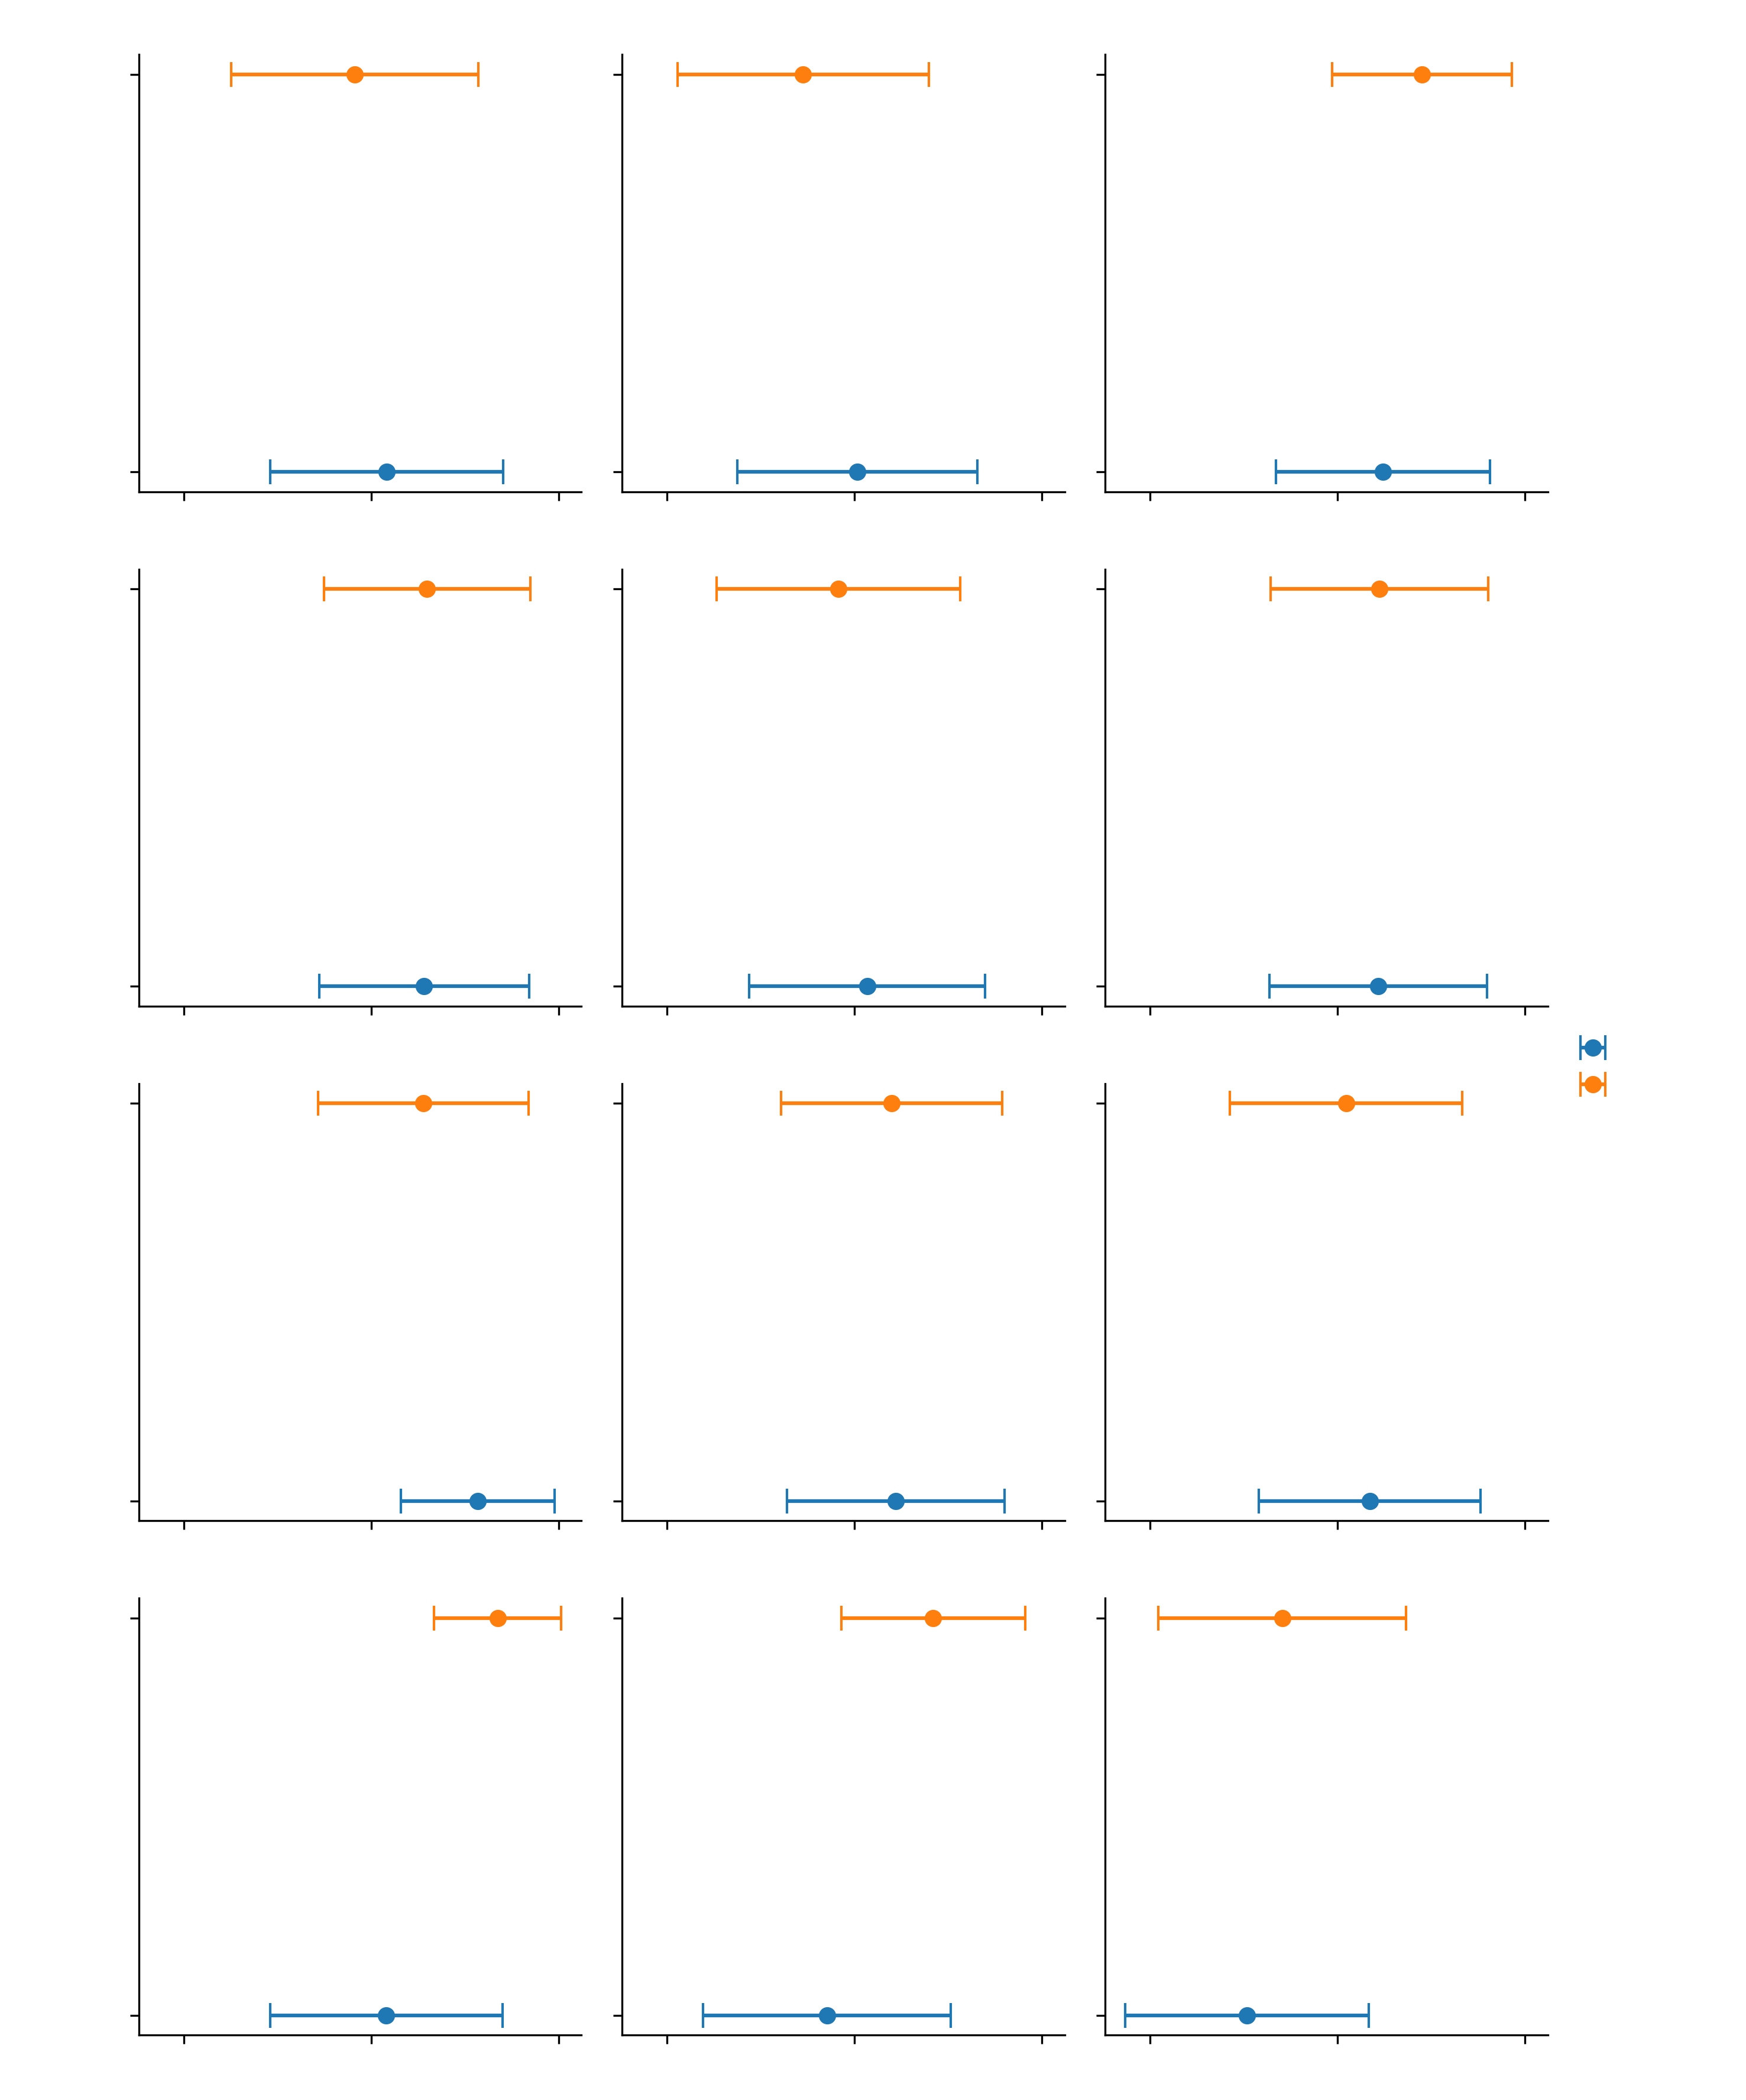

In [23]:
def plot_confidence_intervals(**kwargs):
    confidence_intervals = kwargs.get('data')
    color = kwargs.get('color')
    label = kwargs.get('label')
    # x = confidence_intervals['Type']
    y = confidence_intervals['ICC'].iloc[0]
    yerr = np.array([v[1] - v[0] for v in confidence_intervals['CI95%'].to_numpy()]) / 2
    return plt.errorbar(y=[label], x=y, xerr=yerr, fmt='o', capsize=5, color=color, label=label)


_df = reliability_df.reset_index(2, drop=True).reset_index()
g = sns.FacetGrid(data=_df.loc[_df['Type'] == 'ICC3'], hue="method", col='topic', col_wrap=3)
g.map_dataframe(plot_confidence_intervals)
reliability_df.reset_index(2, drop=True)
g.add_legend()
plt.show()

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


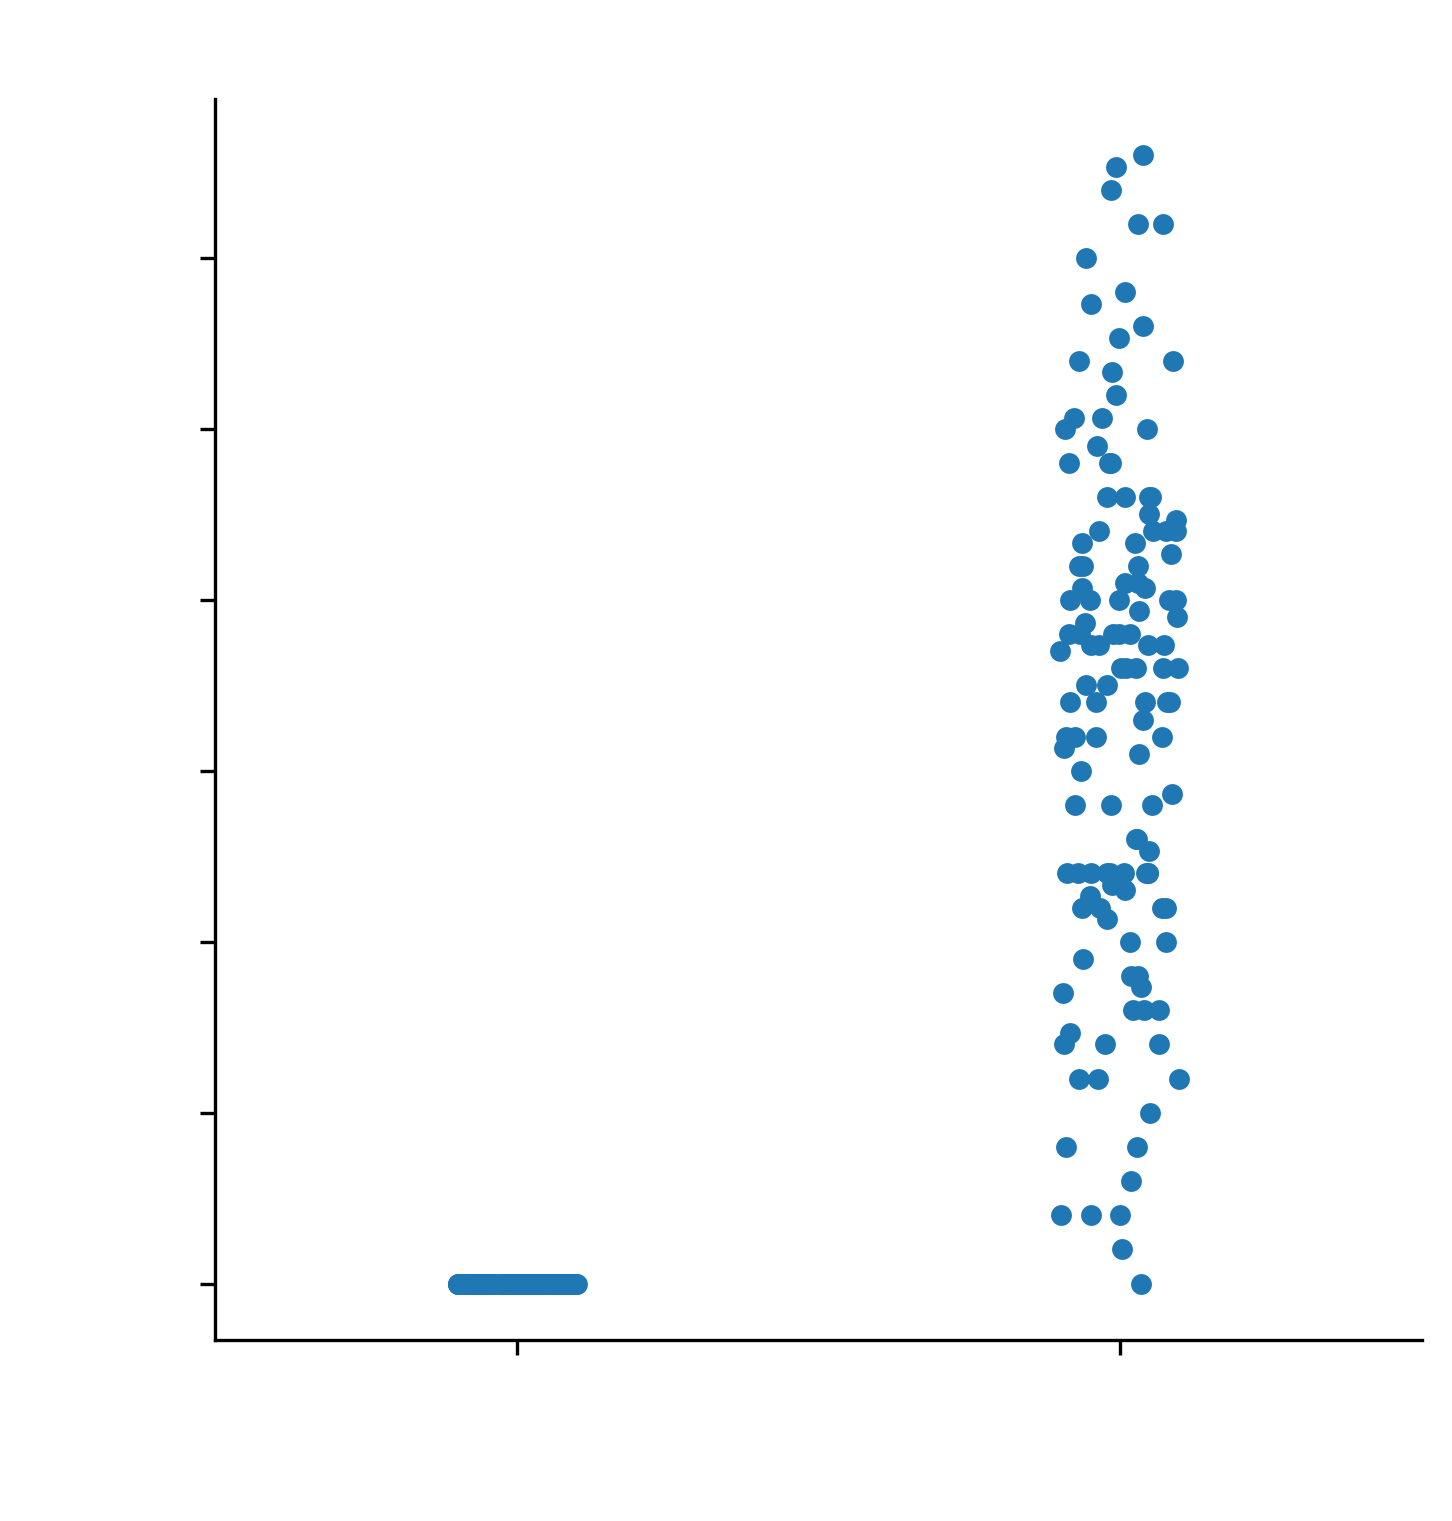

method  worker std
wid                                
A110ICG2VQUGXS  Ranking    1.426148
A1198W1SPF1R4   Ranking    1.432230
A12HWPFXQPITHD  Ranking    1.450953
A12R2U6TBB3OOG  Ranking    1.426148
A132MSWBBVTOES  Ranking    1.426148
...                 ...         ...
AV22FQTJNBUZT    Rating    1.031095
AX8NXTT8QMGHC    Rating    1.233249
AXPZAP62ZYWP8    Rating    1.050063
AXY0D2AMLKE2A    Rating    1.231174
AZ69TBTDH7AZS    Rating    1.588358

[255 rows x 2 columns]

In [24]:
mean_value_per_worker = comb_df.groupby(['method', 'wid'])['value'].mean().reset_index('method').rename(
    columns={'value': 'worker mean'})
std_value_per_worker = comb_df.groupby(['method', 'wid'])['value'].std(ddof=1).reset_index('method').rename(
    columns={'value': 'worker std'})

sns.catplot(data=mean_value_per_worker, x='method', y='worker mean')
plt.title('Mean query scores per worker')
plt.show()

std_value_per_worker

In [25]:
mean_value_per_worker.loc[mean_value_per_worker['worker mean'] >= 4.5]

method  worker mean
wid                                
A1OM5NWYYYJKQW  Rating     4.650000
A27O7H19C0WQ7T  Rating     4.633333
A35TUIBF05DKM4  Rating     4.550000
A3L2XKXABNO0N5  Rating     4.550000
A3P7AXWF57BHNX  Rating     4.500000
ARD4G7288R1JO   Rating     4.600000

In [26]:
comb_df[comb_df['wid'] == 'A1OM5NWYYYJKQW'].sort_values('value')

method topic           rid                                  query  \
6075  Rating   223  649698663782                           food pyramid   
9750  Rating   286  649698663782                          schizophrenia   
8948  Rating   266  649698663782                           heart attack   
8947  Rating   266  649698663782               heart attack first steps   
8946  Rating   266  649698663782   what to do to prevent a heart attack   
8945  Rating   266  649698663782            heart and stroke foundation   
9752  Rating   286  649698663782           schizophrenia drug treatment   
9751  Rating   286  649698663782               schizophrenia medication   
8949  Rating   266  649698663782              heart attack symptom list   
8089  Rating   259  649698663782            how to remove carpenter bee   
8088  Rating   259  649698663782                  carpenter bee removal   
8087  Rating   259  649698663782                            bee removal   
8086  Rating   259  649698663782                hotline for bee control   
8085  Rating   259  649698663782                           pest control   
6079  Rating   223  649698663782                      usda food pyramid   
6078  Rating   223  649698663782                 food pyramid from usda   
6077  Rating   223  649698663782              usda nutrition guidelines   
6076  Rating   223  649698663782              healthy food pyramid diet   
9753  Rating   286  649698663782  common drug therapy for schizophrenia   
9754  Rating   286  649698663782           drug treatment schizophrenia   

      value             wid  batch  duration             EndDate  query_mean  \
6075      3  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.590909   
9750      4  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    2.681818   
8948      4  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.102273   
8947      4  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.000000   
8946      4  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    2.863636   
8945      4  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    2.068182   
9752      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.681818   
9751      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.340909   
8949      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.852273   
8089      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.840909   
8088      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.784091   
8087      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.409091   
8086      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    2.693182   
8085      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    2.522727   
6079      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.806818   
6078      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.772727   
6077      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.897727   
6076      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    3.829545   
9753      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.681818   
9754      5  A1OM5NWYYYJKQW  green       403 2022-02-14 11:25:45    4.693182   

      batch_order       qid  user_nDCG@10                          user_query  \
6075            1  223-6720      0.356010                   usda food pyramid   
9750            1  286-6720      0.032044                  schizophrenia meds   
8948            1  266-5955      0.384633  symptoms of heart attack men women   
8947            1  266-5597      0.384633  symptoms of heart attack men women   
8946            1  266-9035      0.384633  symptoms of heart attack men women   
8945            1  266-7317      0.384633  symptoms of heart attack men women   
9752            1  286-5878      0.032044                  schizophrenia meds   
9751            1  286-6826      0.032044                  schizophrenia meds   
8949            1  2

In [27]:
# normalizing with mean and std
comb_df = comb_df.assign(
    norm_value=lambda x: (x['value'] - mean_value_per_worker.loc[x['wid'], 'worker mean'].to_numpy()) /
                         std_value_per_worker.loc[x['wid'], 'worker std'].to_numpy())
# normalizing with mean only
# comb_df = comb_df.assign(
#     norm_value=lambda x: (x['value'] - mean_value_per_worker.loc[x['wid'], 'worker mean'].to_numpy() + 3))
# normalizing with mean, ceiling and clipping
# comb_df = comb_df.assign(
#     norm_value=lambda x: (np.ceil(x['value'] - mean_value_per_worker.loc[x['wid'], 'worker mean'].to_numpy() + 3)).clip(1, 5))
comb_df.groupby('method')[['value', 'norm_value']].describe().T

method                 Ranking        Rating
value      count  5.160000e+03  4.700000e+03
           mean   3.000000e+00  3.835745e+00
           std    1.414351e+00  1.263631e+00
           min    1.000000e+00  1.000000e+00
           25%    2.000000e+00  3.000000e+00
           50%    3.000000e+00  4.000000e+00
           75%    4.000000e+00  5.000000e+00
           max    5.000000e+00  5.000000e+00
norm_value count  5.160000e+03  4.700000e+03
           mean   5.163828e-19  9.070758e-18
           std    9.879091e-01  9.861782e-01
           min   -1.402379e+00 -3.800166e+00
           25%   -7.011895e-01 -6.804802e-01
           50%    0.000000e+00  2.236068e-01
           75%    7.011895e-01  8.235164e-01
           max    1.402379e+00  1.759540e+00

In [28]:
comb_df = comb_df.assign(normalized_value=comb_df.groupby(['wid', 'topic'])['value'].rank(method='average'))
comb_df.loc[(comb_df['method'] == 'Rating') & (comb_df['wid'] == 'A27O7H19C0WQ7T'), ['topic', 'query', 'value',
                                                                                     'normalized_value']]

topic                                            query  value  \
5470    213                                     cts syndrome      1   
5471    213                                    carpal tunnel      5   
5472    213                      carpal tunnel syndrome wiki      5   
5473    213                   what is carpal tunnel syndrome      5   
5474    213                           carpal tunnel syndrome      5   
6185    223                                     food pyramid      5   
6186    223                        healthy food pyramid diet      5   
6187    223                        usda nutrition guidelines      5   
6188    223                           food pyramid from usda      5   
6189    223                                usda food pyramid      5   
6275    234                                     healthy food      1   
6276    234                           healthy dark chocolate      5   
6277    234                            dark chocolate health      5   
6278    234  how healthy is dark chocolate to the human body      5   
6279    234                  health impact of dark chocolate      5   
6755    238                                      george bush      5   
6756    238                                  george h w bush      5   
6757    238      what is a good biography on george h w bush      5   
6758    238                         george hw bush biography      5   
6759    238              president george h w bush biography      5   
7175    244                              old town scottsdale      5   
7176    244                      old town scottsdale phoenix      5   
7177    244                      info on old town scottsdale      5   
7178    244                      old town scottsdale history      5   
7179    244           history of old town scottsdale arizona      5   
7480    253                           treatment for jaw pain      4   
7481    253                             tooth pain treatment      5   
7482    253                                abscess treatment      5   
7483    253                      treatment for tooth abscess      5   
7484    253                          tooth abscess treatment      5   
8195    259                                     pest control      5   
8196    259                          hotline for bee control      4   
8197    259                                      bee removal      5   
8198    259                            carpenter bee removal      5   
8199    259                      how to remove carpenter bee      5   
8400    261                                      sore throat      5   
8401    261                           home care cough remedy      5   
8402    261             what can i use to cure a sore throat      5   
8403    261  what are some homemade remedy for a sore throat      5   
8404    261                          sore throat home remedy      5   
9055    266                      heart and stroke foundation      4   
9056    266             what to do to prevent a heart attack      3   
9057    266                         heart attack first steps      5   
9058    266                                     heart attack      5   
9059    266                        heart attack symptom list      5   
9145    283                             ride in pennsylvania      1   
9146    283                         pennsylvania usa hayride      5   
9147    283                             hayride pennsylvania      5   
9148    283                          hayride in pennsylvania      5   
9149    283    where in pennsylvania you can go on a hayride      5   
9860    286                                    schizophrenia      3   
9861    286                         schizophrenia medication      5   
9862    286                     schizophrenia drug treatment      4   
9863    286            common drug therapy for schizophrenia      5   
9864    286                     drug treatment schizophrenia      4   
10065   297                   

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


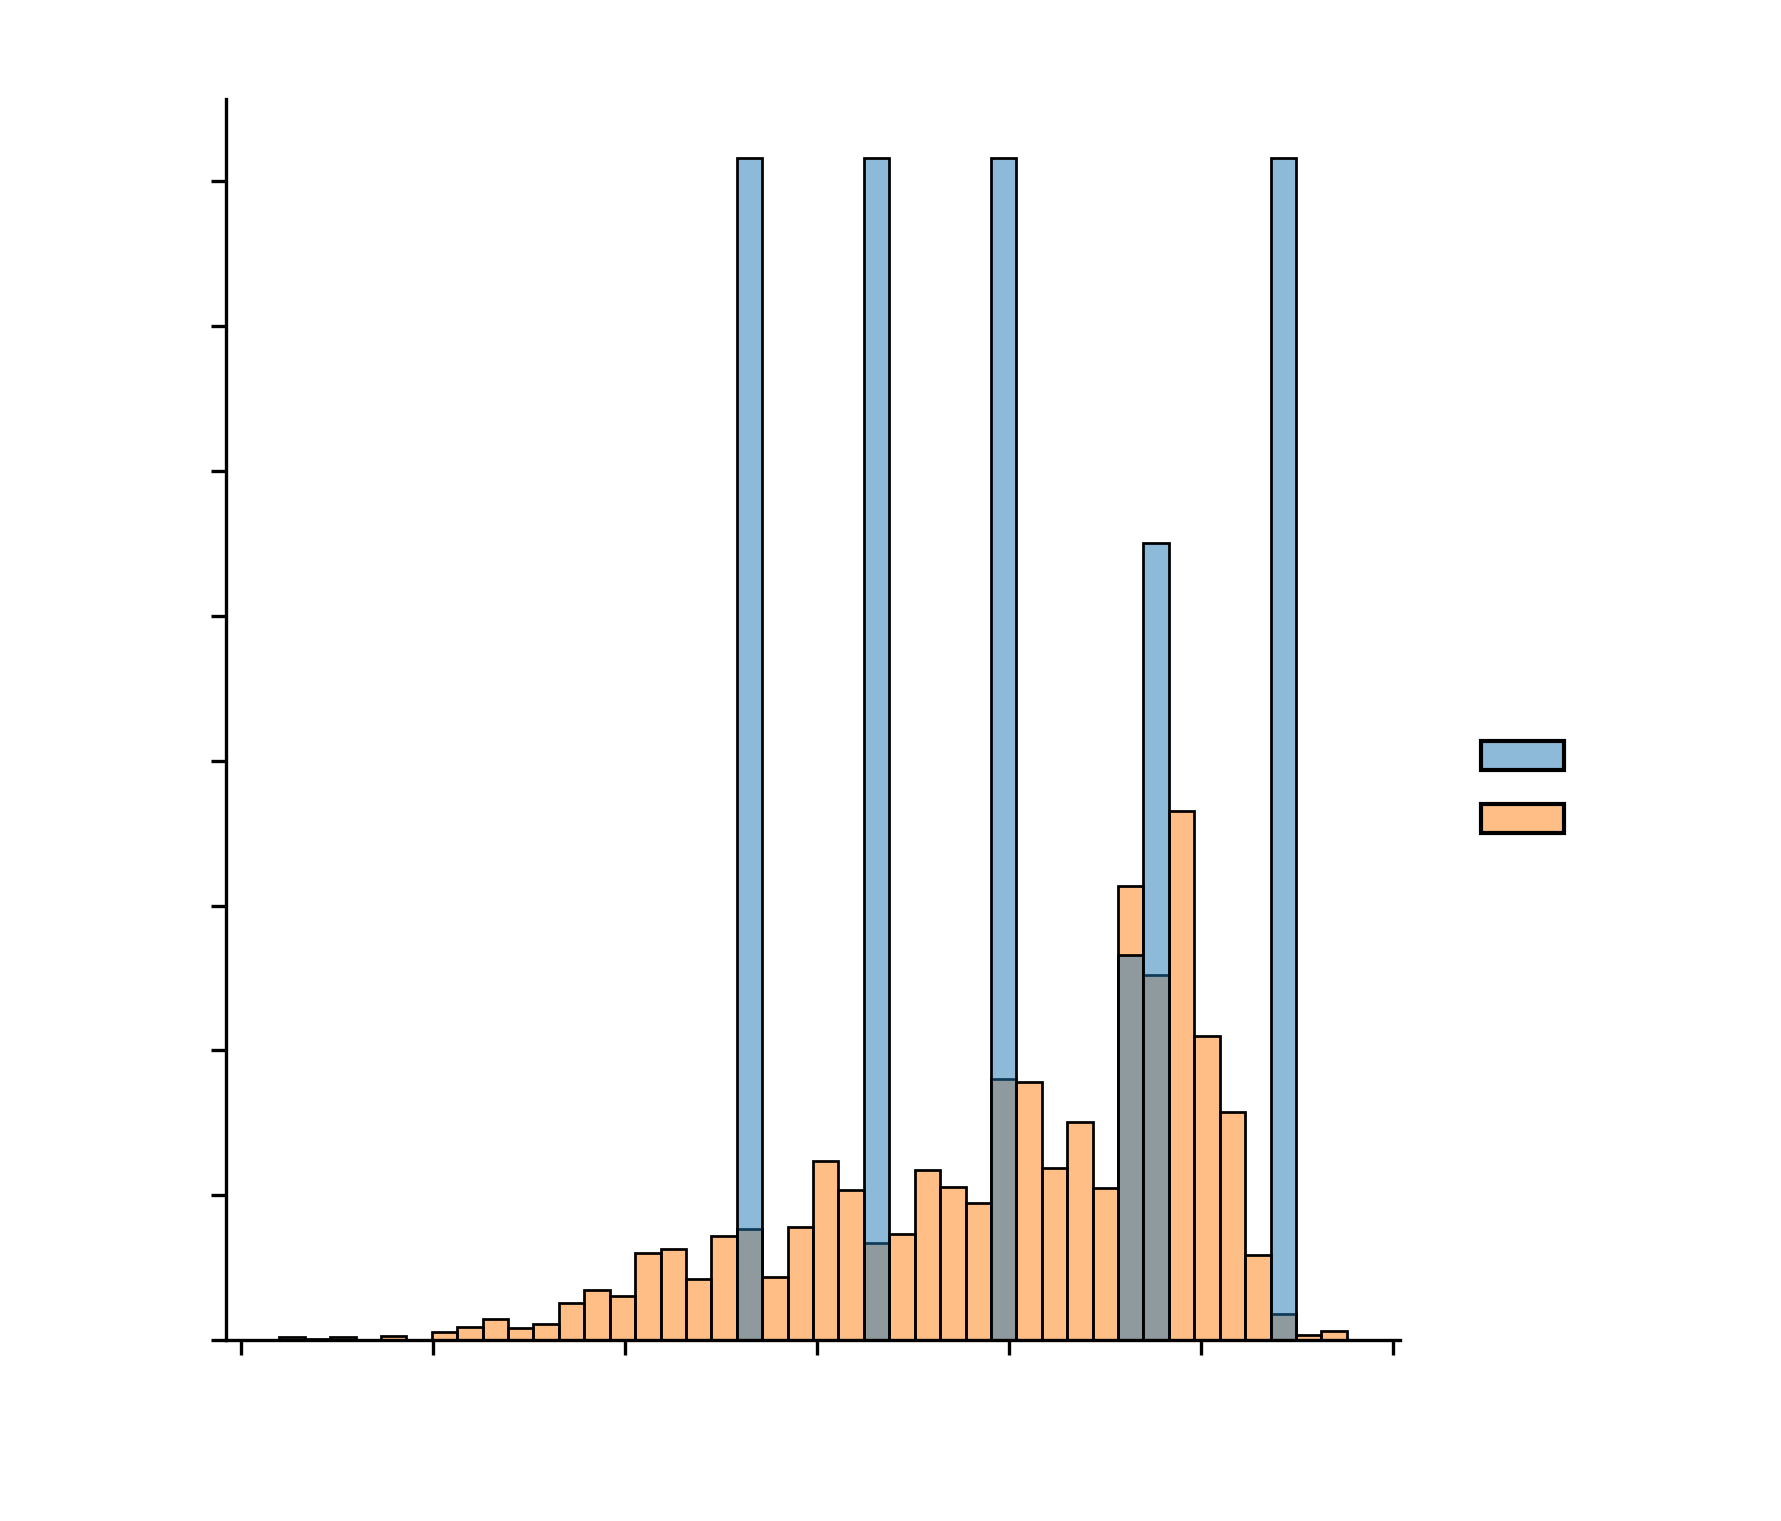

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


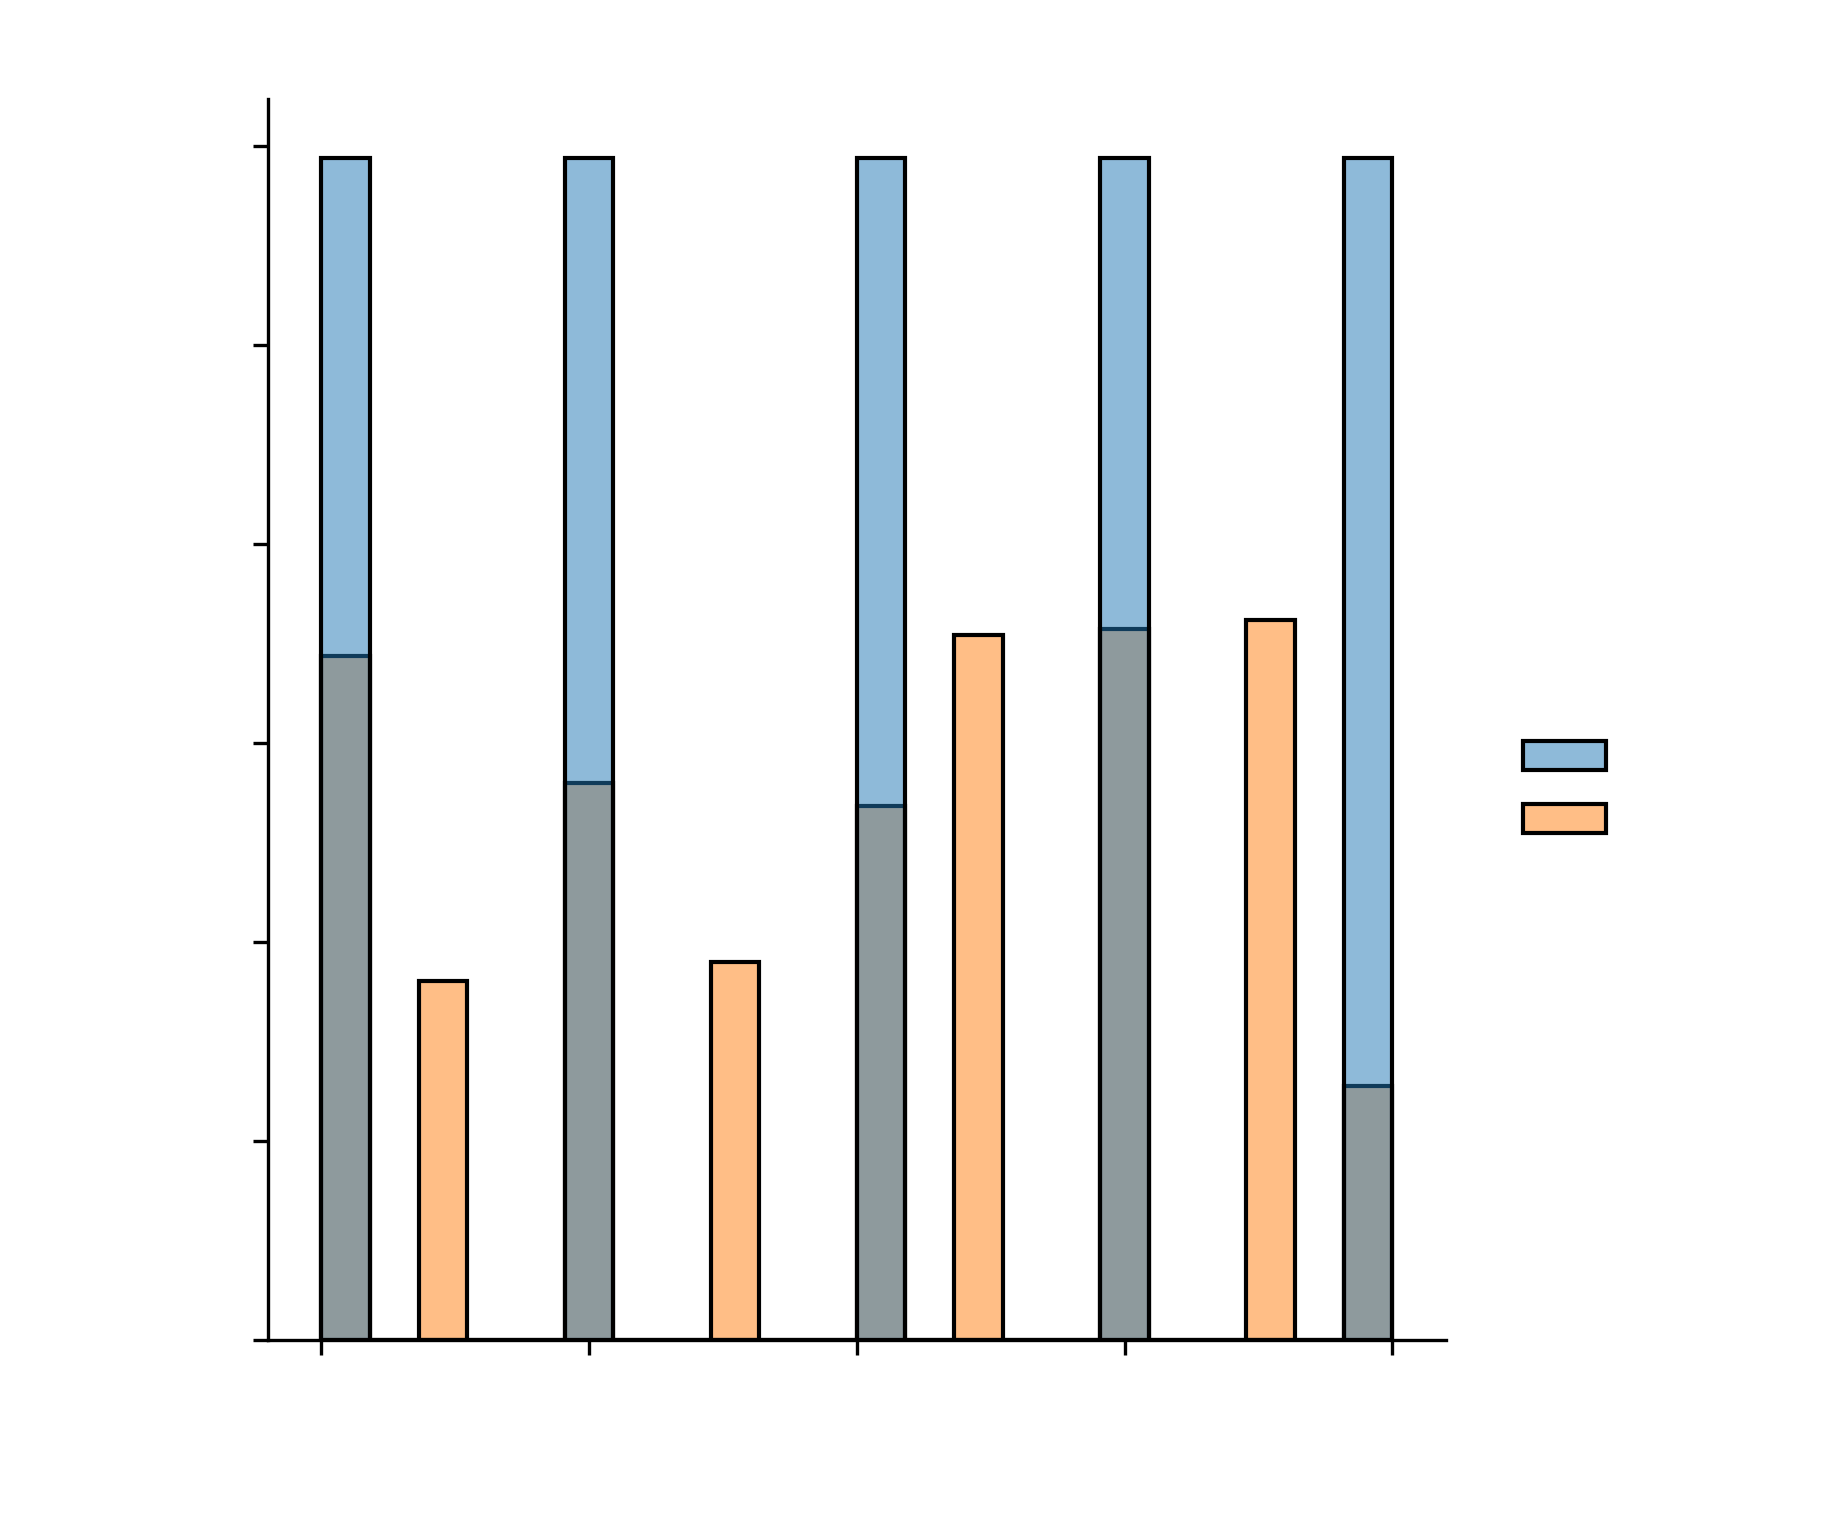

In [29]:
sns.displot(data=comb_df.set_index('query', append=True), x='norm_value', hue='method', stat='frequency',
            multiple='layer', discrete=False)
plt.title('Histogram of query scores per worker with normalization')
plt.show()

sns.displot(data=comb_df.set_index('query', append=True), x='normalized_value', hue='method', stat='frequency',
            multiple='layer', discrete=False)
plt.title('Histogram of query scores per worker with quantile normalization')
plt.show()

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


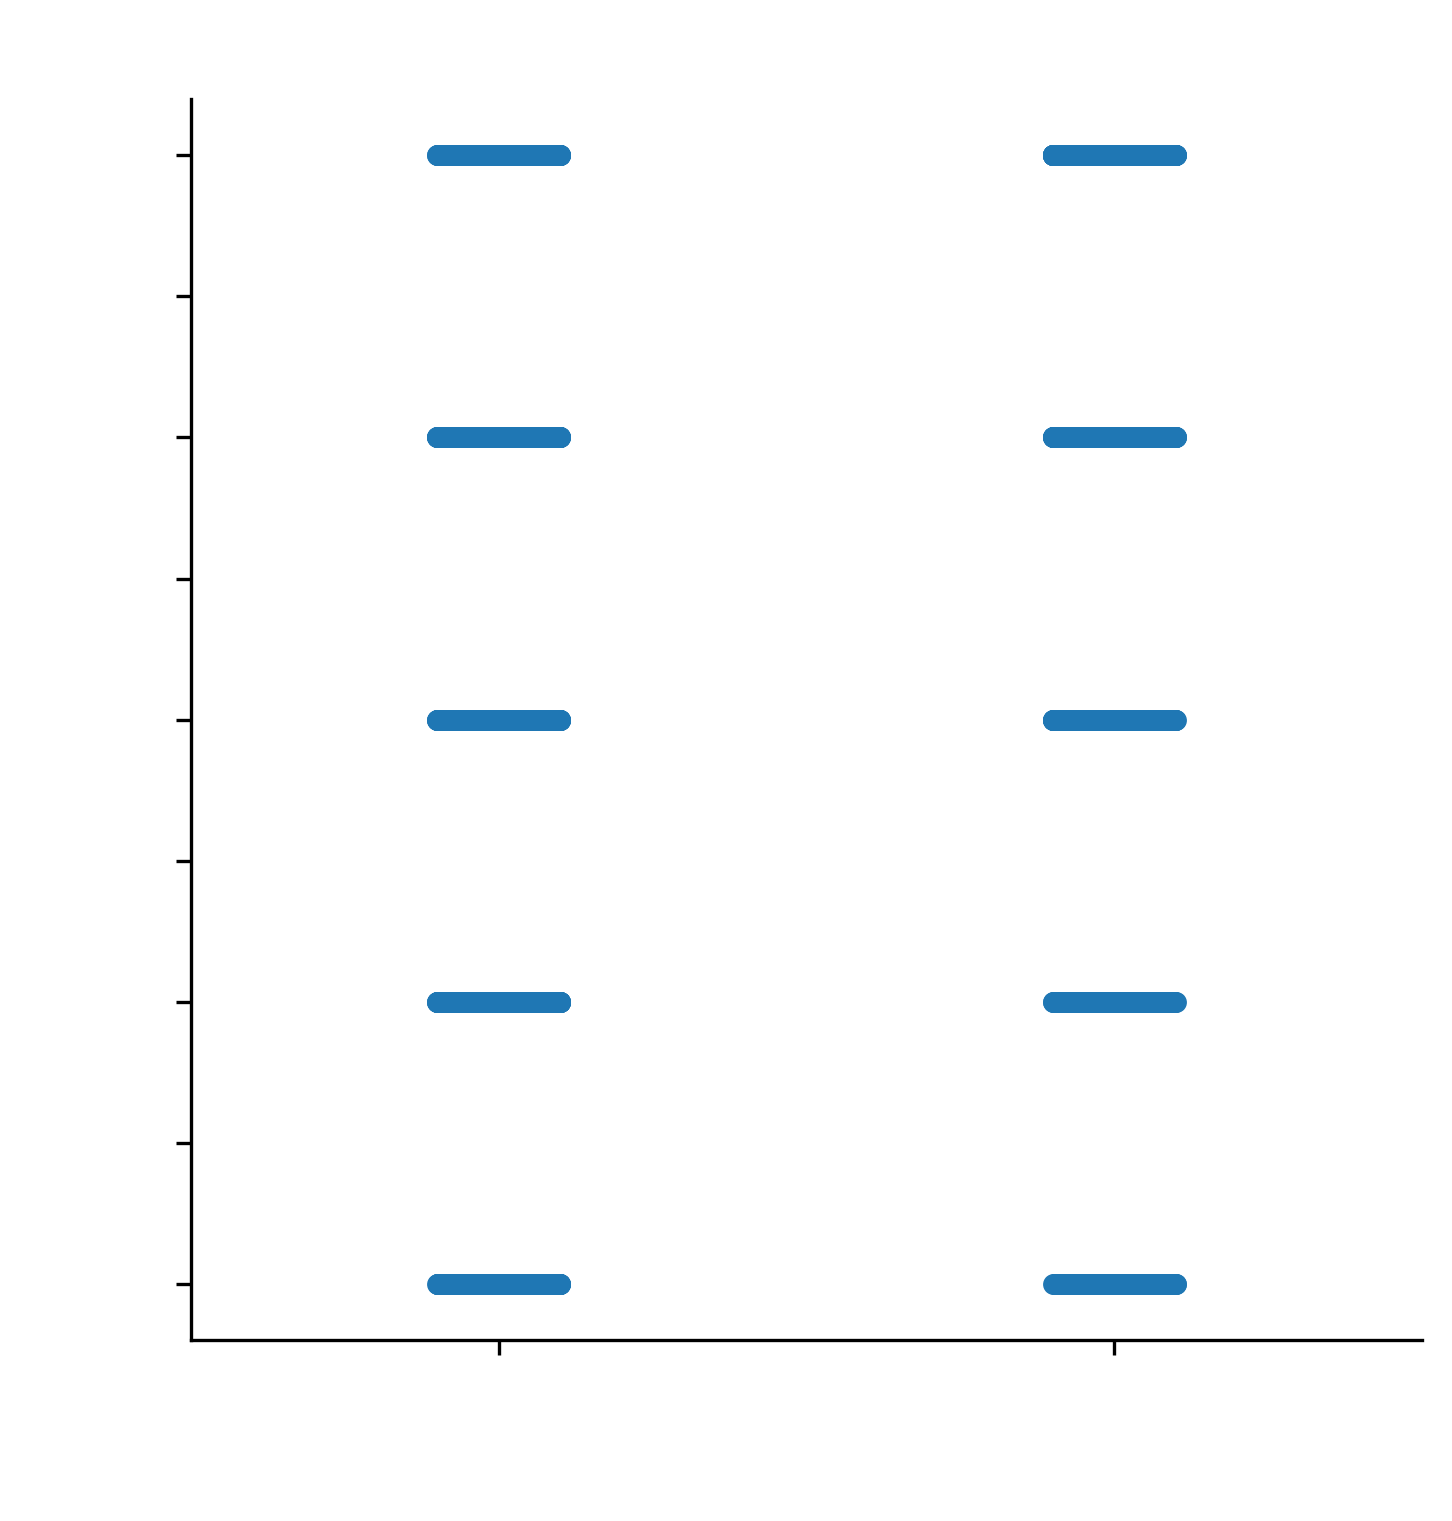

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


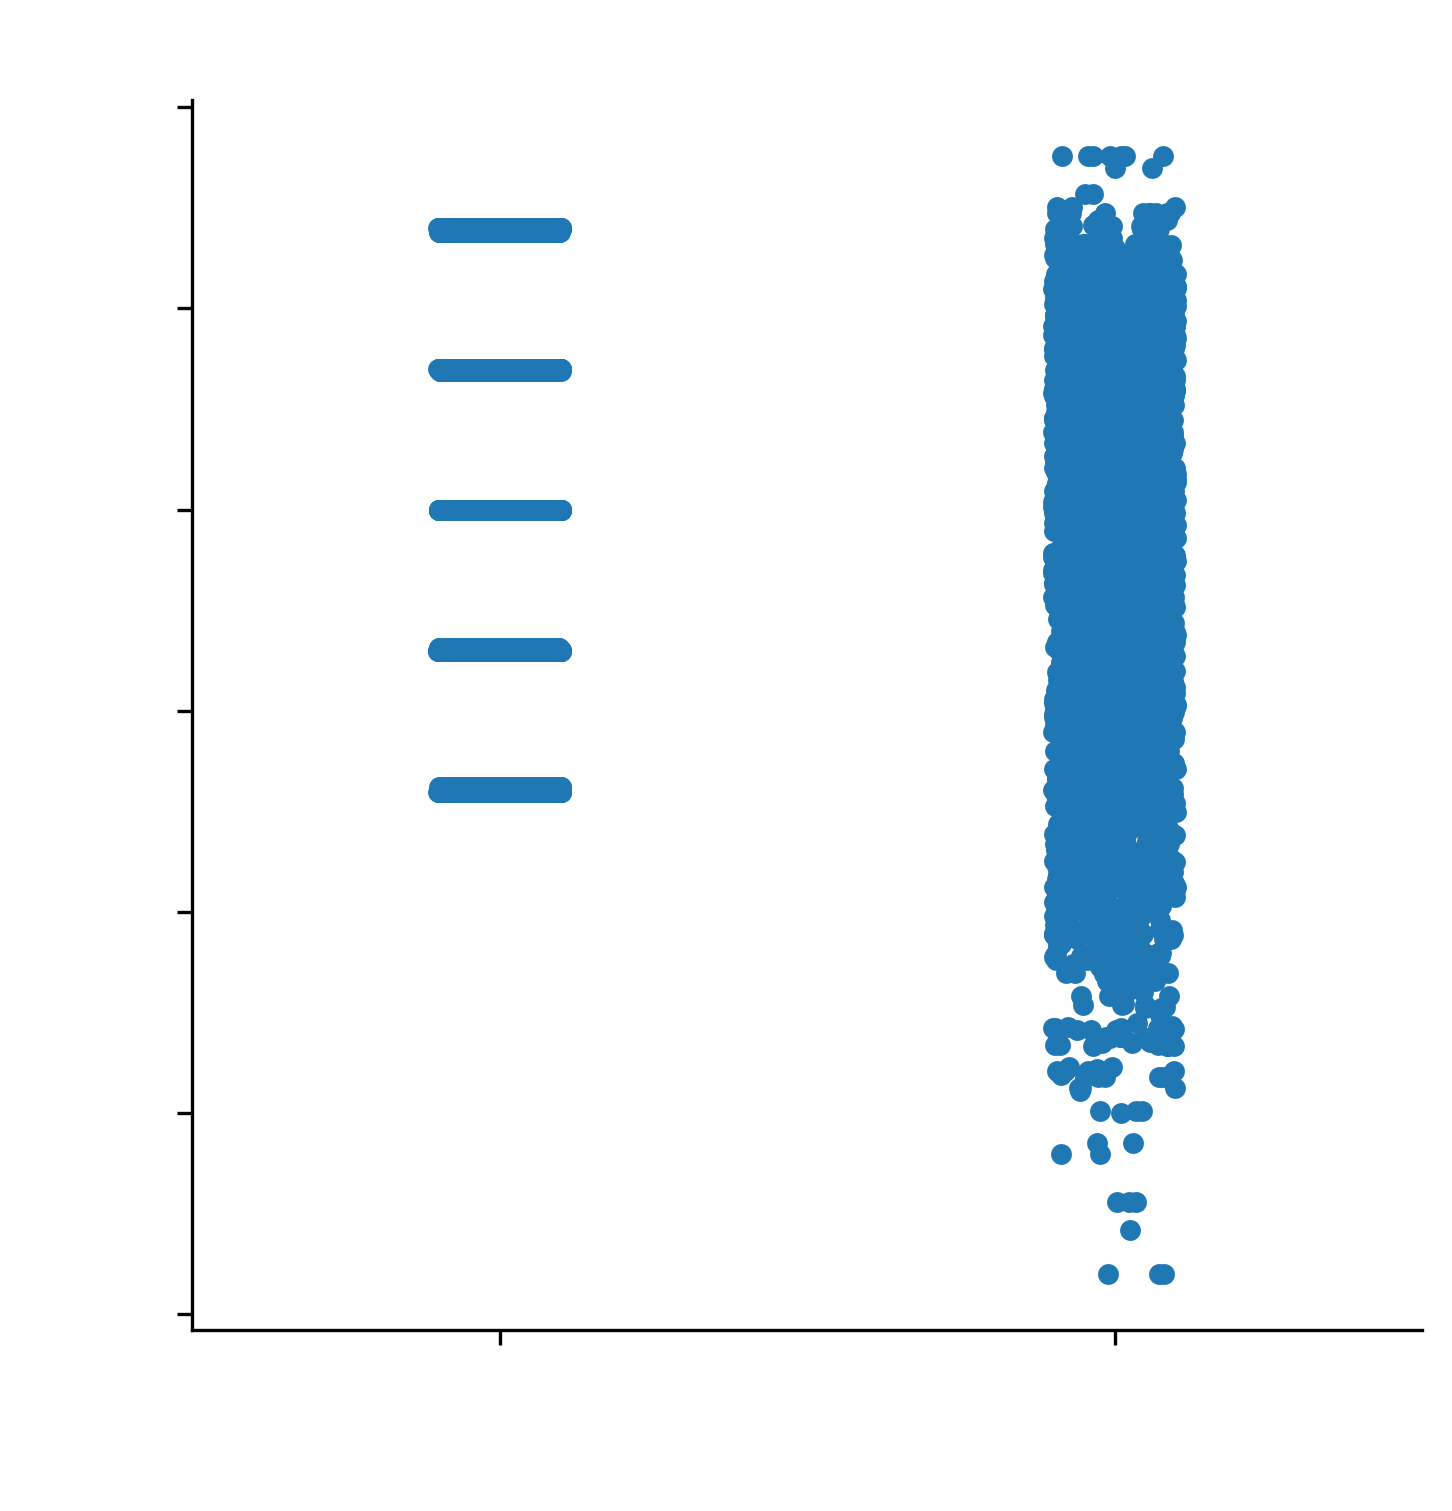

In [30]:
sns.catplot(data=comb_df, x='method', y='value')
plt.title('Query scores per worker before normalization')
plt.show()
sns.catplot(data=comb_df, x='method', y='norm_value')
plt.title('Query scores per worker after normalization')
plt.show()

In [31]:
log = np.log
session_times = comb_df.groupby(['method', 'wid', 'rid'])['duration'].unique().explode().rename('log_duration')
session_times = log(pd.to_numeric(session_times))
mean_worker_time = session_times.groupby('wid').mean().rename('mean_worker_time')
mean_overall_time = session_times.mean()
mean_time_per_method = session_times.groupby(['method']).mean().rename('mean_method_time')
# session_times.to_frame().assign(x=1)
_session_times = session_times.reset_index().join(mean_worker_time, on='wid').join(mean_time_per_method,
                                                                                   on='method').assign(
    mean_global_time=mean_overall_time)
session_times = session_times.reset_index().assign(norm_time=np.exp(
    _session_times['log_duration'] + _session_times['mean_method_time'] + _session_times['mean_worker_time'])).drop(
    columns=['wid', 'method']).set_index('rid')
session_times

log_duration     norm_time
rid                                     
45437107437       5.129899  7.503023e+06
81283582688       5.056246  6.970264e+06
85799648056       5.209486  8.124575e+06
64529795213       6.393591  9.430467e+07
71567408482       6.405228  9.540857e+07
...                    ...           ...
775480585638      5.817111  2.817348e+07
506562046403      6.293419  7.303927e+07
189923704648      5.318120  9.666460e+06
356693205516      5.472271  1.127754e+07
977617362863      4.948760  6.681230e+06

[493 rows x 2 columns]

In [32]:

import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm, AnovaRM


def ndt_normaliziation(duration):
    np.exp(np.log(duration) + mean_dur + mean_user_dur)


def two_way_anova(df, response, factor_1, factor_2):
    """ols formula syntax: simply """
    formula = f'{response} ~ {factor_1}*{factor_2}'
    lm = smf.ols(formula, data=df).fit()
    anova_res_df = anova_lm(lm)
    print(anova_res_df)
    _df = df.set_index(['predictor', 'kind'])
    _df.index = ['_'.join(pair) for pair in _df.index]
    tukey = pairwise_tukeyhsd(endog=_df['status'], groups=_df.index, alpha=0.01)
    tukey_res_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_res_df[['predictor1', 'kind1']] = tukey_res_df['group1'].str.split('_', expand=True)
    tukey_res_df[['predictor2', 'kind2']] = tukey_res_df['group2'].str.split('_', expand=True)
    t_res_df = tukey_res_df.loc[
        tukey_res_df['predictor1'] == tukey_res_df['predictor2'], ['predictor1', 'meandiff', 'p-adj', 'lower',
                                                                   'upper']].set_index('predictor1')
    t_res_df.index = t_res_df.index.astype(pd.CategoricalDtype(PreRetPredictors + PostRetPredictors, ordered=True))
    mean_acc = df.groupby(['predictor', 'kind'])['status'].mean().reset_index().pivot(index='predictor',
                                                                                      columns='kind').droplevel(0,
                                                                                                                axis=1)
    t_res_df['p-adj'] = t_res_df['p-adj'].map('${:.3f}$'.format)
    t_res_df['meandiff'] = t_res_df['meandiff'].map('${:.3f}$'.format)
    t_res_df = t_res_df.drop(['upper', 'lower'], axis=1).assign(
        CI=t_res_df['lower'].map('[${:.3f}$'.format).str.cat(t_res_df['upper'].map('${:.3f}$]'.format), sep=','),
        intra=mean_acc['intra'].map('${:.3f}$'.format), inter=mean_acc['inter'].map('${:.3f}$'.format))

    print(
        t_res_df.sort_index()[['intra', 'inter', 'meandiff', 'CI', 'p-adj']].rename(LatexMacros).to_latex(
            float_format="%.3f", escape=False))
    return t_res_df.sort_index()

In [33]:
_grp_df = comb_df.groupby(['rid', 'method'])
anova_df = _grp_df['duration'].unique().explode().reset_index().assign(wid=_grp_df['wid'].unique().explode().to_numpy(),
                                                                       batch=_grp_df[
                                                                           'batch'].unique().explode().to_numpy(),
                                                                       order=_grp_df[
                                                                           'batch_order'].unique().explode().to_numpy()).set_index(
    'rid')
anova_df['duration'] = pd.to_numeric(anova_df['duration'])
anova_df = anova_df.join(session_times, on='rid')
anova_df

method  duration             wid  batch order  log_duration  \
rid                                                                          
10179138621   Ranking       293  A13FTIHWW9GE8X   blue     2      5.680173   
102278297045   Rating       353  A1Z3O9QS22DM8R  green     3      5.866468   
10332905116   Ranking       363   A8FUMDQFBKMXR  green     1      5.894403   
10539678160   Ranking       332  A15LPXZLC6NUHT  green     1      5.805135   
108954327646   Rating       219   ALJ70B2J04YR7   blue     2      5.389072   
...               ...       ...             ...    ...   ...           ...   
99220783601   Ranking       281   AIOOOO5OXWXKM  green     3      5.638355   
99442555934   Ranking       179  A3S2R1NK6HZ9KP   blue     2      5.187386   
99458784954   Ranking       242  A13FTIHWW9GE8X    red     3      5.488938   
996030112938   Rating       500  A3HQXCWOIQKT4F  green     1      6.214608   
99612497282   Ranking       527   APRHR60T52KR9  green     1      6.267201   

                 norm_time  
rid                         
10179138621   2.130858e+07  
102278297045  3.472519e+07  
10332905116   3.454753e+07  
10539678160   2.840322e+07  
108954327646  1.188156e+07  
...                    ...  
99220783601   2.657098e+07  
99442555934   8.493933e+06  
99458784954   1.759958e+07  
996030112938  4.830711e+07  
99612497282   7.078620e+07  

[493 rows x 7 columns]

In [34]:
anova_df.loc[anova_df['order'] == 1].sort_values(['wid', 'order'])

method  duration             wid  batch order  log_duration  \
rid                                                                          
683046185830   Rating       186  A107RJSS561Y7R    red     1      5.225747   
85799648056   Ranking       183  A110ICG2VQUGXS  green     1      5.209486   
158281811256   Rating       137  A110KENBXU7SUJ  green     1      4.919981   
150148628698   Rating       374  A11YS0T8MV3Q7C   blue     1      5.924256   
47942251241   Ranking       158  A12HWPFXQPITHD    red     1      5.062595   
...               ...       ...             ...    ...   ...           ...   
86675851708   Ranking       158   AWVLT2L5AP873  green     1      5.062595   
610691223060   Rating       322   AX8NXTT8QMGHC  green     1      5.774552   
775480585638   Rating       336   AXPZAP62ZYWP8  green     1      5.817111   
506562046403   Rating       541   AXY0D2AMLKE2A    red     1      6.293419   
356693205516   Rating       238   AZ69TBTDH7AZS   blue     1      5.472271   

                 norm_time  
rid                         
683046185830  9.019434e+06  
85799648056   8.124575e+06  
158281811256  4.651434e+06  
150148628698  3.490640e+07  
47942251241   6.545124e+06  
...                    ...  
86675851708   6.400459e+06  
610691223060  1.835715e+07  
775480585638  2.817348e+07  
506562046403  7.303927e+07  
356693205516  1.127754e+07  

[247 rows x 7 columns]

In [35]:
anova_df.loc[(anova_df['wid'].isin(wids_did_all))]

method  duration             wid  batch order  log_duration  \
rid                                                                          
10179138621   Ranking       293  A13FTIHWW9GE8X   blue     2      5.680173   
102278297045   Rating       353  A1Z3O9QS22DM8R  green     3      5.866468   
10539678160   Ranking       332  A15LPXZLC6NUHT  green     1      5.805135   
108954327646   Rating       219   ALJ70B2J04YR7   blue     2      5.389072   
11068552236   Ranking       230  A3QUUPHBTNW5KG   blue     2      5.438079   
...               ...       ...             ...    ...   ...           ...   
988950577517   Rating       326  A3HQXCWOIQKT4F    red     2      5.786897   
99220783601   Ranking       281   AIOOOO5OXWXKM  green     3      5.638355   
99458784954   Ranking       242  A13FTIHWW9GE8X    red     3      5.488938   
996030112938   Rating       500  A3HQXCWOIQKT4F  green     1      6.214608   
99612497282   Ranking       527   APRHR60T52KR9  green     1      6.267201   

                 norm_time  
rid                         
10179138621   2.130858e+07  
102278297045  3.472519e+07  
10539678160   2.840322e+07  
108954327646  1.188156e+07  
11068552236   1.428181e+07  
...                    ...  
988950577517  3.149624e+07  
99220783601   2.657098e+07  
99458784954   1.759958e+07  
996030112938  4.830711e+07  
99612497282   7.078620e+07  

[291 rows x 7 columns]

Rating
Number of sessions 117
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
order 14.1009 2.0000 76.0000 0.0000

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
------------------------------------------------------
     1      2 -36.8974  0.308  -96.4078 22.6129  False
     1      3 -65.0769 0.0285 -124.5873 -5.5666   True
     2      3 -28.1795  0.501  -87.6898 31.3308  False
------------------------------------------------------
HSD CI's plot for Rating


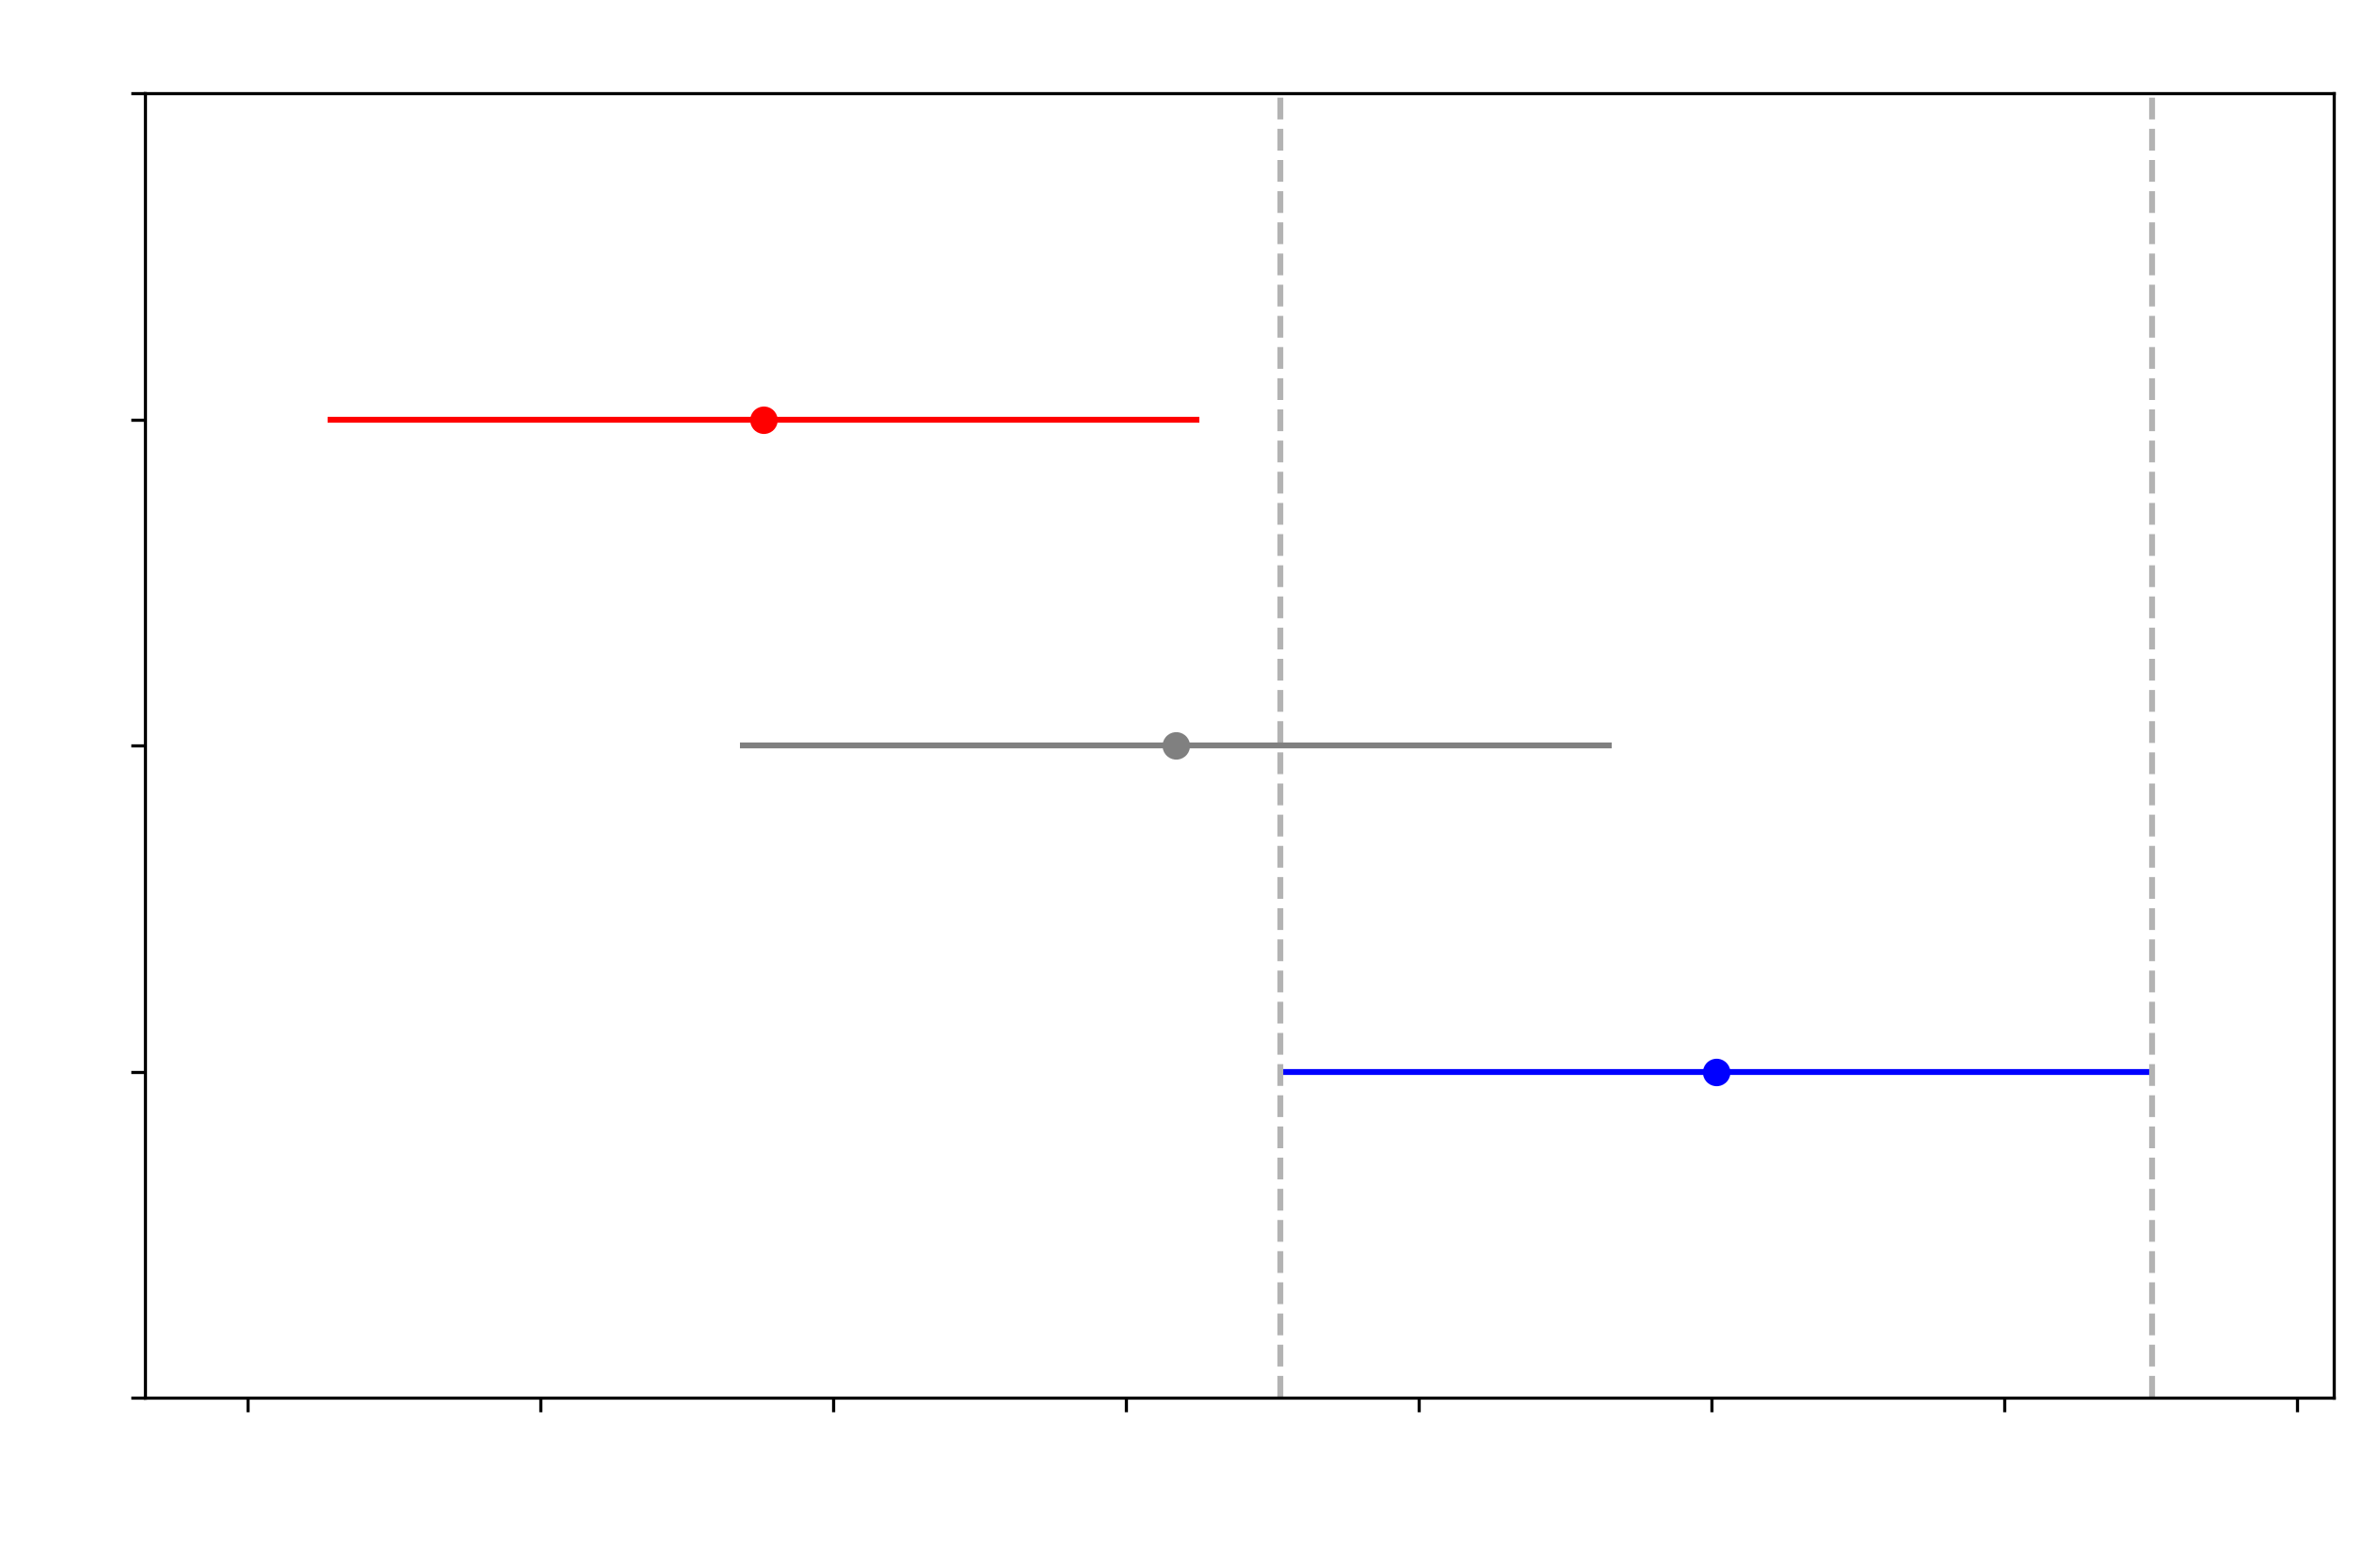

Ranking
Number of sessions 174
               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
order 17.1793 2.0000 114.0000 0.0000

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -48.9483 0.0228 -92.3696  -5.527   True
     1      3  -43.931 0.0467 -87.3523 -0.5098   True
     2      3   5.0172 0.9597  -38.404 48.4385  False
-----------------------------------------------------
HSD CI's plot for Ranking


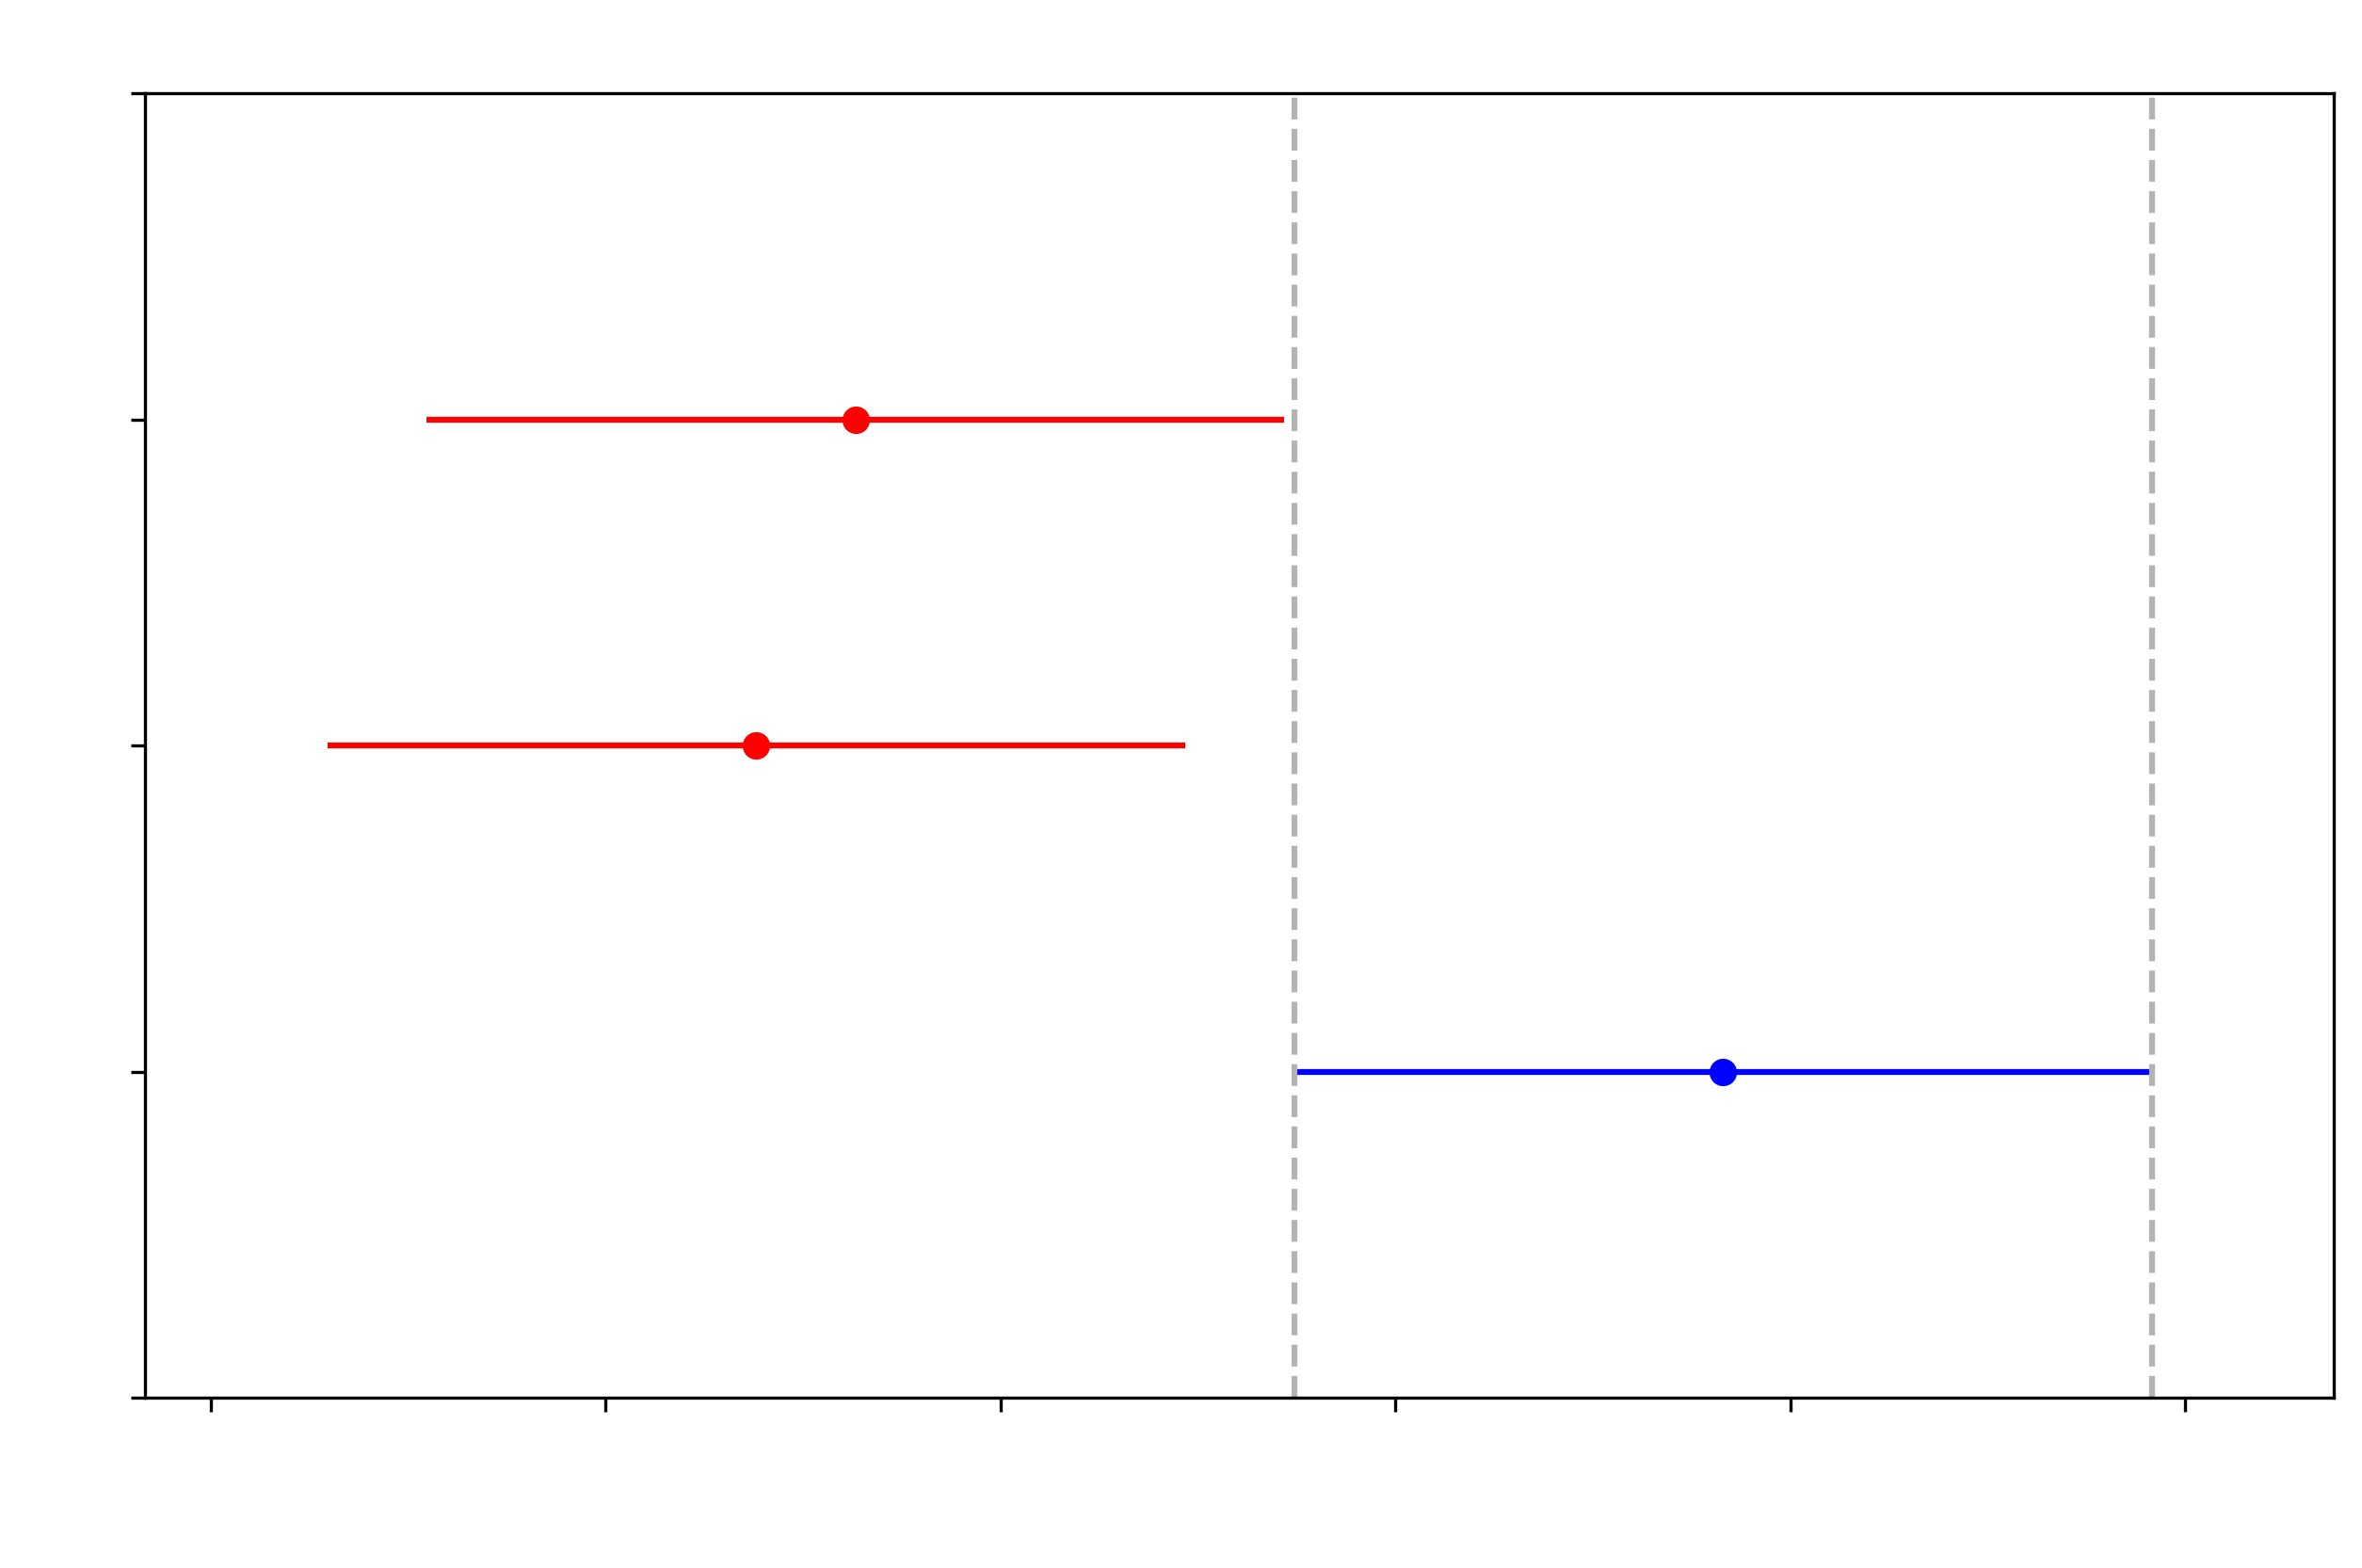

In [36]:
an_df = anova_df.loc[(anova_df['wid'].isin(wids_did_all))]
for m in ['Rating', 'Ranking']:
    print(m)
    _df = an_df.loc[an_df['method'] == m]
    print(f'Number of sessions {len(_df)}')
    print(AnovaRM(_df, 'duration', 'wid', within=['order'], aggregate_func=None).fit())
    tukey_result = pairwise_tukeyhsd(endog=_df['duration'], groups=_df.order, alpha=0.05)
    print(tukey_result.summary())
    print(f'HSD CI\'s plot for {m}')
    tukey_result.plot_simultaneous(comparison_name=1, xlabel='Seconds', ylabel='Order')
    plt.show()

In [37]:
def run_anova(anova_df, response, *factors, cross_factors=True):
    if cross_factors:
        formula = f'{response} ~ ' + ' * '.join(factors)
    else:
        formula = f'{response} ~ ' + ' + '.join(factors)
    print(formula)
    lm = smf.ols(formula, data=anova_df).fit()
    anova_res_df = anova_lm(lm)
    anova_res_df = anova_res_df.assign(eta_sq=anova_res_df['sum_sq'] / anova_res_df['sum_sq'].sum(),
                                       partial_eta_sq=anova_res_df['sum_sq'] / (
                                               anova_res_df['sum_sq'] + anova_res_df.loc['Residual', 'sum_sq']),
                                       omega_sq=(anova_res_df['sum_sq'] - (
                                               anova_res_df['df'] * anova_res_df.loc['Residual', 'mean_sq'])) / (
                                                        anova_res_df['sum_sq'].sum() + anova_res_df.loc[
                                                    'Residual', 'mean_sq']),
                                       ri=(anova_res_df['mean_sq'] - anova_res_df.loc['Residual', 'mean_sq']) / (
                                               anova_res_df['mean_sq'] + anova_res_df['df'] * anova_res_df.loc[
                                           'Residual', 'mean_sq']))
    return anova_res_df


def run_repeated_anova(anova_df, response, *factors, cross_factors=True):
    if cross_factors:
        formula = f'{response} ~ ' + ' * '.join(factors)
    else:
        formula = f'{response} ~ ' + ' + '.join(factors)

    print(formula)
    lm = smf.ols(formula, data=anova_df).fit()
    anova_res_df = anova_lm(lm)
    anova_res_df = anova_res_df.assign(eta_sq=anova_res_df['sum_sq'] / anova_res_df['sum_sq'].sum(),
                                       partial_eta_sq=anova_res_df['sum_sq'] / (
                                               anova_res_df['sum_sq'] + anova_res_df.loc['Residual', 'sum_sq']),
                                       omega_sq=(anova_res_df['sum_sq'] - (
                                               anova_res_df['df'] * anova_res_df.loc['Residual', 'mean_sq'])) / (
                                                        anova_res_df['sum_sq'].sum() + anova_res_df.loc[
                                                    'Residual', 'mean_sq']),
                                       ri=(anova_res_df['mean_sq'] - anova_res_df.loc['Residual', 'mean_sq']) / (
                                               anova_res_df['mean_sq'] + anova_res_df['df'] * anova_res_df.loc[
                                           'Residual', 'mean_sq']))
    return anova_res_df


response = 'duration'
factor_1 = 'method'
factor_2 = 'batch'
factor_3 = 'order'
print('ANOVA with raw times:')
# anova_res_df_1 = run_anova(anova_df, response, factor_2, factor_1, factor_3, factor_4)
first_anova_res_df_1 = run_anova(anova_df.loc[anova_df['order'] == 1], response, factor_1, factor_2)
print(first_anova_res_df_1.to_markdown(floatfmt='g'))
LatexNames = {'method': 'Interface', 'order': 'HITorder', 'batch': 'Batch', 'sum_sq': 'SSQ', 'mean_sq': 'MS',
              'partial_eta_sq': 'partial $\eta^2$'}
print(first_anova_res_df_1[['df', 'sum_sq', 'mean_sq', 'F', 'PR(>F)', 'partial_eta_sq']].astype({'df': int}).rename(
    LatexNames).rename(LatexNames, axis=1).to_latex(float_format='%.3f', escape=False))

# only participants that did all 3 batches
all_anova_res_df_1 = run_anova(anova_df.loc[(anova_df['wid'].isin(wids_did_all))], response, factor_1, factor_3,
                               cross_factors=True)
print(all_anova_res_df_1.to_markdown(floatfmt='g'))
# print(all_anova_res_df_1[['df', 'sum_sq', 'mean_sq', 'F', 'PR(>F)', 'partial_eta_sq']].astype({'df': int}).rename(
#     LatexNames).to_latex(float_format='%.3f'))

# response = 'norm_time'
# print('\nANOVA with normalized times:')
# anova_res_df_2 = run_anova(anova_df, response, factor_1, factor_2, factor_3)
# print(anova_res_df_2.to_markdown(floatfmt='g'))

ANOVA with raw times:
duration ~ method * batch
|              |   df |          sum_sq |   mean_sq |          F |     PR(>F) |     eta_sq |   partial_eta_sq |     omega_sq |         ri |
|:-------------|-----:|----------------:|----------:|-----------:|-----------:|-----------:|-----------------:|-------------:|-----------:|
| method       |    1 |  4009.31        |   4009.31 |   0.271917 |   0.602528 | 0.0011141  |       0.00112701 | -0.00297095  | -0.57243   |
| batch        |    2 | 14341           |   7170.48 |   0.486311 |   0.615493 | 0.00398505 |       0.00401955 | -0.00419222  | -0.206607  |
| method:batch |    2 | 26880           |  13440    |   0.911518 |   0.403295 | 0.00746939 |       0.00750767 | -0.000722103 | -0.0303903 |
| Residual     |  241 |     3.55346e+06 |  14744.6  | nan        | nan        | 0.987431   |       0.5        |  0           |  0         |
\begin{tabular}{lrrrrrr}
\toprule
 & df & SSQ & MS & F & PR(>F) & partial $\eta^2$ \\
\midrule
Interface & 1 & 4

In [38]:
anova_df[anova_df['order'] == 1]['wid'].nunique()

247

In [39]:
# np.round(anova_res_df_2, 3)

The n-way ANOVA result tells us that the method alone isn't significant, that is that simply by looking at the different interface (Rating vs Ranking) the duration is not significantly different.
But the interaction of method and order is significant, that is, the effect of the order within the different interfaces is different. This might imply that the learning curve is steeper within one of the interfaces.

In [40]:
sns.algorithms.bootstrap(ranks_df['value'])

array([2.99166667, 2.99302326, 3.00872093, ..., 2.98934109, 3.04457364,
       2.99496124])

In [41]:
print(f"Total of {comb_df['wid'].nunique()} workers submitted the filtered HITs")
print(f"Every worker did {comb_df.groupby('wid')['batch'].nunique().mean():.4g} HITs on average")

Total of 255 workers submitted the filtered HITs
Every worker did 1.933 HITs on average


In [42]:
comb_df.loc[comb_df['topic'].isin({'213', '286'})]

method topic           rid                                  query  \
0     Ranking   213   12404386894                 carpal tunnel syndrome   
1     Ranking   213   12404386894         what is carpal tunnel syndrome   
2     Ranking   213   12404386894            carpal tunnel syndrome wiki   
3     Ranking   213   12404386894                          carpal tunnel   
4     Ranking   213   12404386894                           cts syndrome   
...       ...   ...           ...                                    ...   
9935   Rating   286  996030112938                          schizophrenia   
9936   Rating   286  996030112938               schizophrenia medication   
9937   Rating   286  996030112938           schizophrenia drug treatment   
9938   Rating   286  996030112938  common drug therapy for schizophrenia   
9939   Rating   286  996030112938           drug treatment schizophrenia   

      value             wid  batch  duration             EndDate  query_mean  \
0         4  A39MKVROUZ1UWR    red       204 2022-02-14 14:23:14    1.911111   
1         5  A39MKVROUZ1UWR    red       204 2022-02-14 14:23:14    1.933333   
2         3  A39MKVROUZ1UWR    red       204 2022-02-14 14:23:14    2.877778   
3         2  A39MKVROUZ1UWR    red       204 2022-02-14 14:23:14    3.655556   
4         1  A39MKVROUZ1UWR    red       204 2022-02-14 14:23:14    4.622222   
...     ...             ...    ...       ...                 ...         ...   
9935      3  A3HQXCWOIQKT4F  green       500 2022-02-14 11:27:56    2.681818   
9936      3  A3HQXCWOIQKT4F  green       500 2022-02-14 11:27:56    4.340909   
9937      3  A3HQXCWOIQKT4F  green       500 2022-02-14 11:27:56    4.681818   
9938      4  A3HQXCWOIQKT4F  green       500 2022-02-14 11:27:56    4.681818   
9939      4  A3HQXCWOIQKT4F  green       500 2022-02-14 11:27:56    4.693182   

      batch_order       qid  user_nDCG@10  \
0               2  213-2264      0.221163   
1               2  213-5606      0.221163   
2               2  213-5173      0.221163   
3               2  213-7111      0.221163   
4               2  213-2326      0.221163   
...           ...       ...           ...   
9935            1  286-6720      0.534785   
9936            1  286-6826      0.534785   
9937            1  286-5878      0.534785   
9938            1  286-3347      0.534785   
9939            1  286-7061      0.534785   

                                     user_query topic_class  norm_value  \
0                        symptoms carpal tunnel  Understand    0.701189   
1                        symptoms carpal tunnel  Understand    1.402379   
2                        symptoms carpal tunnel  Understand    0.000000   
3                        symptoms carpal tunnel  Understand   -0.701189   
4                        symptoms carpal tunnel  Understand   -1.402379   
...                                         ...         ...         ...   
9935  drug treatment for schizophrenia patients  Understand   -0.313262   
9936  drug treatment for schizophrenia patients  Understand   -0.313262   
9937  drug treatment for schizophrenia patients  Understand   -0.313262   
9938  drug treatment for schizophrenia patients  Understand    0.581772   
9939  drug treatment for schizophrenia patients  Understand    0.581772   

      normalized_value  
0                  4.0  
1                  5.0  
2                  3.0  
3                  2.0  
4                  1.0  
...                ...  
9935               2.0  
9936               2.0  
9937               2.0  
9938               4.5  
9939               4.5  

[1655 rows x 17 columns]

In [43]:
unique_user_queries = pd.read_csv('data/user_queries/unique_normalized_user_queries.csv', header=None,
                                  names=['qid', 'query'],
                                  index_col='query')
unique_user_queries = unique_user_queries.assign(rid=unique_user_queries.qid.str.rsplit('-', n=1).str[1])
unique_user_queries

qid  \
query                                                                         
carpal syndrome info                                213-ranking-77160508823   
carpal tunnel                                       213-rating-988373623881   
carpal tunnel elderly                               213-rating-619234352558   
carpal tunnel pain in elderly hands                 213-rating-690392653224   
carpal tunnel pain in hands                         213-rating-211885713576   
...                                                                     ...   
what can you do to prevent altitude sickness in...  297-rating-843887168262   
what can you do to prevent high altitude sickne...  297-ranking-47599303745   
what is altitude sickness                           297-ranking-10179138621   
what to do to prevent altitude sickness on long...  297-rating-397327328054   
will the altitude cause any problems when trave...  297-rating-594546549557   

                                                             rid  
query                                                             
carpal syndrome info                                 77160508823  
carpal tunnel                                       988373623881  
carpal tunnel elderly                               619234352558  
carpal tunnel pain in elderly hands                 690392653224  
carpal tunnel pain in hands                         211885713576  
...                                                          ...  
what can you do to prevent altitude sickness in...  843887168262  
what can you do to prevent high altitude sickne...   47599303745  
what is altitude sickness                            10179138621  
what to do to prevent altitude sickness on long...  397327328054  
will the altitude cause any problems when trave...  594546549557  

[996 rows x 2 columns]

In [44]:
k = 10
ndcg_df = pd.read_csv(f'data/PL2.DFR.SD-survey.ndcg@{k}', sep='\t', header=None, names=['qid', f'nDCG@{k}'],
                      index_col='qid')
canary_qids = ndcg_df.loc[ndcg_df.index.str.endswith('-0')].index
# ndcg_df.index = ndcg_df.index.str.strip()
# ndcg_df.shape
users_ndcg_df = pd.read_csv(f'data/user_queries/PL2.DFR.SD.ndcg@{k}', sep='\t', header=None, names=['qid', f'nDCG@{k}'],
                            index_col='qid')
users_ndcg_df = users_ndcg_df.loc[unique_user_queries['qid']]
users_ndcg_df

nDCG@10
qid                              
213-ranking-77160508823  0.150730
213-rating-988373623881  0.114385
213-rating-619234352558  0.092862
213-rating-690392653224  0.250808
213-rating-211885713576  0.253441
...                           ...
297-rating-843887168262  0.597275
297-ranking-47599303745  0.690336
297-ranking-10179138621  0.484505
297-rating-397327328054  0.317005
297-rating-594546549557  0.056003

[996 rows x 1 columns]

In [45]:
users_ndcg_df.loc[unique_user_queries['qid']]

nDCG@10
qid                              
213-ranking-77160508823  0.150730
213-rating-988373623881  0.114385
213-rating-619234352558  0.092862
213-rating-690392653224  0.250808
213-rating-211885713576  0.253441
...                           ...
297-rating-843887168262  0.597275
297-ranking-47599303745  0.690336
297-ranking-10179138621  0.484505
297-rating-397327328054  0.317005
297-rating-594546549557  0.056003

[996 rows x 1 columns]

In [46]:
qdf = pd.read_csv('data/QueriesSurvey.csv', header=None, names=['qid', 'query'], index_col='qid').applymap(str.strip)
qdf.index = qdf.index.str.strip()
qdf = qdf.merge(ndcg_df, left_index=True, right_index=True)
qdf['topic'] = qdf.index.str.split('-').str[0]
qdf

query   nDCG@10 topic
qid                                                                      
261-2222                          sore throat home remedy  0.514984   261
261-5906                                      sore throat  0.207764   261
261-6263                           home care cough remedy  0.094559   261
261-3964             what can i use to cure a sore throat  0.360681   261
261-4857  what are some homemade remedy for a sore throat  0.305223   261
253-3763                          tooth abscess treatment  0.633996   253
253-6283                                abscess treatment  0.307865   253
253-3467                      treatment for tooth abscess  0.620790   253
253-1388                             tooth pain treatment  0.000000   253
253-1872                           treatment for jaw pain  0.000000   253
259-3561                            carpenter bee removal  0.377530   259
259-6786                      how to remove carpenter bee  0.624413   259
259-9412                                      bee removal  0.159759   259
259-9374                                     pest control  0.019725   259
259-8646                          hotline for bee control  0.134128   259
213-2264                           carpal tunnel syndrome  0.075295   213
213-2326                                     cts syndrome  0.349312   213
213-5606                   what is carpal tunnel syndrome  0.075295   213
213-7111                                    carpal tunnel  0.114385   213
213-5173                      carpal tunnel syndrome wiki  0.121913   213
297-9981                     altitude sickness prevention  0.264538   297
297-3878                                altitude sickness  0.484505   297
297-9743                  treatment for altitude sickness  0.421802   297
297-7913                how to overcome altitude sickness  0.202916   297
297-5173         mexico city altitude sickness prevention  0.264538   297
234-1188                                     healthy food  0.020834   234
234-3339                           healthy dark chocolate  0.192166   234
234-4926                            dark chocolate health  0.129187   234
234-7913  how healthy is dark chocolate to the human body  0.192094   234
234-1823                  health impact of dark chocolate  0.110706   234
283-8091                             ride in pennsylvania  0.000000   283
283-2264                          hayride in pennsylvania  0.160705   283
283-2364    where in pennsylvania you can go on a hayride  0.153727   283
283-1292                         pennsylvania usa hayride  0.181633   283
283-7317                             hayride pennsylvania  0.160705   283
244-9854                      old town scottsdale history  0.056861   244
244-1723                              old town scottsdale  0.013212   244
244-5048           history of old town scottsdale arizona  0.064296   244
244-6987                      old town scottsdale phoenix  0.000000   244
244-1606                      info on old town scottsdale  0.013212   244
266-5955                                     heart attack  0.313540   266
266-7317                      heart and stroke foundation  0.033581   266
266-9035             what to do to prevent a heart attack  0.321085   266
266-5597                         heart attack first steps  0.255818   266
266-8538                        heart attack symptom list  0.183137   266
238-7061                                  george h w bush  0.011212   238
238-1870                         george hw bush biography  0.263513   238
238-3199                                      george bush  0.011212   238
238-5526              president george h w bush biography  0.490367   238
238-8725      what is a good biography on george h w bush  0.365688   238
223-9981                                usda food pyramid  0.356010   223
223-6720                                     food pyramid  0.201439   223
223-8425                           food pyramid from usd

In [47]:
ranks_sr = ranks_df.groupby(['query'])['value'].mean()
rates_sr = rates_df.groupby(['query'])['value'].mean()
rates_sr = rates_df.groupby(['query'])['value'].mean()
# rates_sr.sort_values()

In [48]:
qdf = qdf.assign(avg_rate=qdf['query'].map(rates_sr), avg_rank=qdf['query'].map(ranks_sr))
qdf_filtered = qdf.loc[~qdf.index.isin(canary_qids)].rename(
    columns={'topic': 'Topic', 'avg_rate': 'Rating', 'avg_rank': 'Ranking'})
qdf_filtered.head()
print('Pearson:')
print(qdf_filtered.corr(method='pearson', numeric_only=True).to_markdown(floatfmt='.2f'))
print(f"{stats.pearsonr(qdf_filtered['Rating'], qdf_filtered['Ranking'])[1]:.1g}")
print(f"{stats.pearsonr(qdf_filtered['Rating'], qdf_filtered['nDCG@10'])[1]:.1g}")
print(f"{stats.pearsonr(qdf_filtered['Ranking'], qdf_filtered['nDCG@10'])[1]:.1g}")

print('\nSpearman:')
print(qdf_filtered.corr(method='spearman', numeric_only=True).to_markdown(floatfmt='.2f'))
print('\nKendall:')
print(qdf_filtered.corr(method='kendall', numeric_only=True).to_markdown(floatfmt='.2f'))

Pearson:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.49 |      0.50 |
| Rating  |      0.49 |     1.00 |      0.89 |
| Ranking |      0.50 |     0.89 |      1.00 |
8e-22
8e-05
5e-05

Spearman:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.50 |      0.51 |
| Rating  |      0.50 |     1.00 |      0.91 |
| Ranking |      0.51 |     0.91 |      1.00 |

Kendall:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.36 |      0.36 |
| Rating  |      0.36 |     1.00 |      0.75 |
| Ranking |      0.36 |     0.75 |      1.00 |


In [49]:
# # Correlations per topic
# _df_ct = qdf_filtered.groupby('Topic')[['Ranking', 'Rating', 'nDCG@10']].corr()['nDCG@10'].reset_index()
# _df_ct = _df_ct.loc[_df_ct['level_1'] != 'nDCG@10'].sort_values(['nDCG@10', 'Topic', 'level_1'])
# _df_ct

In [50]:
print(
    f"{stats.spearmanr(qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'nDCG@10'], qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'Rating'])[1]:.3f}")
print(
    f"{stats.pearsonr(qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'nDCG@10'], qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'Ranking'])[1]:.3f}")

0.054
0.059


In [51]:
print(
    f"{stats.pearsonr(qdf_filtered.loc[qdf_filtered['Topic'] == '297', 'nDCG@10'], qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'Rating'])[1]:.3f}")
print(
    f"{stats.pearsonr(qdf_filtered.loc[qdf_filtered['Topic'] == '297', 'nDCG@10'], qdf_filtered.loc[qdf_filtered['Topic'] == '213', 'Ranking'])[1]:.3f}")

0.385
0.667


In [52]:
plt.rcParams.update(plt.rcParamsDefault)
fmt = {
    "font.family": "serif",
    "font.serif": ["Linux Libertine O"],
    'font.size': 9,
    "font.sans-serif": ["Linux Libertine O", "Linux Biolinum O", "New TX"],
    'figure.figsize': (4, 2.25),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    "axes.labelpad": 5.0,
    'axes.titlesize': 'medium',
    'axes.labelsize': 'medium',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
}

slides_fmt = {
    "font.family": "Fira Sans",
    # "font.family": ["Century Schoolbook Std", "Linux Libertine O", "serif", 'sans-serif'],
    # "font.serif": "Fira",
    # "font.serif": ["New Century Schoolbook", "Century Schoolbook L", "Century Schoolbook Std"],
    'font.size': 9,
    # 'font.size': 10,
    # "font.sans-serif": "Linux Biolinum",
    'figure.facecolor': (0.98, 0.98, 0.98),
    'text.color': '#23373b',
    'axes.labelcolor': '#23373b',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 4.5),
    'legend.borderaxespad': 0.5,
    # "axes.labelpad": 20.0
    "axes.labelpad": 10.0
}

thesis_fmt = {
    "ps.useafm": True,
    # "ps.usedistiller": "xpdf",
    "font.family": "serif",
    "font.serif": ['garamond', 'urw-garamond', 'Garamond 3 URW'],
    # "text.latex.preamble": r"\usepackage{mathdesign}",
    "text.latex.preamble": r"\usepackage{microtype}"
                           r"\usepackage{lmodern}"
                           r"\usepackage[scaled]{beramono}"
                           r"\usepackage[urw-garamond, uppercase=upright]{mathdesign}"
                           r"\usepackage{garamondx}"
                           r"\renewcommand{\ttdefault}{lmtt}"
                           r"\usepackage{pifont}"
                           r"\usepackage{setspace}"
                           r"\linespread{1.05}"
                           r"\DeclareMathAlphabet{\xcal}{OMS}{cmsy}{m}{n}",
    # "mathtext.default": 'it',
    # "mathtext.fontset": 'custom',
    # "mathtext.rm": 'Garamond 3 URW Italic',
    # "mathtext.it": 'Garamond 3 URW Italic',
    'text.usetex': True,
    # "font.sans-serif": "Linux Biolinum",
    'font.size': 11,
    # 'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (10, 5),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}

plt.rcParams.update(thesis_fmt)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  #

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


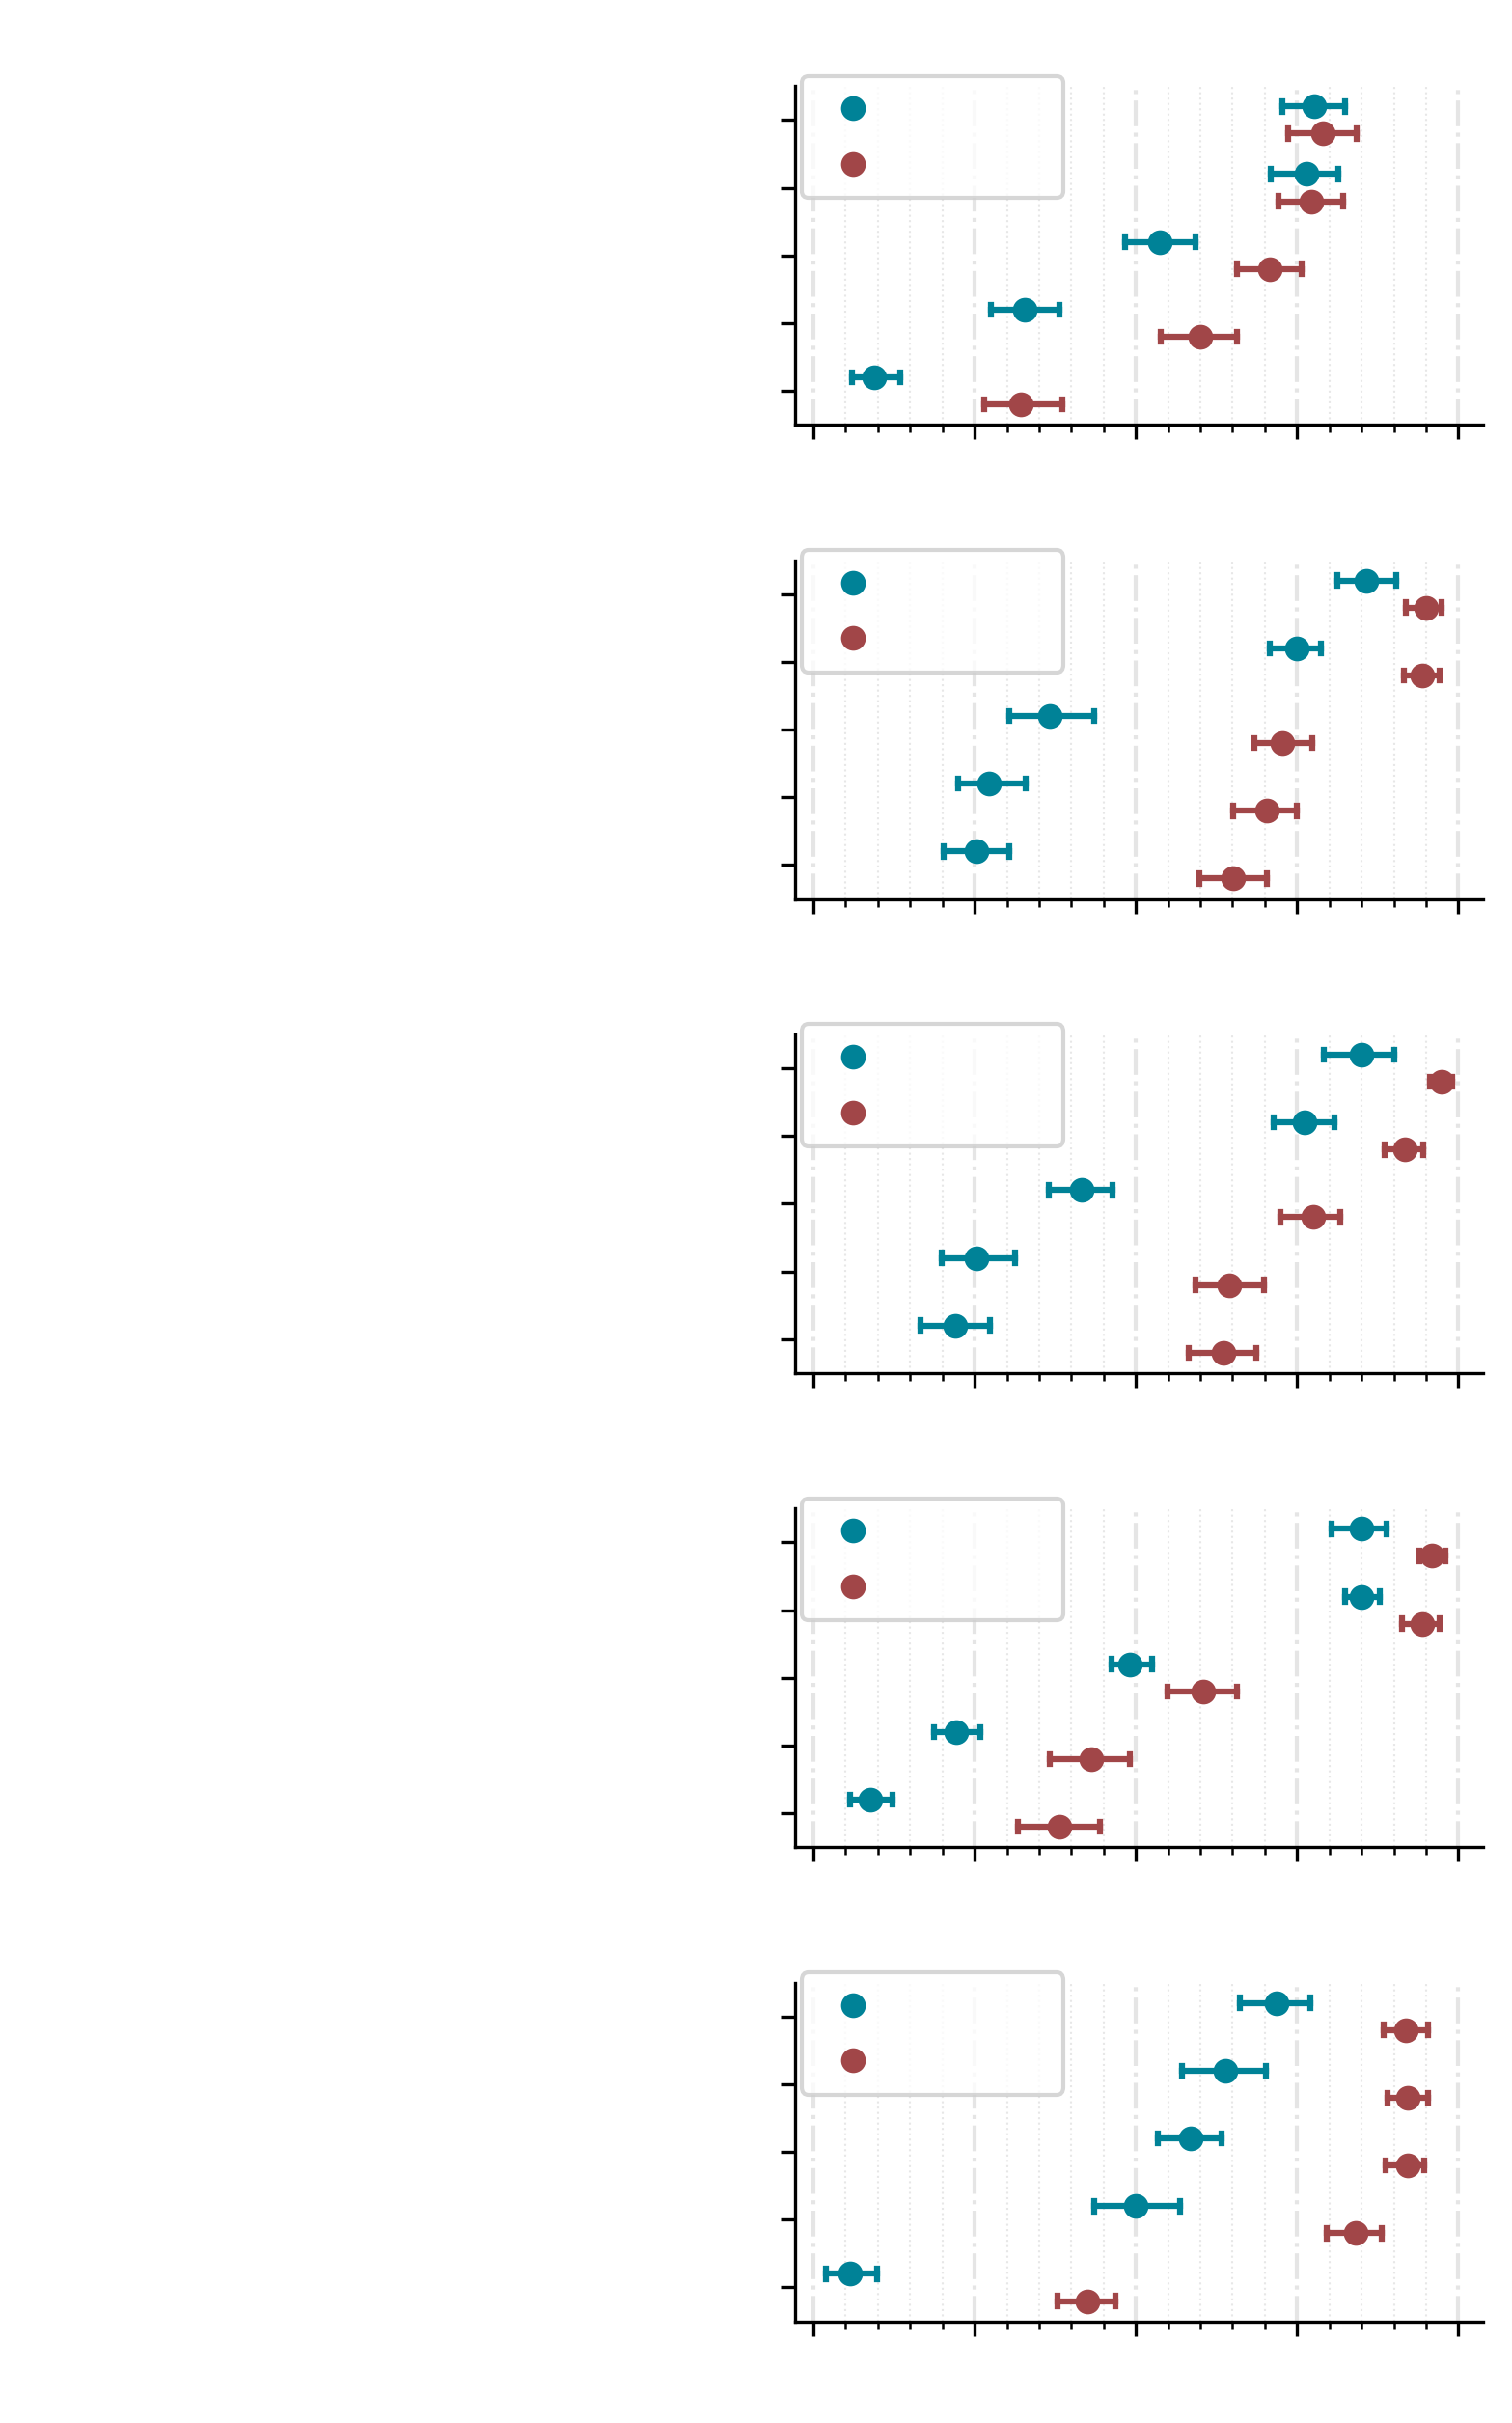

In [53]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

selected_topics = ['213', '223', '244', '259', '286']
# plt.style.use('ggplot')
# sns.catplot(data=comb_df, x='value', y='query', hue='method',kind='violin', col='topic', showmeans=True, bw=0.25, cut=0, scale='width', scale_hue=True,
#             col_wrap=2, height=7, aspect=1.7, sharey=False, dodge=0.3)
# _df = comb_df.loc[comb_df['topic'].isin({213, 286})]
# _df = comb_df.loc[comb_df['topic'].isin({213, 253})]

_df = comb_df.loc[comb_df['topic'].isin(selected_topics)]
# _df = comb_df
# g = sns.catplot(data=_df, x='value', y='query', hue='method', kind='point', col='topic', estimator=np.median,
#                 hue_order=['Ranking', 'Rating'], scale=0.5, errwidth=1.5, capsize=0.15, col_wrap=1,
#                 height=1.9, aspect=2.71, sharey=False, sharex=True, dodge=0.3, ci='sd', join=False, n_boot=1000,
#                 palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=False, margin_titles=False)

g = sns.catplot(data=_df, x='value', y='query', hue='method', kind='point', col='topic',
                hue_order=['Ranking', 'Rating'], scale=0.7, errwidth=1.5, capsize=0.15, col_wrap=1,
                height=1.7, aspect=3.15, sharey=False, sharex=True, dodge=0.4, errorbar=('ci', 95), join=False,
                n_boot=1000, col_order=selected_topics,
                palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=False, margin_titles=False,
                legend_out=False)

for ax in g.axes.flat:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True)

for ax in g.axes.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_xlabel("User's mean")


g.map(plt.grid, visible=True, which='major', axis='x', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='x', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.9,
      linewidth=0.5,
      ms=0)

for ax in g.axes.flat:
    ax.legend(loc='center', bbox_to_anchor=(0.2, 0.85))
    ax.set_title(None)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

# sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=2, frameon=False, title=None)

g.set_titles("Topic {col_name}")
plt.subplots_adjust(hspace=0.4)

# plt.tight_layout(h_pad=1.5)
plt.savefig('plots/selected_point_mean_ci.pdf', dpi=300, bbox_inches='tight')
plt.show()

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_8402/373302751.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=1.5)


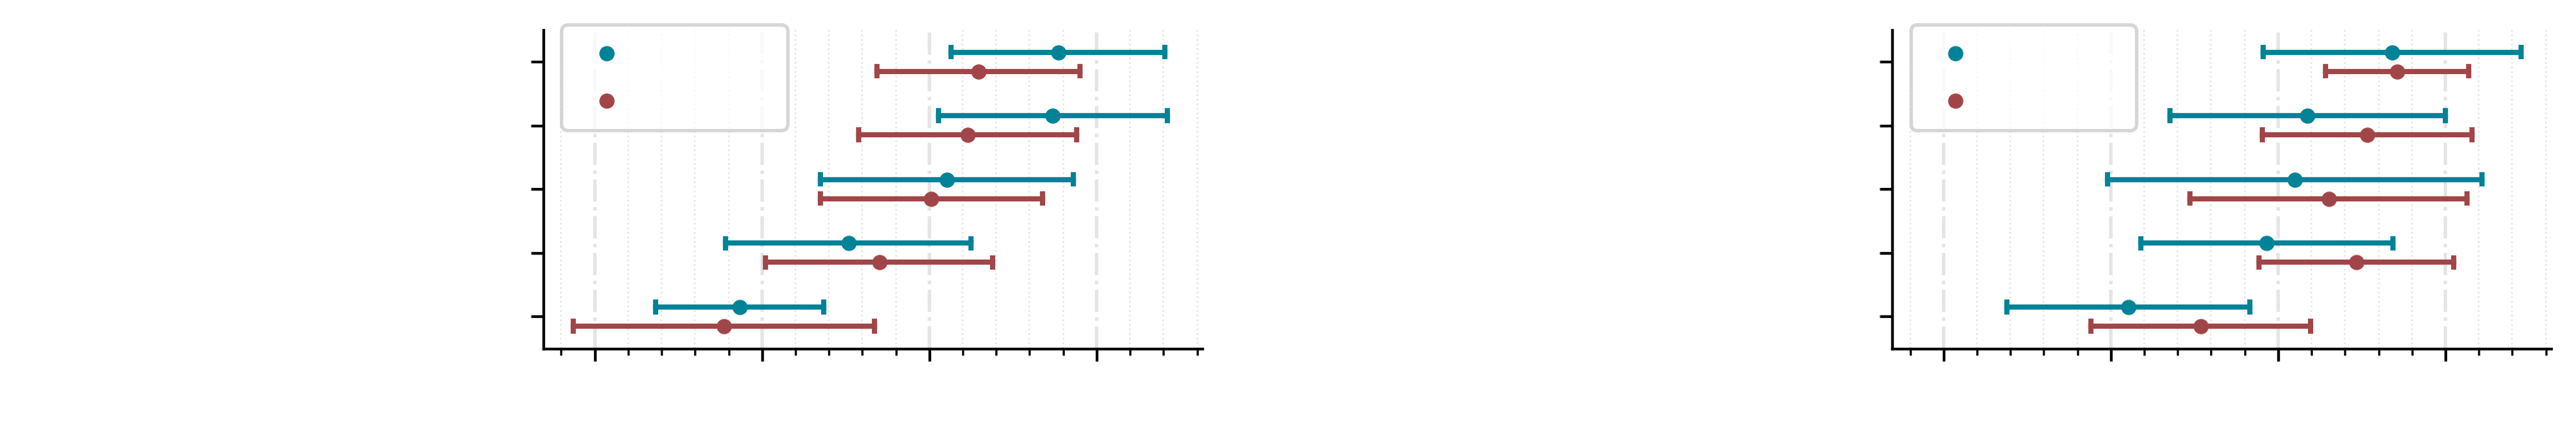

In [54]:
# plt.style.use('ggplot')
# sns.catplot(data=comb_df, x='value', y='query', hue='method',kind='violin', col='topic', showmeans=True, bw=0.25, cut=0, scale='width', scale_hue=True,
#             col_wrap=2, height=7, aspect=1.7, sharey=False, dodge=0.3)
# _df = comb_df.loc[comb_df['topic'].isin({213, 286})]
# _df = comb_df.loc[comb_df['topic'].isin({213, 253})]
_df = comb_df.loc[comb_df['topic'].isin({'213', '297'})]
# _df = comb_df
# g = sns.catplot(data=_df, x='value', y='query', hue='method', kind='point', col='topic', estimator=np.median,
#                 hue_order=['Ranking', 'Rating'], scale=0.5, errwidth=1.5, capsize=0.15, col_wrap=1,
#                 height=1.9, aspect=2.71, sharey=False, sharex=True, dodge=0.3, ci='sd', join=False, n_boot=1000,
#                 palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=False, margin_titles=False)

g = sns.catplot(data=_df, x='norm_value', y='query', hue='method', kind='point', col='topic',
                hue_order=['Ranking', 'Rating'], scale=0.5, errwidth=1.5, capsize=0.15, col_wrap=2,
                height=1.9, aspect=2.75, sharey=False, sharex=True, dodge=0.3, errorbar='sd', join=False, n_boot=1000,
                palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=False, margin_titles=False,
                legend_out=False)

for ax in g.axes.flat:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True)

for ax in g.axes.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_xlabel("User's mean")


g.map(plt.grid, visible=True, which='major', axis='x', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='x', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.9,
      linewidth=0.5,
      ms=0)

for ax in g.axes.flat:
    ax.legend(loc='center', bbox_to_anchor=(0.2, 0.85))
    ax.set_title(None)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

# g.set_titles("Topic {col_name} User's Mean")
# plt.subplots_adjust(hspace=1)

plt.tight_layout(h_pad=1.5)
plt.savefig('plots/selected_point_norm_mean_ci.pdf')
plt.show()

In [55]:
ranks_sr.corr(rates_sr, method='pearson')

0.8934654923356862

In [56]:
all_user_queries = pd.read_csv('data/user_queries/all_normalized_user_queries.csv', header=None,
                               names=['qid', 'user_query']).assign(
    topic=lambda x: x.qid.apply(lambda y: y.split('-')[0])).sort_values('qid')
all_user_queries = all_user_queries.assign(rid=all_user_queries.qid.str.rsplit('-', n=1).str[1])
all_user_queries = all_user_queries.assign(method=all_user_queries.qid.str.split('-').str[1].str.capitalize())
all_user_queries = all_user_queries.assign(topic=all_user_queries.qid.str.split('-').str[0])
# filter only the accepted queries
# all_user_queries = all_user_queries.loc[all_user_queries['rid'].isin(comb_df.index)]
all_user_queries['ref_qid'] = all_user_queries['user_query'].apply(lambda x: unique_user_queries.loc[x, 'qid'])
all_user_queries[f'user_nDCG@{k}'] = all_user_queries['ref_qid'].apply(lambda x: users_ndcg_df.loc[x, f'nDCG@{k}'])
all_user_queries.set_index(['method', 'topic', 'rid'])
all_user_queries

qid  \
175   213-ranking-11207122090   
129   213-ranking-12404386894   
7     213-ranking-12734195590   
8     213-ranking-13250011561   
137   213-ranking-14107062271   
...                       ...   
2057  297-rating-948095247335   
2183  297-rating-956482484331   
2175  297-rating-969223527633   
2121  297-rating-976189905893   
2135  297-rating-976386207551   

                                           user_query topic           rid  \
175                    what is carpal tunnel syndrome   213   11207122090   
129                            symptoms carpal tunnel   213   12404386894   
7                              carpal tunnel symptoms   213   12734195590   
8                              carpal tunnel symptoms   213   13250011561   
137                symptoms of carpal tunnel syndrome   213   14107062271   
...                                               ...   ...           ...   
2057                       altitude sickness remedies   297  948095247335   
2183  treatments for altitude sickness in mexico city   297  956482484331   
2175              treatments are high suffer sickness   297  969223527633   
2121                 how to prevent altitude sickness   297  976189905893   
2135         mexico city altitude sickness prevention   297  976386207551   

       method                  ref_qid  user_nDCG@10  
175   Ranking  213-ranking-11207122090      0.075295  
129   Ranking  213-ranking-12404386894      0.221163  
7     Ranking  213-ranking-12734195590      0.213350  
8     Ranking  213-ranking-12734195590      0.213350  
137   Ranking  213-ranking-14107062271      0.171151  
...       ...                      ...           ...  
2057   Rating  297-ranking-65842387797      0.358042  
2183   Rating  297-rating-956482484331      0.355933  
2175   Rating  297-rating-969223527633      0.042178  
2121   Rating  297-ranking-11299309425      0.332475  
2135   Rating  297-rating-976386207551      0.264538  

[2200 rows x 7 columns]

In [57]:
all_user_queries = pd.read_csv('data/user_queries/all_normalized_user_queries.csv', header=None,
                               names=['qid', 'user_query'], index_col=None).assign(
    topic=lambda x: x.qid.apply(lambda y: y.split('-')[0])).sort_values('qid').reset_index(drop=True)
all_user_queries = all_user_queries.assign(rid=all_user_queries.qid.str.rsplit('-', n=1).str[1])
all_user_queries = all_user_queries.assign(method=all_user_queries.qid.str.split('-').str[1].str.capitalize())
all_user_queries = all_user_queries.assign(topic=all_user_queries.qid.str.split('-').str[0])
all_user_queries

qid  \
0     213-ranking-11207122090   
1     213-ranking-12404386894   
2     213-ranking-12734195590   
3     213-ranking-13250011561   
4     213-ranking-14107062271   
...                       ...   
2195  297-rating-948095247335   
2196  297-rating-956482484331   
2197  297-rating-969223527633   
2198  297-rating-976189905893   
2199  297-rating-976386207551   

                                           user_query topic           rid  \
0                      what is carpal tunnel syndrome   213   11207122090   
1                              symptoms carpal tunnel   213   12404386894   
2                              carpal tunnel symptoms   213   12734195590   
3                              carpal tunnel symptoms   213   13250011561   
4                  symptoms of carpal tunnel syndrome   213   14107062271   
...                                               ...   ...           ...   
2195                       altitude sickness remedies   297  948095247335   
2196  treatments for altitude sickness in mexico city   297  956482484331   
2197              treatments are high suffer sickness   297  969223527633   
2198                 how to prevent altitude sickness   297  976189905893   
2199         mexico city altitude sickness prevention   297  976386207551   

       method  
0     Ranking  
1     Ranking  
2     Ranking  
3     Ranking  
4     Ranking  
...       ...  
2195   Rating  
2196   Rating  
2197   Rating  
2198   Rating  
2199   Rating  

[2200 rows x 5 columns]

In [58]:
# comb_df = comb_df.assign(qid=comb_df['query'].map(qdf.reset_index().set_index('query')['qid']))
# comb_df

# _df.groupby(['variable', 'Topic']).corr(method='spearman')['nDCG@10'].sort_values()


/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ranking reg:
 ['slope=0.083', 'intercept=-0.031', 'rvalue=0.5', 'pvalue=5e-05', 'stderr=0.019']
Rating reg:
 ['slope=0.091', 'intercept=-0.13', 'rvalue=0.49', 'pvalue=8.3e-05', 'stderr=0.022']


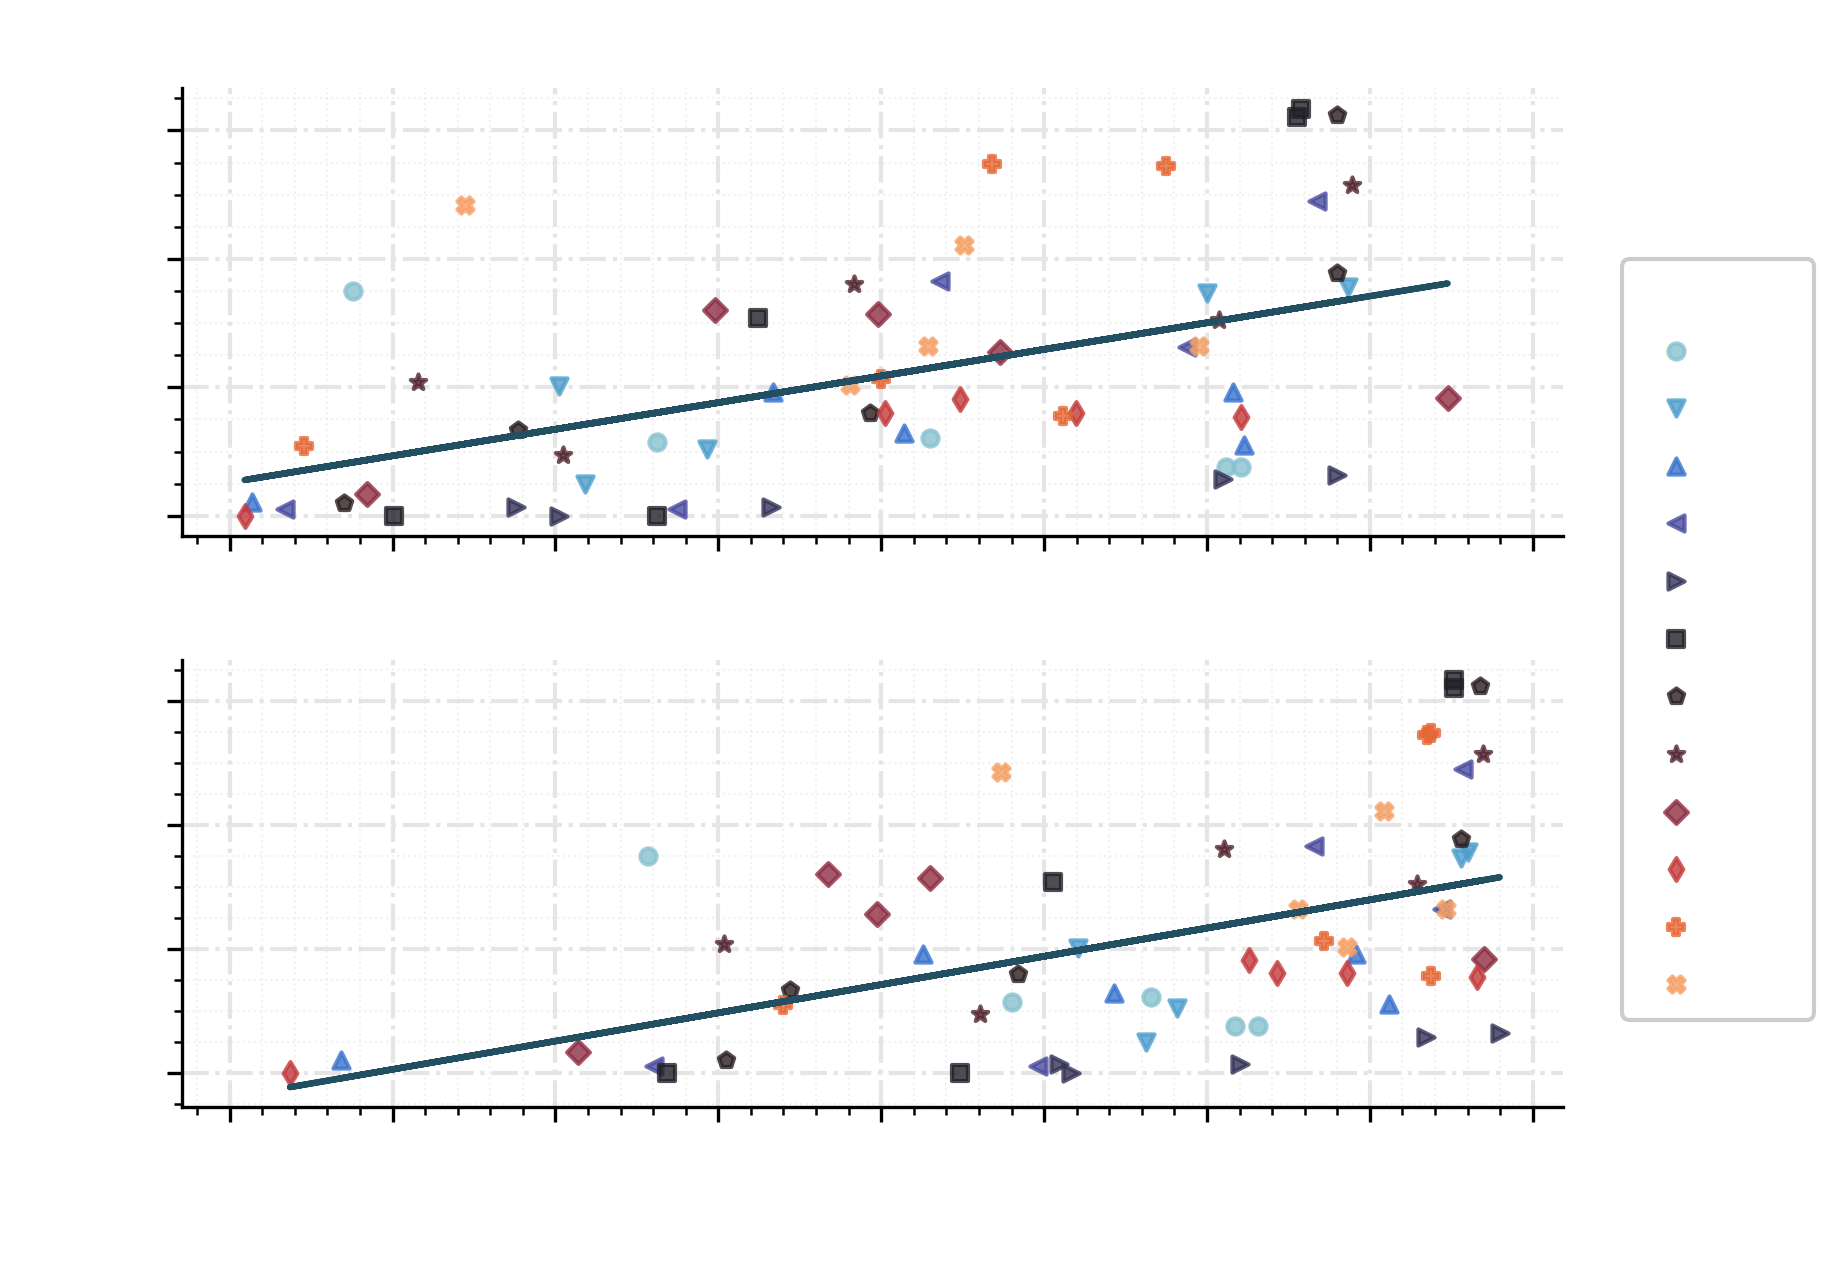

In [59]:
_df = qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Ranking', 'Rating'],
                        value_name="Users' mean").sort_values('Topic')  #.rename(columns={f'nDCG@{k}': f'NDCG@{k}'})
_rate_df = _df.loc[_df['variable'] == 'Rating']
_rank_df = _df.loc[_df['variable'] == 'Ranking']

x = "Users' mean"
y = f'nDCG@{k}'
markers = list(Line2D.filled_markers)
for m in {'8', 'h', 'H', '.'}:
    markers.remove(m)

plt.rcParams.update(thesis_fmt)
g = sns.lmplot(data=_df, y=y, x=x, hue='Topic', col='variable', height=2.2, aspect=2.5, ci=None, fit_reg=False,
               markers=markers, col_wrap=1, scatter_kws=dict(s=15), palette="icefire", facet_kws=dict(sharey=False),
               row_order=['Ranking', 'Rating'])

# sns.regplot(x=x, y=y, data=_df.loc[_df['variable'] == 'Ranking'], scatter=False, ax=g.axes[0, 1], ci=None, line_kws=dict(color='#224F62', lw=2))
_rank_reg_res = stats.linregress(_rank_df[x], _rank_df[y])
rank_label = f'$ \hat{{y}}={_rank_reg_res.intercept:.3f} + {_rank_reg_res.slope:.3f}x $'
# rank_label = f'r = {_rank_reg_res.rvalue:.2g}\np = {_rank_reg_res.pvalue:.1g}'
rank_line, = g.axes[0].plot(_rank_df[x], _rank_reg_res.intercept + _rank_reg_res.slope * _rank_df[x],
                            color='#224F62', label=rank_label)

# sns.regplot(x=x, y=y, data=_df.loc[_df['variable'] == 'Rating'], scatter=False, ax=g.axes[0, 0], ci=None, line_kws=dict(color='#224F62'))
_rate_reg_res = stats.linregress(_rate_df[x], _rate_df[y])
rate_label = f'$ \hat{{y}}={_rate_reg_res.intercept:.3f} + {_rate_reg_res.slope:.3f}x $'
# rate_label = f'r = {_rate_reg_res.rvalue:.2g}\np = {_rate_reg_res.pvalue:.1g}'
rate_line, = g.axes[1].plot(_rate_df[x], _rate_reg_res.intercept + _rate_reg_res.slope * _rate_df[x],
                            color='#224F62', label=rate_label)

# ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
for ax in g.axes.flat:
    ax.minorticks_on()

g.map(plt.grid, visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5,
      linewidth=0.5, ms=0)

# g.axes[0,0].legend(handles=[rate_line], loc='upper left')
# g.axes[0,1].legend(handles=[rank_line], loc='upper left')

g.axes[0].text(.038, 0.92, rank_label, transform=g.axes[0].transAxes, rotation=0, size='small')
g.axes[1].text(.038, 0.92, rate_label, transform=g.axes[1].transAxes, rotation=0, size='small')

for ax in g.axes.flat:
    ax.set_ylabel(y)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.3)

g.legend.set_frame_on(True)
frame = g.legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)

plt.savefig('plots/regplot_per_task.pdf', dpi=300, bbox_inches='tight')

print('Ranking reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rank_reg_res, _rank_reg_res._fields)])
print('Rating reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rate_reg_res, _rate_reg_res._fields)])

plt.show()

In [60]:
print(qdf_filtered.loc[(qdf_filtered['Rating'] >= 3.397) & (qdf_filtered['Rating'] <= 3.398)])
_df

Empty DataFrame
Columns: [query, nDCG@10, Topic, Rating, Ranking]
Index: []


nDCG@10 Topic variable  Users' mean
18  0.114385   213  Ranking     2.310345
78  0.114385   213   Rating     3.400000
77  0.075295   213   Rating     4.085714
76  0.349312   213   Rating     2.285714
19  0.121913   213  Ranking     3.149425
..       ...   ...      ...          ...
23  0.202916   297  Ranking     2.903614
22  0.421802   297  Ranking     3.253012
21  0.484505   297  Ranking     1.722892
20  0.264538   297  Ranking     3.975904
84  0.264538   297   Rating     4.278481

[120 rows x 4 columns]

In [61]:
# get coeffs of linear fit
_df = qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Rating', 'Ranking'],
                        value_name="User's mean").sort_values('Topic')

for df in [_rate_df, _rank_df]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
    print(slope)

0.091230115803566
0.08286514835628299


/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


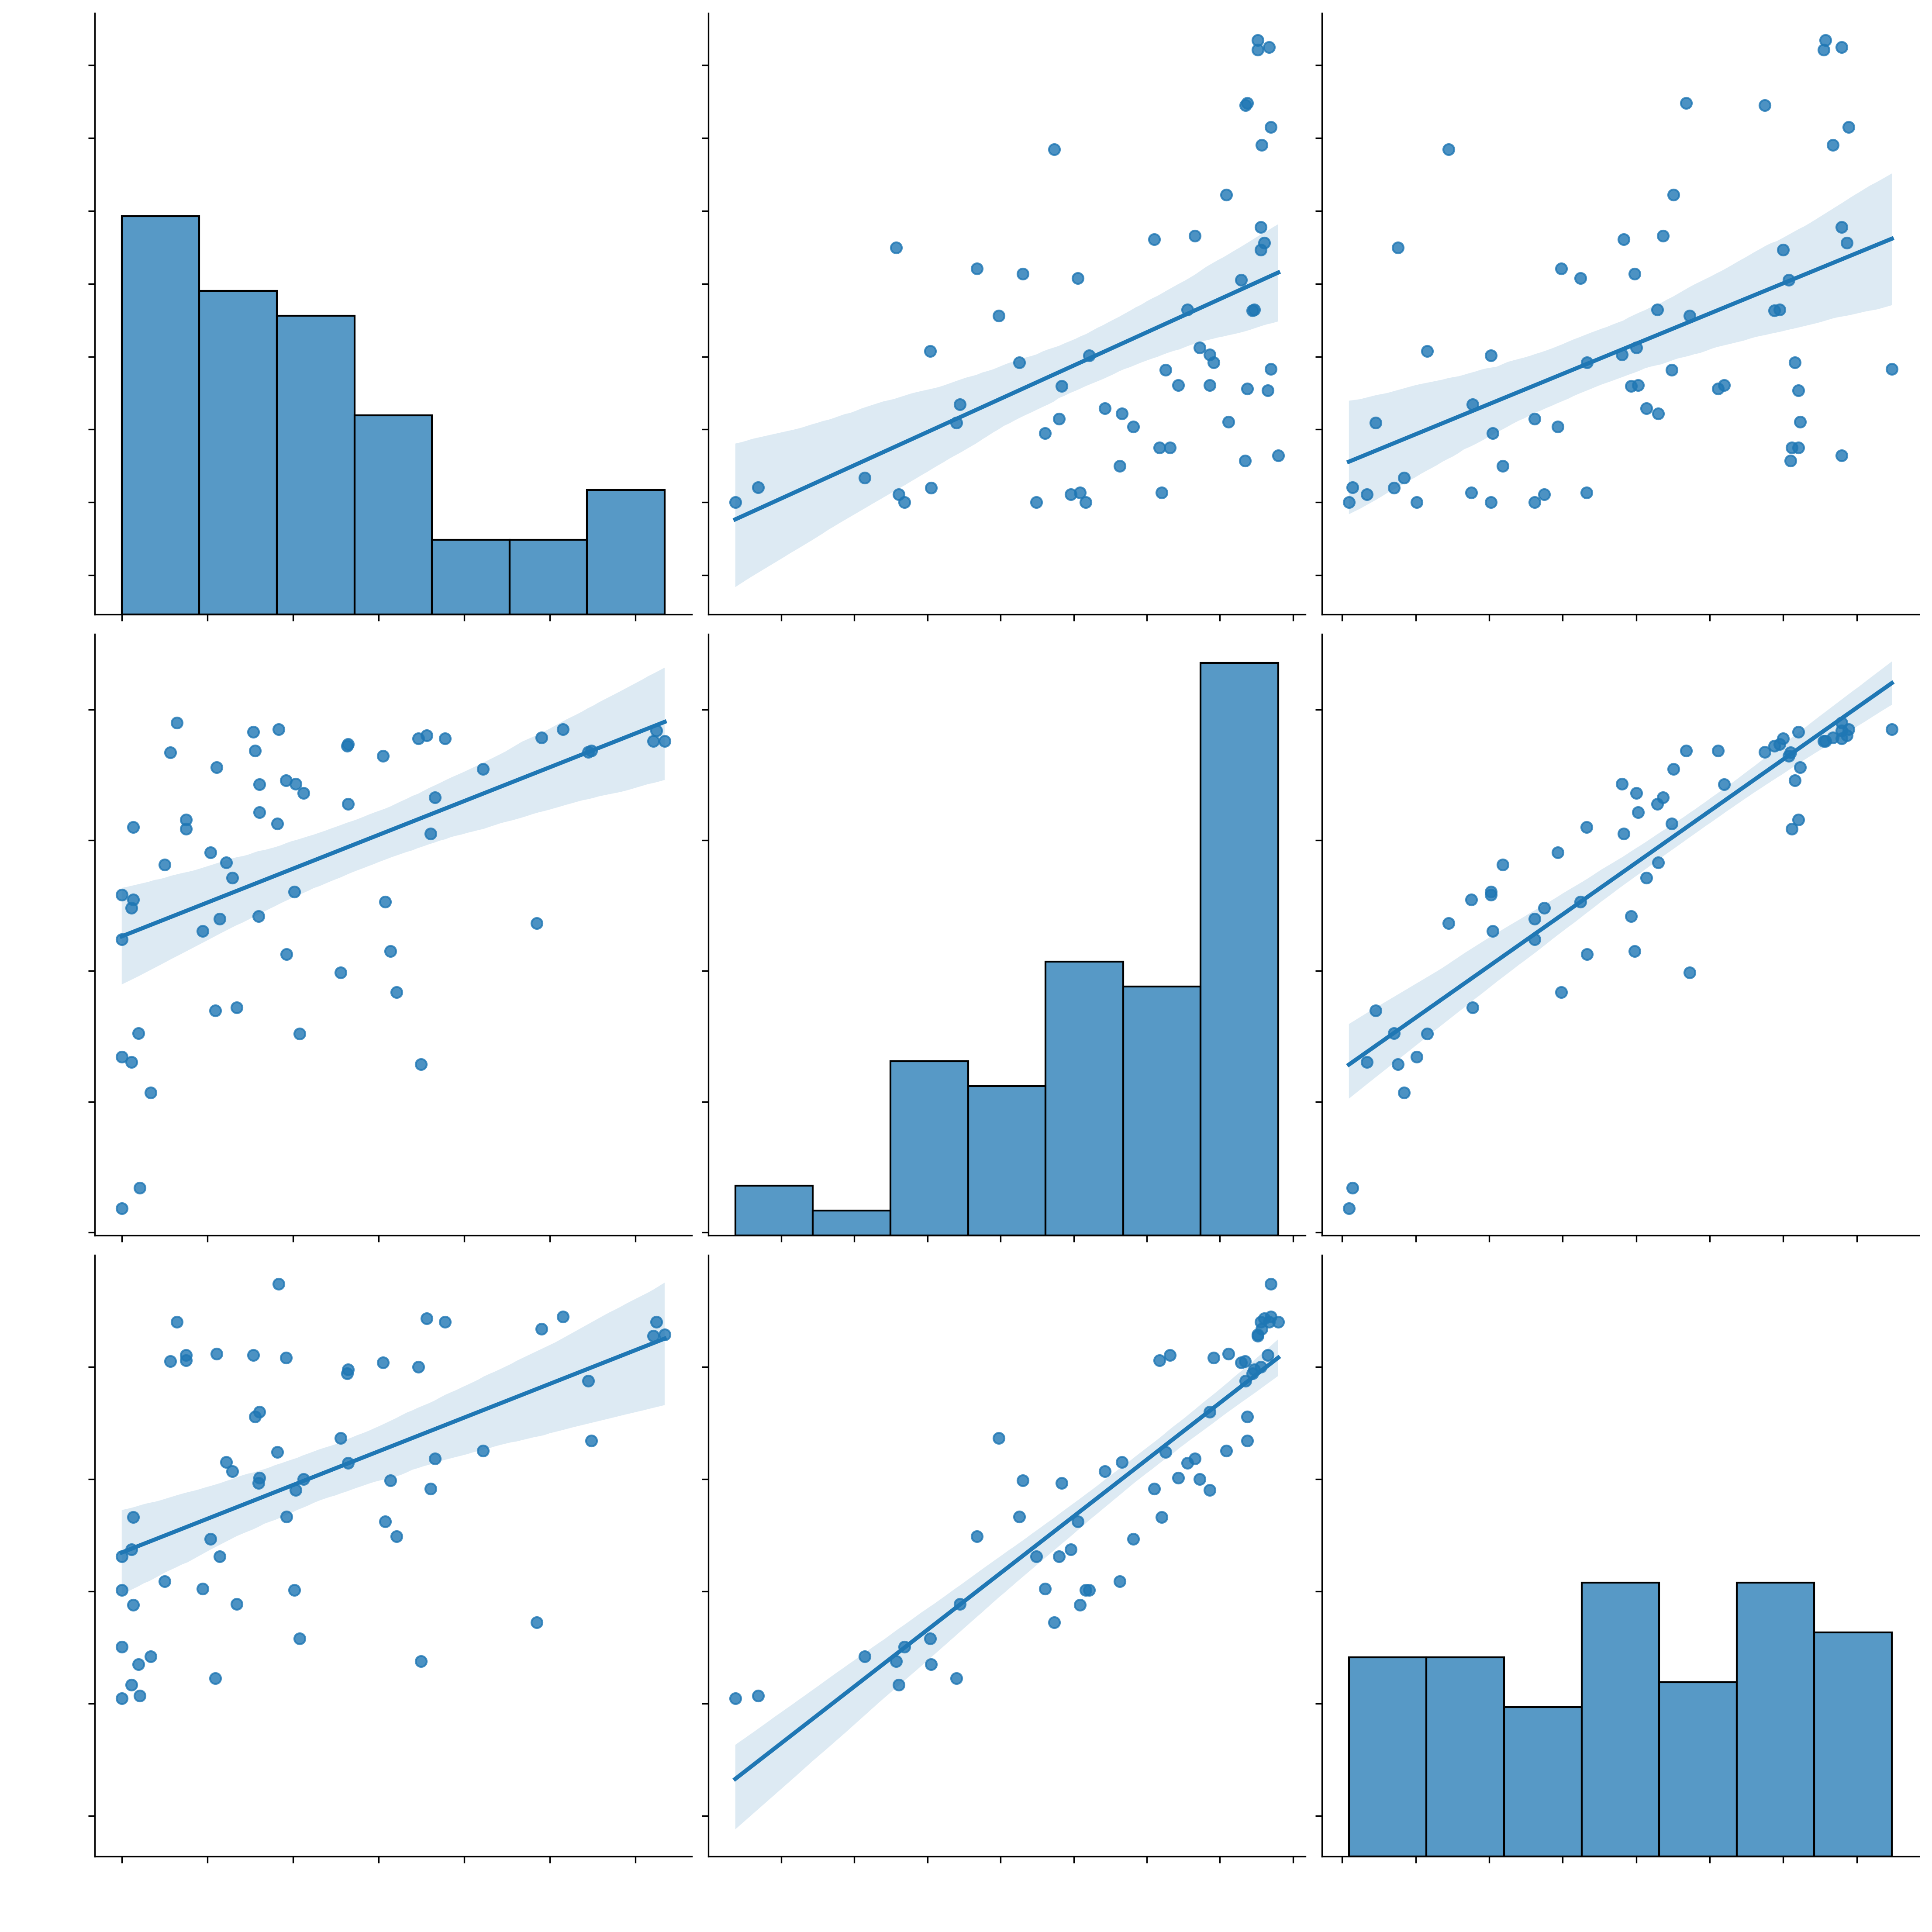

In [62]:
sns.pairplot(data=qdf_filtered.iloc[:, 1:], kind='reg', height=5)
plt.savefig('plots/pairsplot.pdf')

In [63]:
# qdf_filtered.assign(topic=qdf_filtered.index.map(comb_df['topic']))
qdf_filtered.head()


query   nDCG@10 Topic  \
qid                                                                         
261-2222                          sore throat home remedy  0.514984   261   
261-5906                                      sore throat  0.207764   261   
261-6263                           home care cough remedy  0.094559   261   
261-3964             what can i use to cure a sore throat  0.360681   261   
261-4857  what are some homemade remedy for a sore throat  0.305223   261   

            Rating   Ranking  
qid                           
261-2222  4.848101  4.445783  
261-5906  2.518987  1.578313  
261-6263  3.303797  2.024096  
261-3964  4.050633  2.915663  
261-4857  4.645570  4.036145

In [64]:
qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Rating', 'Ranking'], value_name="User's mean")

nDCG@10 Topic variable  User's mean
0    0.514984   261   Rating     4.848101
1    0.207764   261   Rating     2.518987
2    0.094559   261   Rating     3.303797
3    0.360681   261   Rating     4.050633
4    0.305223   261   Rating     4.645570
..        ...   ...      ...          ...
115  0.544897   286  Ranking     3.875000
116  0.212521   286  Ranking     3.000000
117  0.109451   286  Ranking     1.227273
118  0.155850   286  Ranking     3.556818
119  0.548159   286  Ranking     3.340909

[120 rows x 4 columns]

In [65]:
# all_user_queries.set_index(['method', 'topic', 'rid'])[[f'user_nDCG@{k}', 'user_query']].index

In [66]:
# _comb_df = comb_df.reset_index().set_index(['method', 'topic', 'rid']).merge(
#     all_user_queries.set_index(['method', 'topic', 'rid'])[[f'user_nDCG@{k}', 'user_query']], left_index=True,
#     right_index=True)
# _comb_df = _comb_df.reset_index()
# comb_df = _comb_df
# comb_df

In [67]:
# get maximal top ranked queries per user
selected_quereis = comb_df.reset_index().set_index('query').groupby(['method', 'topic', 'rid'])['value'].idxmax()
selected_quereis

method   topic  rid         
Ranking  213    12404386894               what is carpal tunnel syndrome
                12734195590               what is carpal tunnel syndrome
                13250011561                       carpal tunnel syndrome
                14107062271               what is carpal tunnel syndrome
                17248459875               what is carpal tunnel syndrome
                                                  ...                   
Rating   297    947212223056           how to overcome altitude sickness
                948095247335           how to overcome altitude sickness
                956482484331    mexico city altitude sickness prevention
                976189905893    mexico city altitude sickness prevention
                976386207551    mexico city altitude sickness prevention
Name: value, Length: 1972, dtype: object

In [68]:
# sns.regplot(data=df[['user_nDCG@10', 'selected_nDCG']], x='user_nDCG@10', y='selected_nDCG')
# _df = df

In [69]:
qpp_df = pd.read_csv('data/qpp_sd_top-50_survey.qpp', names=['qid', 'sd-60'], header=0, index_col='qid')
qpp_df.head()
qdf_filtered = qdf_filtered.assign(qpp=qpp_df)
qdf_filtered.head()

query   nDCG@10 Topic  \
qid                                                                         
261-2222                          sore throat home remedy  0.514984   261   
261-5906                                      sore throat  0.207764   261   
261-6263                           home care cough remedy  0.094559   261   
261-3964             what can i use to cure a sore throat  0.360681   261   
261-4857  what are some homemade remedy for a sore throat  0.305223   261   

            Rating   Ranking       qpp  
qid                                     
261-2222  4.848101  4.445783  2.251813  
261-5906  2.518987  1.578313  0.865915  
261-6263  3.303797  2.024096  1.282019  
261-3964  4.050633  2.915663  1.779842  
261-4857  4.645570  4.036145  1.702424

In [70]:
print('Pearson:')
print(qdf_filtered.corr(method='pearson', numeric_only=True).to_markdown(floatfmt='.2f'))
print('\nSpearman:')
print(qdf_filtered.corr(method='spearman', numeric_only=True).to_markdown(floatfmt='.2f'))
print('\nKendall:')
print(qdf_filtered.corr(method='kendall', numeric_only=True).to_markdown(floatfmt='.2f'))

Pearson:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.49 |      0.50 |  0.46 |
| Rating  |      0.49 |     1.00 |      0.89 |  0.57 |
| Ranking |      0.50 |     0.89 |      1.00 |  0.52 |
| qpp     |      0.46 |     0.57 |      0.52 |  1.00 |

Spearman:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.50 |      0.51 |  0.43 |
| Rating  |      0.50 |     1.00 |      0.91 |  0.58 |
| Ranking |      0.51 |     0.91 |      1.00 |  0.49 |
| qpp     |      0.43 |     0.58 |      0.49 |  1.00 |

Kendall:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.36 |      0.36 |  0.28 |
| Rating  |      0.36 |     1.00 |      0.75 |  0.40 |
| Ranking |      0.36 |     0.75 |      1.00 |  0.34 |
| qpp     |      0.28 |     0.40 | 

In [71]:
qdf_filtered.head()

query   nDCG@10 Topic  \
qid                                                                         
261-2222                          sore throat home remedy  0.514984   261   
261-5906                                      sore throat  0.207764   261   
261-6263                           home care cough remedy  0.094559   261   
261-3964             what can i use to cure a sore throat  0.360681   261   
261-4857  what are some homemade remedy for a sore throat  0.305223   261   

            Rating   Ranking       qpp  
qid                                     
261-2222  4.848101  4.445783  2.251813  
261-5906  2.518987  1.578313  0.865915  
261-6263  3.303797  2.024096  1.282019  
261-3964  4.050633  2.915663  1.779842  
261-4857  4.645570  4.036145  1.702424

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


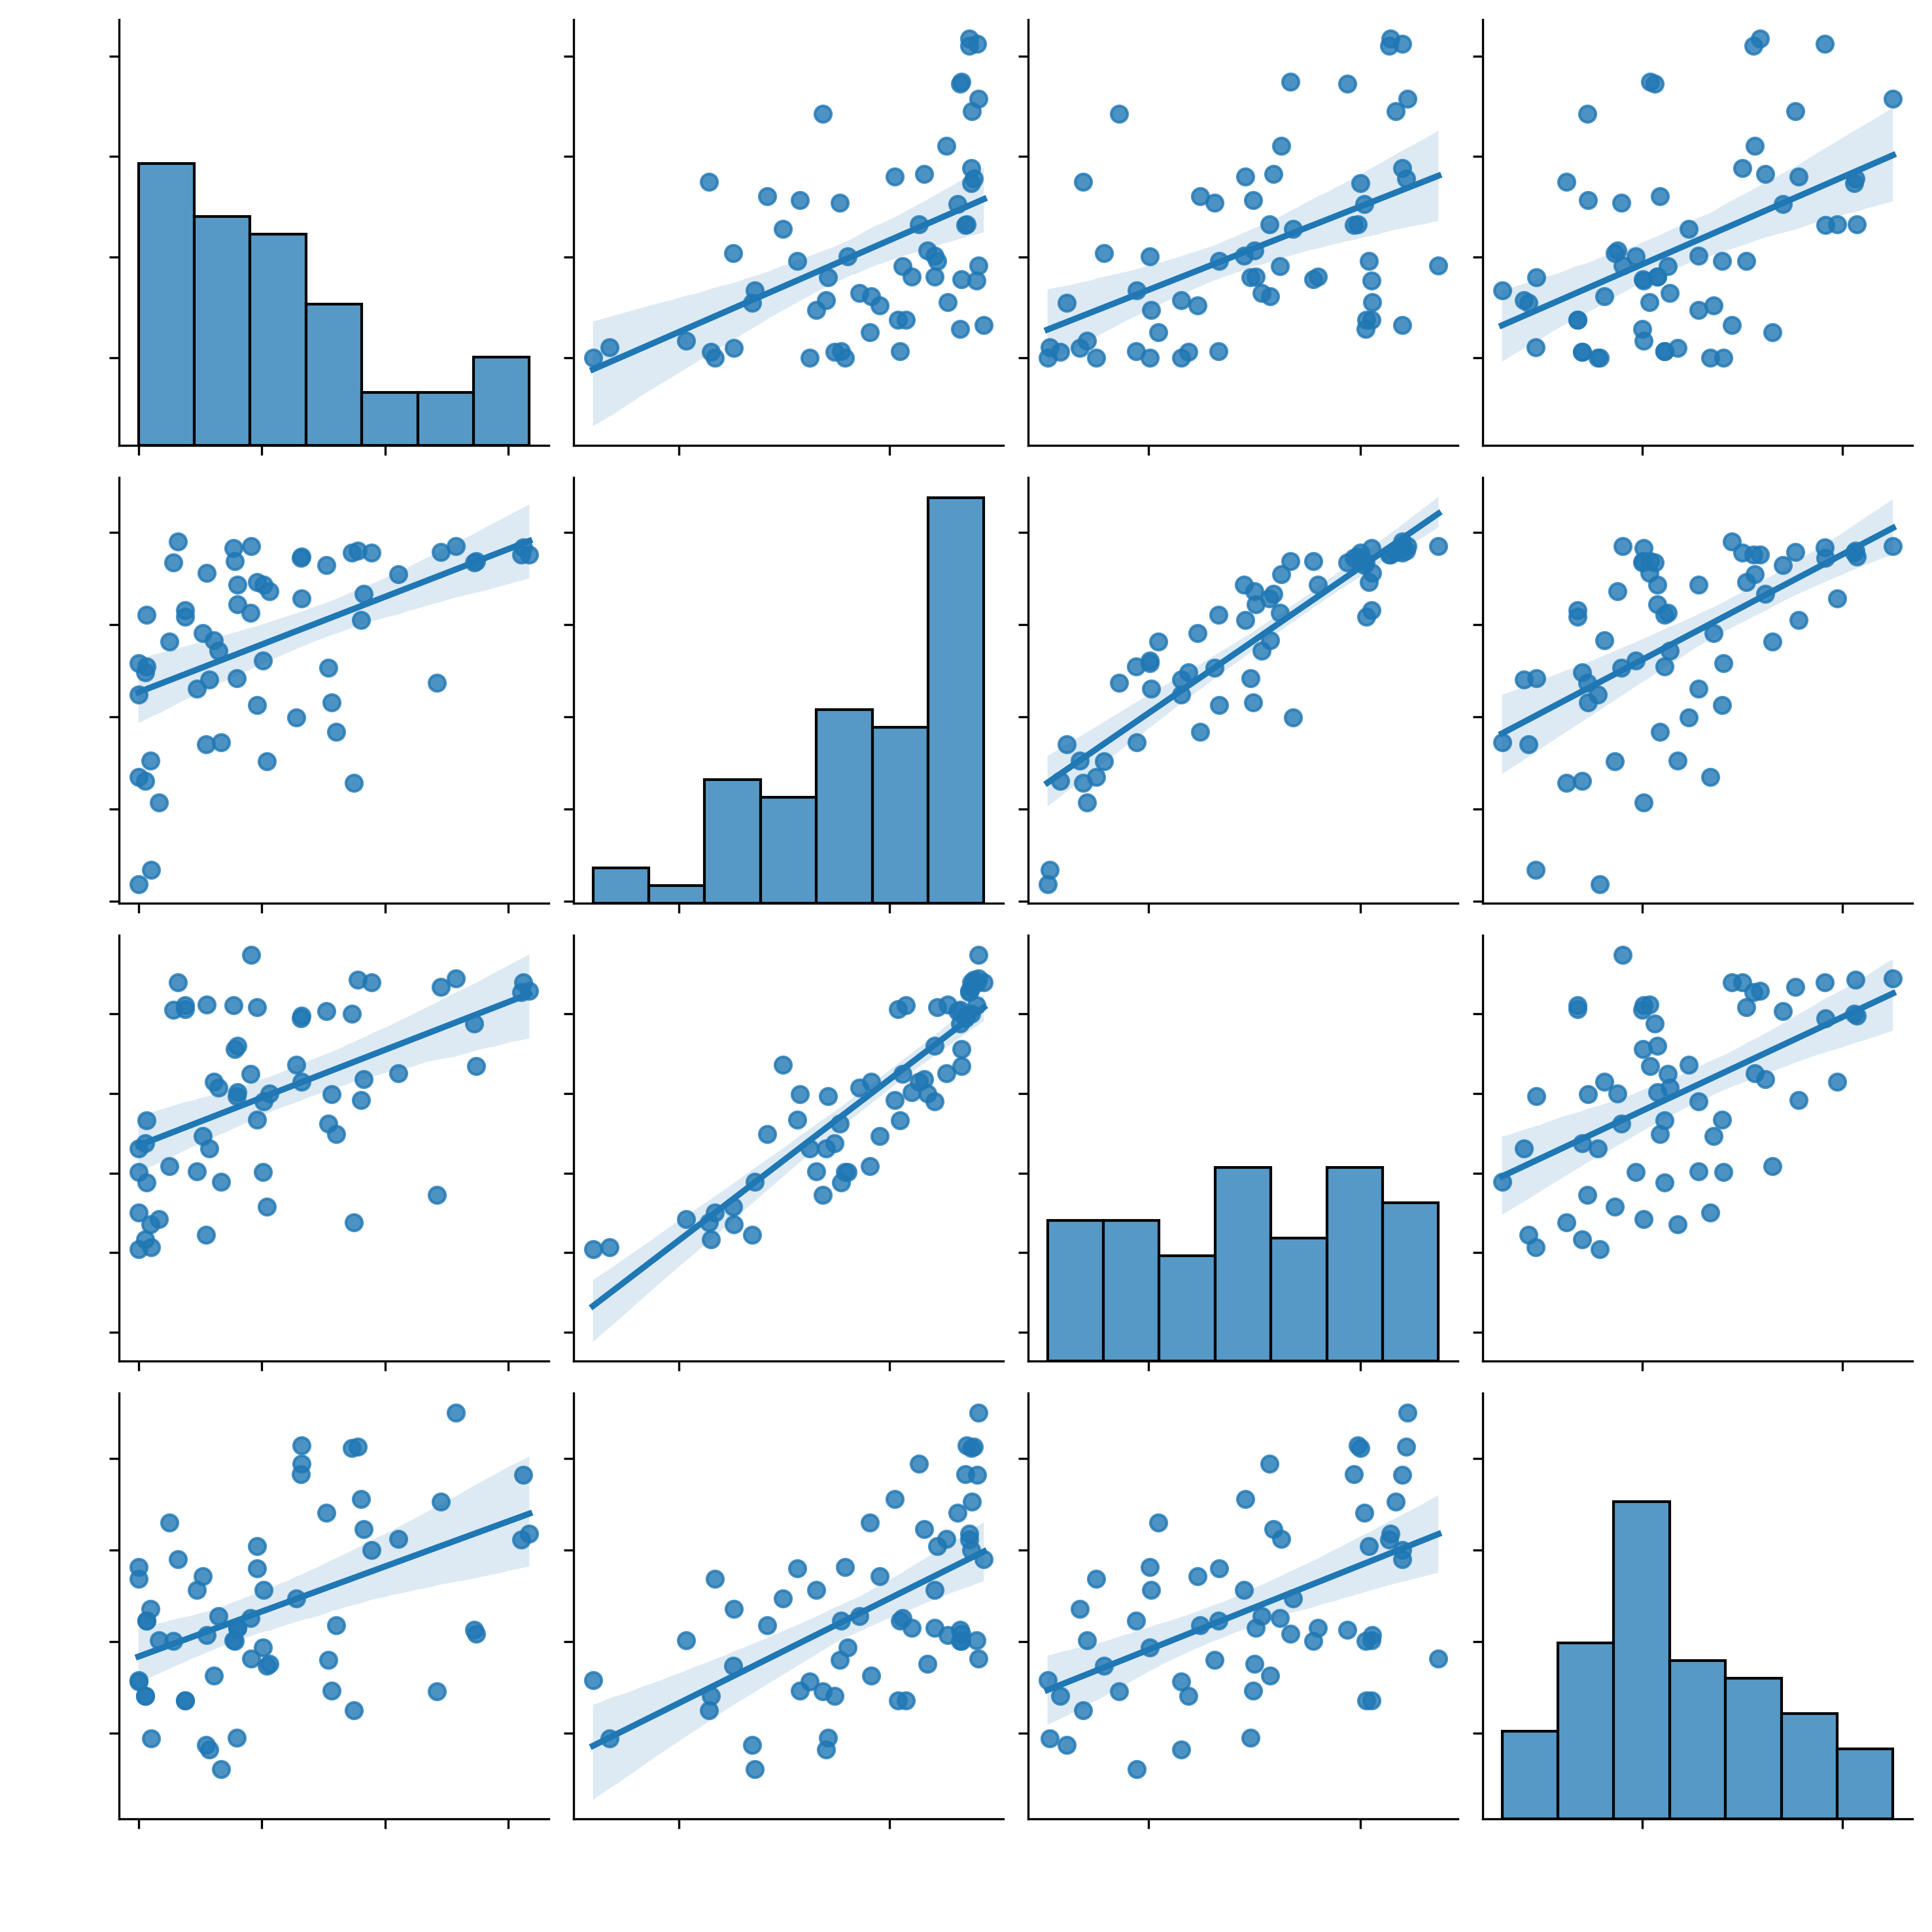

In [72]:
sns.pairplot(qdf_filtered[['nDCG@10', 'Rating', 'Ranking', 'qpp']], kind='reg')

# Post SIGIR submission

Text(0.5, 1.0, 'nDCG@10 per query')

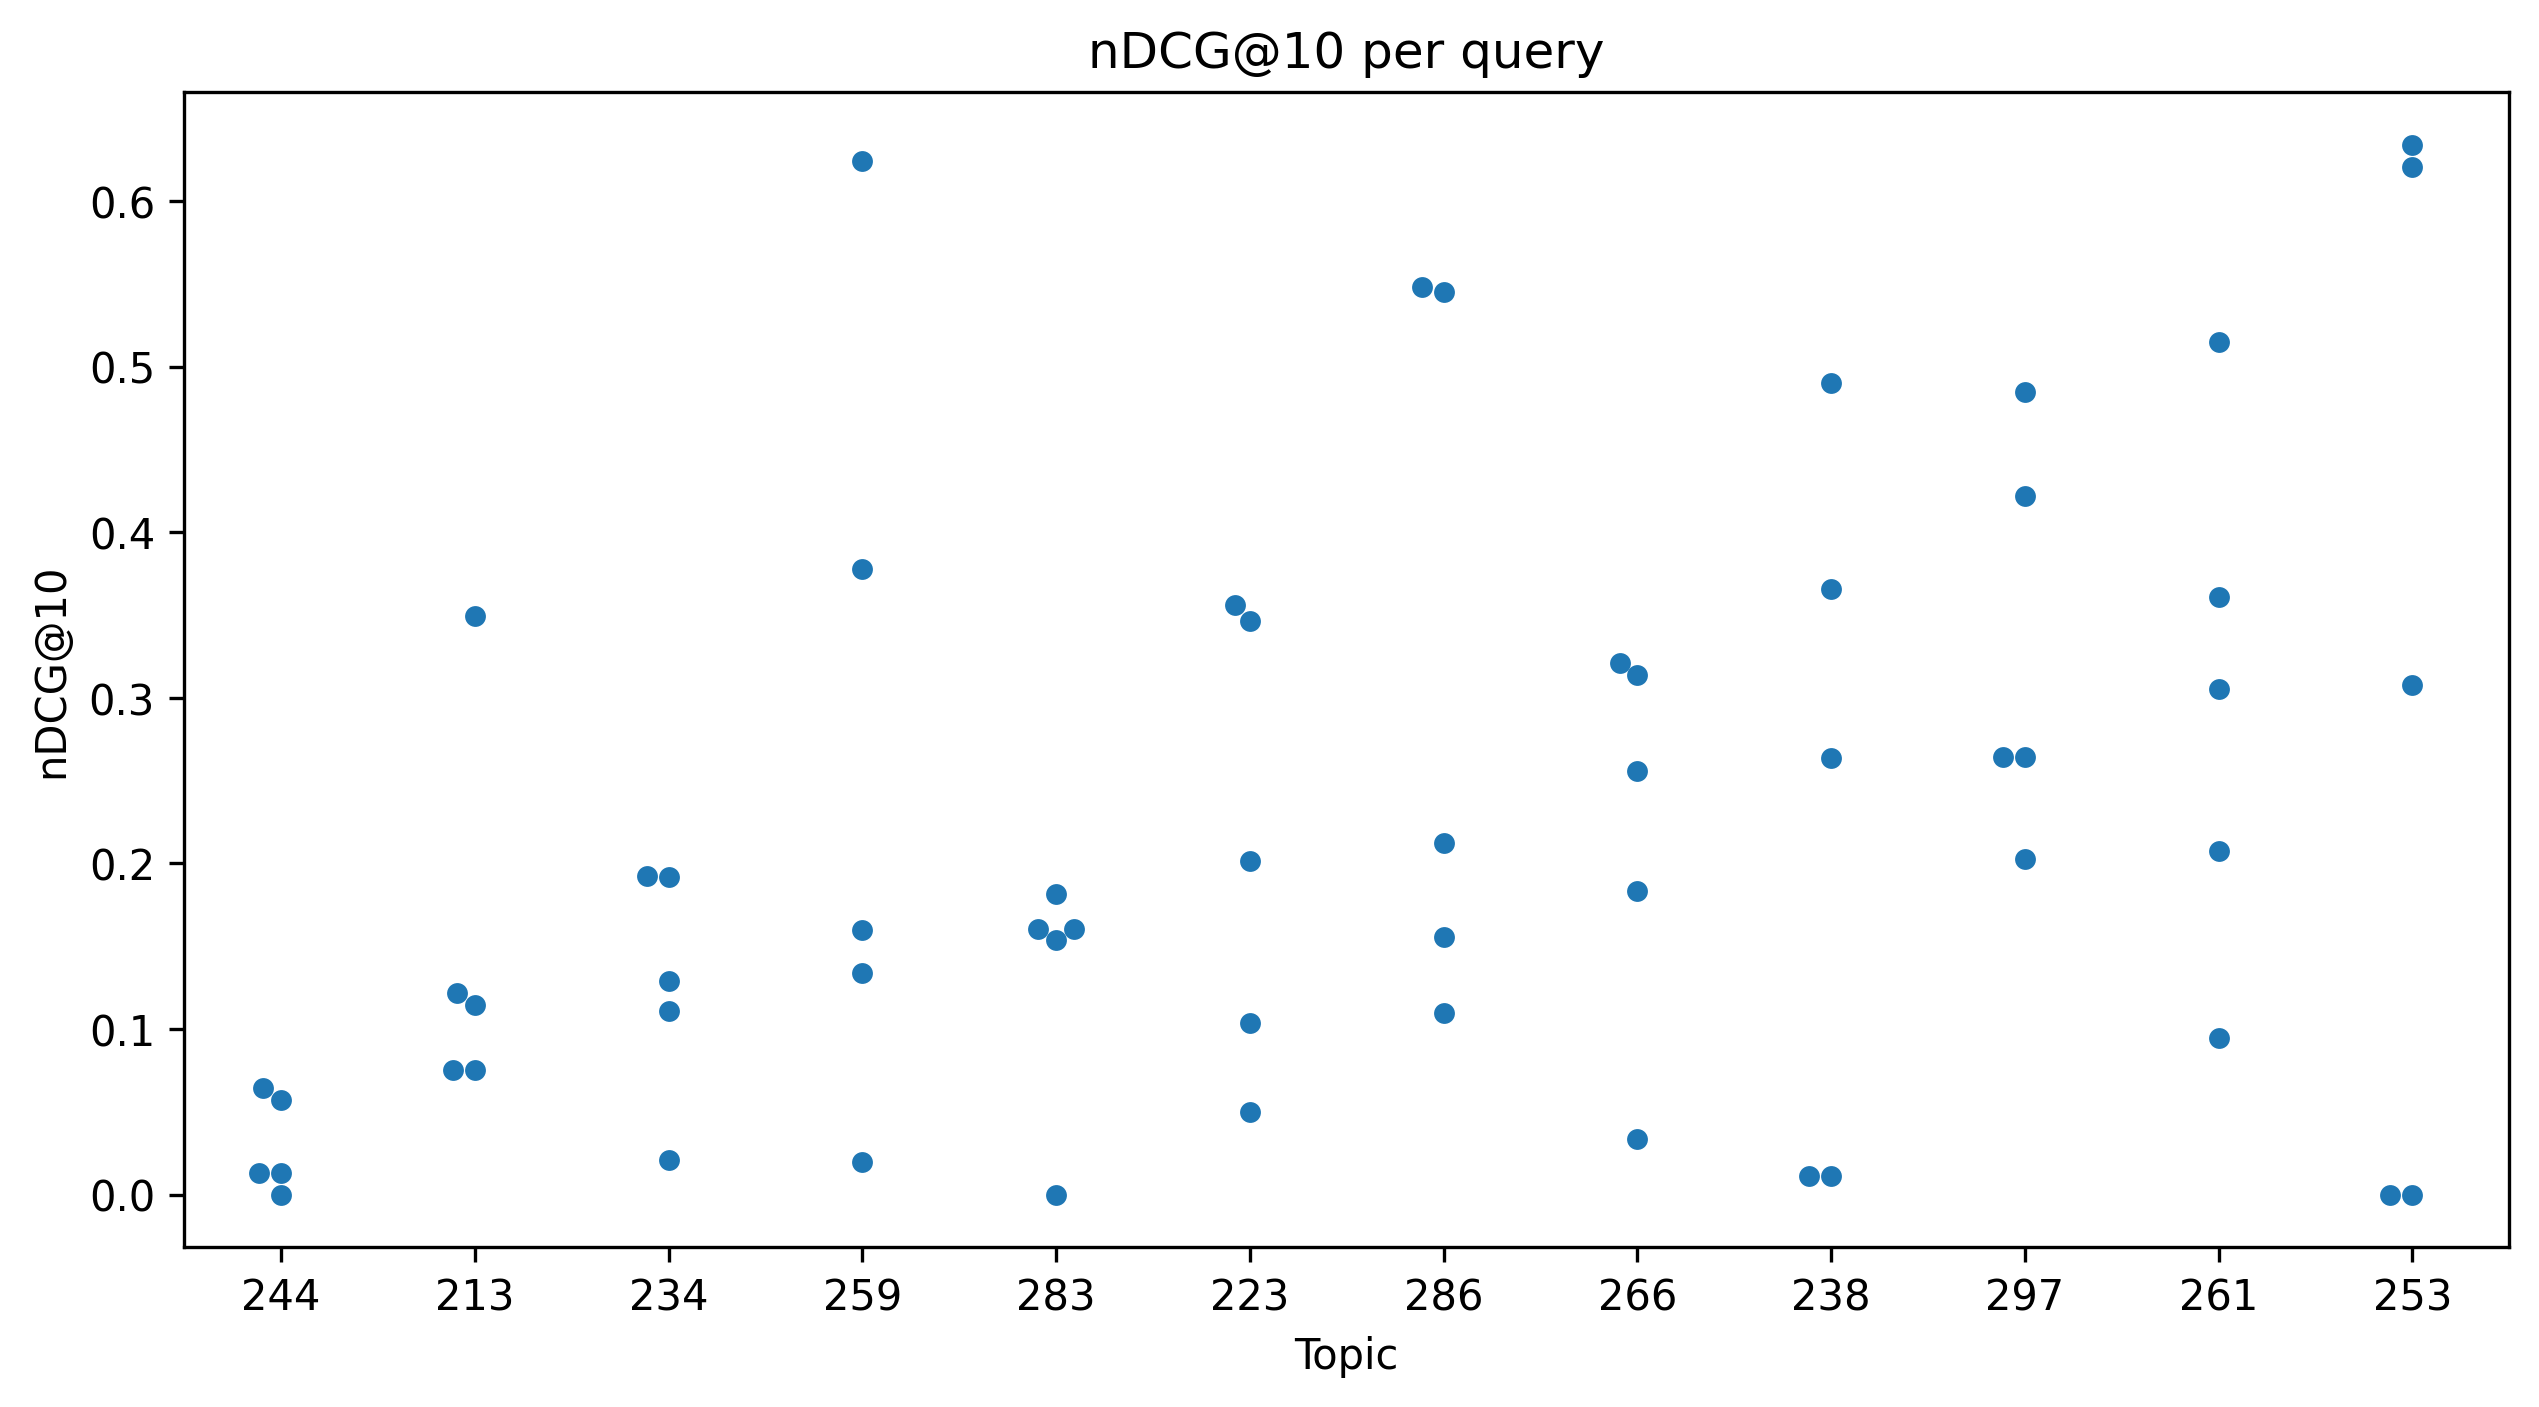

In [73]:
plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update(thesis_fmt)

order = qdf_filtered.groupby('Topic')['nDCG@10'].median().sort_values().index
plt.figure(figsize=(10, 5), dpi=300)
sns.swarmplot(data=qdf_filtered, x='Topic', y='nDCG@10', order=order)
# sns.catplot(data=qdf_filtered, x='Topic', y='Ranking', order=order)
plt.title('nDCG@10 per query')

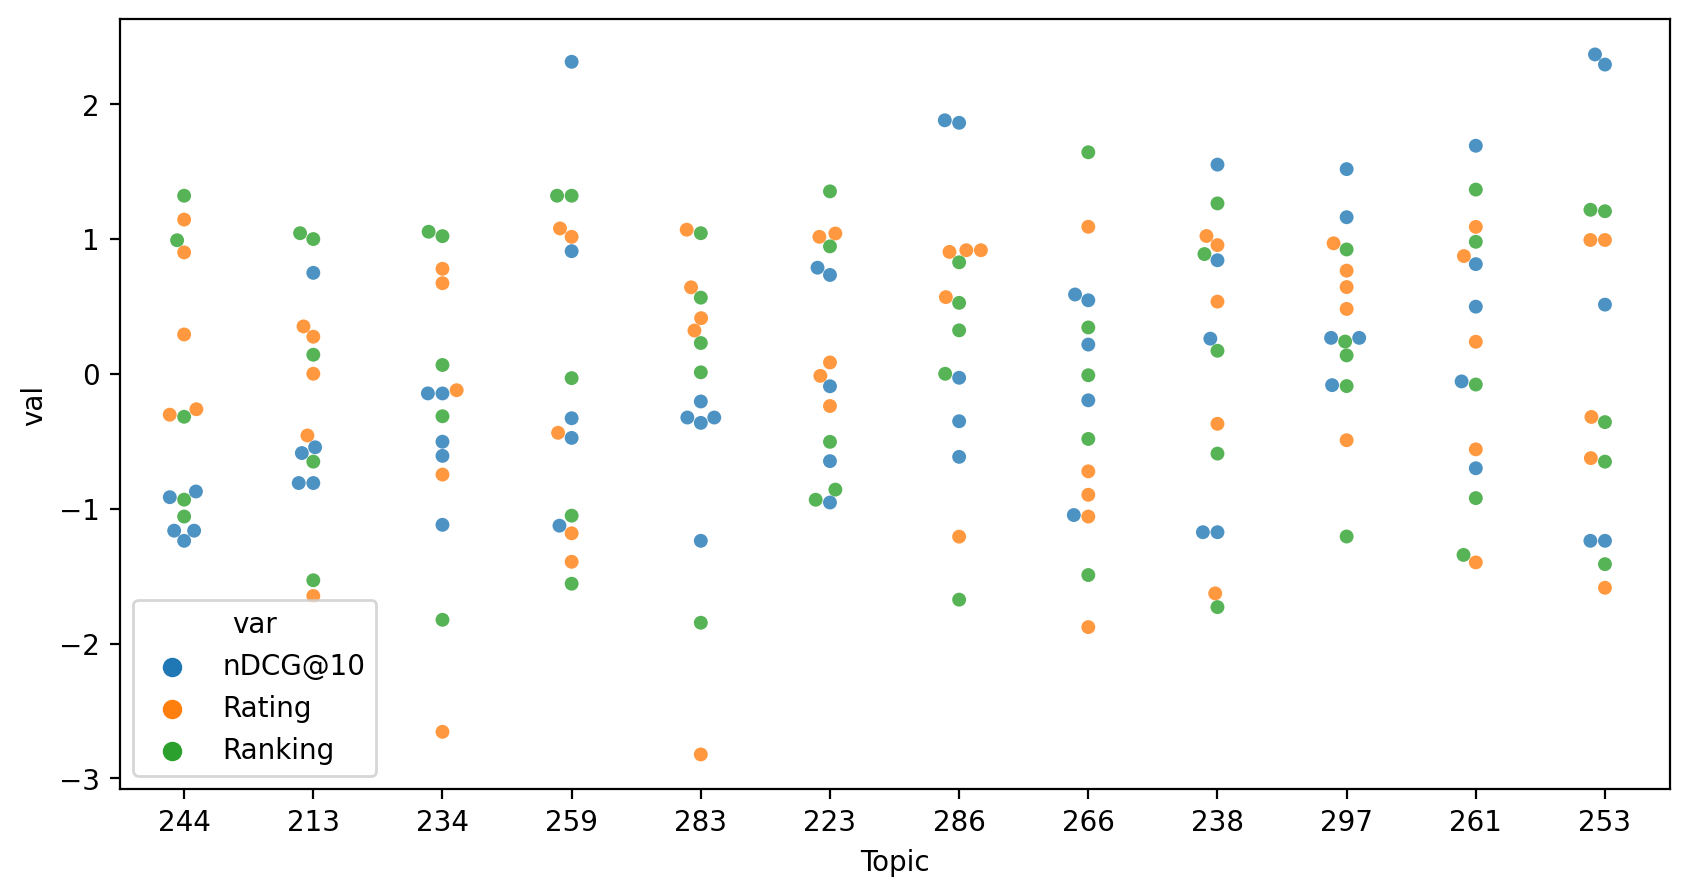

In [74]:

plt.figure(figsize=(10, 5), dpi=200)
scaler = MinMaxScaler()
df = qdf_filtered.set_index('Topic', append=True)[['nDCG@10', 'Rating', 'Ranking']]
# for col in df.columns:
#     df[col] = scale(df[col])
# df[df.columns] = robust_scale(df[df.columns])
df[df.columns] = scale(df[df.columns])
sns.swarmplot(data=df.stack().reset_index().rename(columns={'level_2': 'var', 0: 'val'}), x='Topic', y='val', hue='var',
              order=order, alpha=0.8)
plt.show()

In [75]:
user_qrs = comb_df.groupby(['wid', 'topic']).head(1)
user_qrs.loc[:, 'topic'] = user_qrs['topic'].astype(str)
order = user_qrs.groupby('topic')['user_nDCG@10'].mean().sort_values().index
user_qrs

method topic           rid                   query  value  \
0      Ranking   213   12404386894  carpal tunnel syndrome      4   
5      Ranking   213   12734195590  carpal tunnel syndrome      3   
10     Ranking   213   13250011561  carpal tunnel syndrome      5   
15     Ranking   213   14107062271  carpal tunnel syndrome      4   
20     Ranking   213   17248459875  carpal tunnel syndrome      3   
...        ...   ...           ...                     ...    ...   
10335   Rating   297  947212223056       altitude sickness      4   
10340   Rating   297  948095247335       altitude sickness      4   
10345   Rating   297  956482484331       altitude sickness      3   
10350   Rating   297  976189905893       altitude sickness      3   
10355   Rating   297  976386207551       altitude sickness      3   

                  wid batch  duration             EndDate  query_mean  \
0      A39MKVROUZ1UWR   red       204 2022-02-14 14:23:14    1.911111   
5      A1I0DV4B4MFQCL   red       286 2022-02-14 13:59:06    1.911111   
10     A23BWWRR7J5XLS   red       197 2022-02-13 13:04:05    1.911111   
15     A1CB72B51L7TKE   red       211 2022-02-14 14:42:31    1.911111   
20     A12R2U6TBB3OOG   red       299 2022-02-10 01:36:09    1.911111   
...               ...   ...       ...                 ...         ...   
10335  A1JO6AY55FG7QU  blue       224 2022-02-14 12:17:19    3.297619   
10340  A13XMRE3EKZ715  blue       211 2022-02-14 11:53:58    3.297619   
10345  A3V2XCDF45VN9X  blue       241 2022-02-14 12:25:33    3.297619   
10350  A21HYG0E8SK3ZZ  blue       206 2022-02-14 11:59:29    3.297619   
10355  A1YH2I4Y2SYAXJ  blue       328 2022-02-14 11:50:36    3.297619   

       batch_order       qid  user_nDCG@10  \
0                2  213-2264      0.221163   
5                1  213-2264      0.213350   
10               3  213-2264      0.213350   
15               1  213-2264      0.171151   
20               3  213-2264      0.213350   
...            ...       ...           ...   
10335            1  297-3878      0.392754   
10340            1  297-3878      0.358042   
10345            1  297-3878      0.355933   
10350            1  297-3878      0.332475   
10355            3  297-3878      0.264538   

                                            user_query topic_class  \
0                               symptoms carpal tunnel  Understand   
5                               carpal tunnel symptoms  Understand   
10                              carpal tunnel symptoms  Understand   
15                  symptoms of carpal tunnel syndrome  Understand   
20                              carpal tunnel symptoms  Understand   
...                                                ...         ...   
10335                      altitude sickness treatment  Understand   
10340                       altitude sickness remedies  Understand   
10345  treatments for altitude sickness in mexico city  Understand   
10350                 how to prevent altitude sickness  Understand   
10355         mexico city altitude sickness prevention  Understand   

       norm_value  normalized_value  
0        0.701189               4.0  
5        0.000000               3.0  
10       1.402379               5.0  
15       0.701189               4.0  
20       0.000000               3.0  
...           ...               ...  
10335    0.116100               1.5  
10340   -0.103316               2.0  
10345   -0.363104               2.0  
10350   -0.938148               1.0  
10355   -0.374802               1.5  

[1972 rows x 17 columns]

## Testing equivalence between users' queries Rank vs Rate

In [76]:
x = comb_df.loc[comb_df['method'] == 'Ranking'].sort_values(['qid', 'user_nDCG@10'])['user_nDCG@10']
y = comb_df.loc[comb_df['method'] == 'Rating'].sort_values(['qid', 'user_nDCG@10'])['user_nDCG@10']

print(f'{x.mean():.3g}')
print(f'{y.mean():.3g}')
weightstats.ttost_ind(x, y, -0.05, 0.05)

0.294
0.296


(4.822404973705453e-42,
 (13.599038827666977, 4.822404973705453e-42, 9858.0),
 (-15.001823942945341, 1.2800639087965525e-50, 9858.0))

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_8402/850073807.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


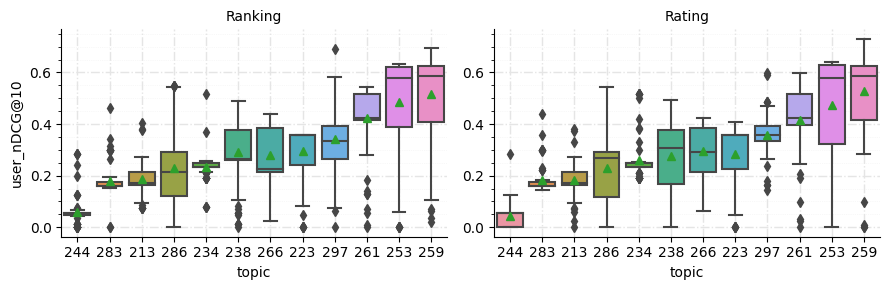

In [77]:
# plt.figure(figsize=(10,5), dpi=300)
g = sns.catplot(data=user_qrs, x='topic', y='user_nDCG@10', kind='box', order=order, showmeans=True, col='method',
                height=3, aspect=1.5, zorder=5, boxprops={'zorder': 5})

# for ax in g.axes.flat:
#     ax.minorticks_on()
#     ax.tick_params(axis='x', which='minor', bottom=False)
#     ax.tick_params(axis='y', which='minor', left=True)
#     ax.tick_params(axis='y', which='major', left=True, labelleft=True)


# g.map(plt.grid, visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=1, ms=0)
# g.map(plt.grid, visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5, ms=0)

for ax in g.axes.flat:
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='minor', left=True, zorder=0)
    ax.tick_params(axis='y', which='major', left=True, labelleft=True, zorder=0)

    ax.grid(visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=0, linewidth=1, ms=0)
    ax.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5,
            ms=0)
#     for l in ax.lines + ax.collections:
#         l.set_zorder(6)


g.set_titles("{col_name}")
plt.tight_layout()

plt.show()

## Distribution of all user submitted queries per topic

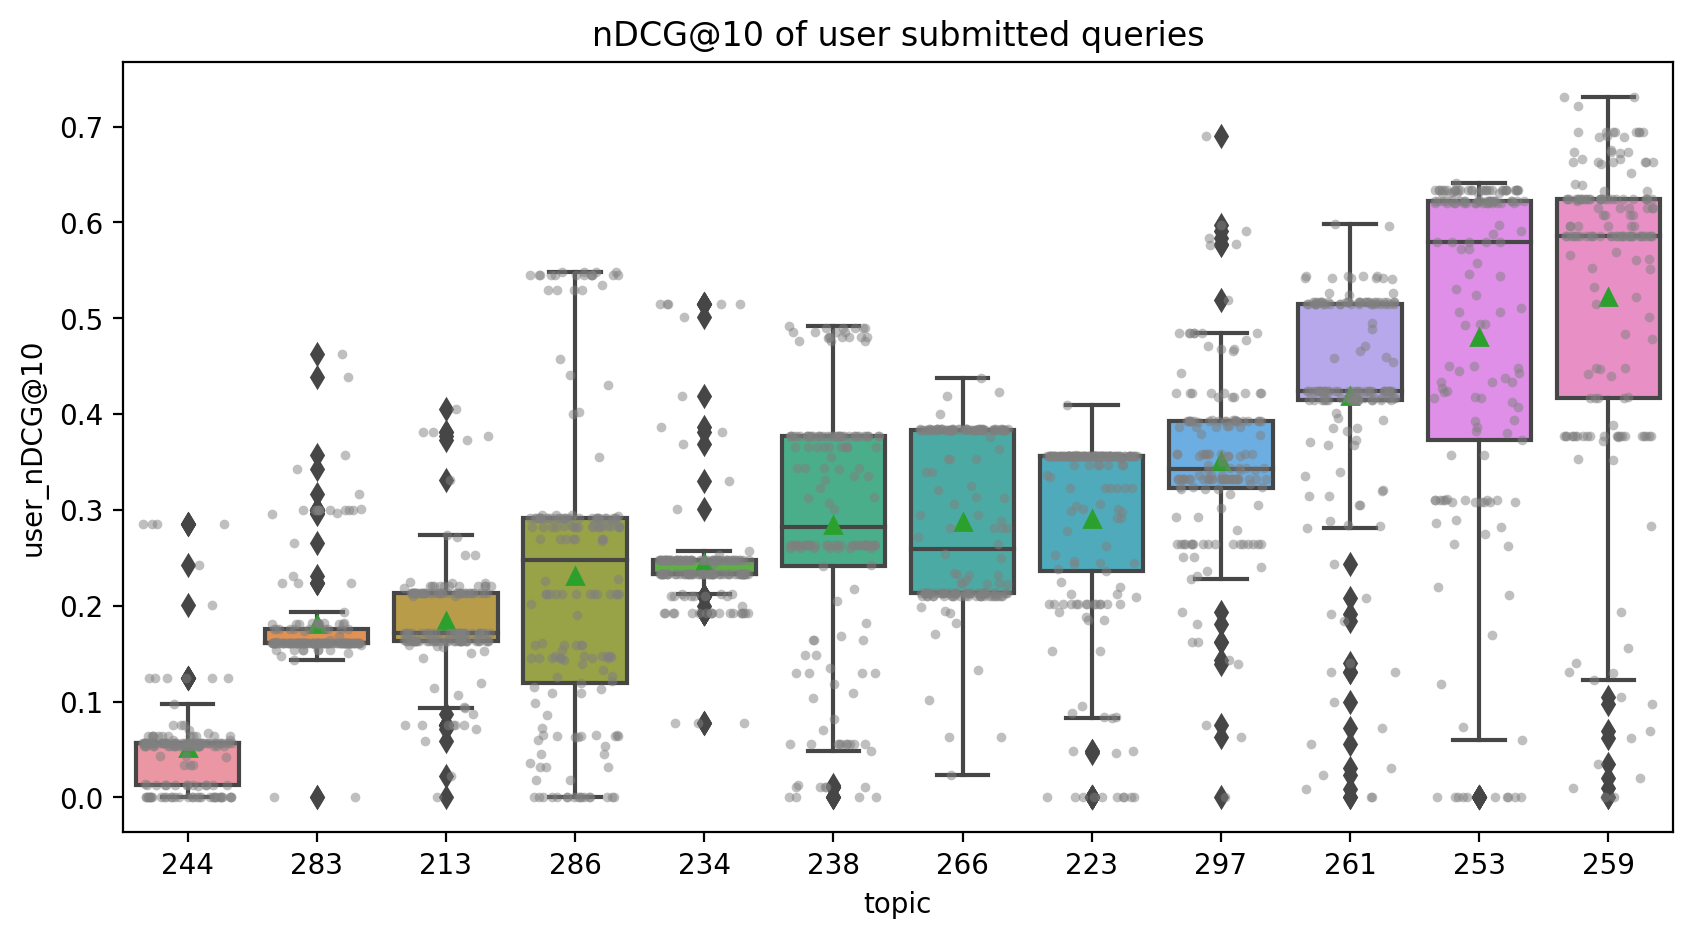

In [78]:
plt.figure(figsize=(10, 5), dpi=200)
sns.boxplot(data=user_qrs, x='topic', y='user_nDCG@10', order=order, showmeans=True)
sns.stripplot(data=user_qrs, x='topic', y='user_nDCG@10', order=order, size=3.5, jitter=0.35, alpha=0.5, color='.5',
              linewidth=0)
plt.title('nDCG@10 of user submitted queries')

plt.show()

## Comparison of user submitted queries with survey queries
1. We can observe the effects of topic difficulties.
    * e.g. 244 is a hard topic, whereas, 261 is an easy topic.
2. Generally each topic had relatively good and bad queries in the survey.
    * topic 234 (health benefits of dark chocolate) is an outlier in that regard
    223 topic usda

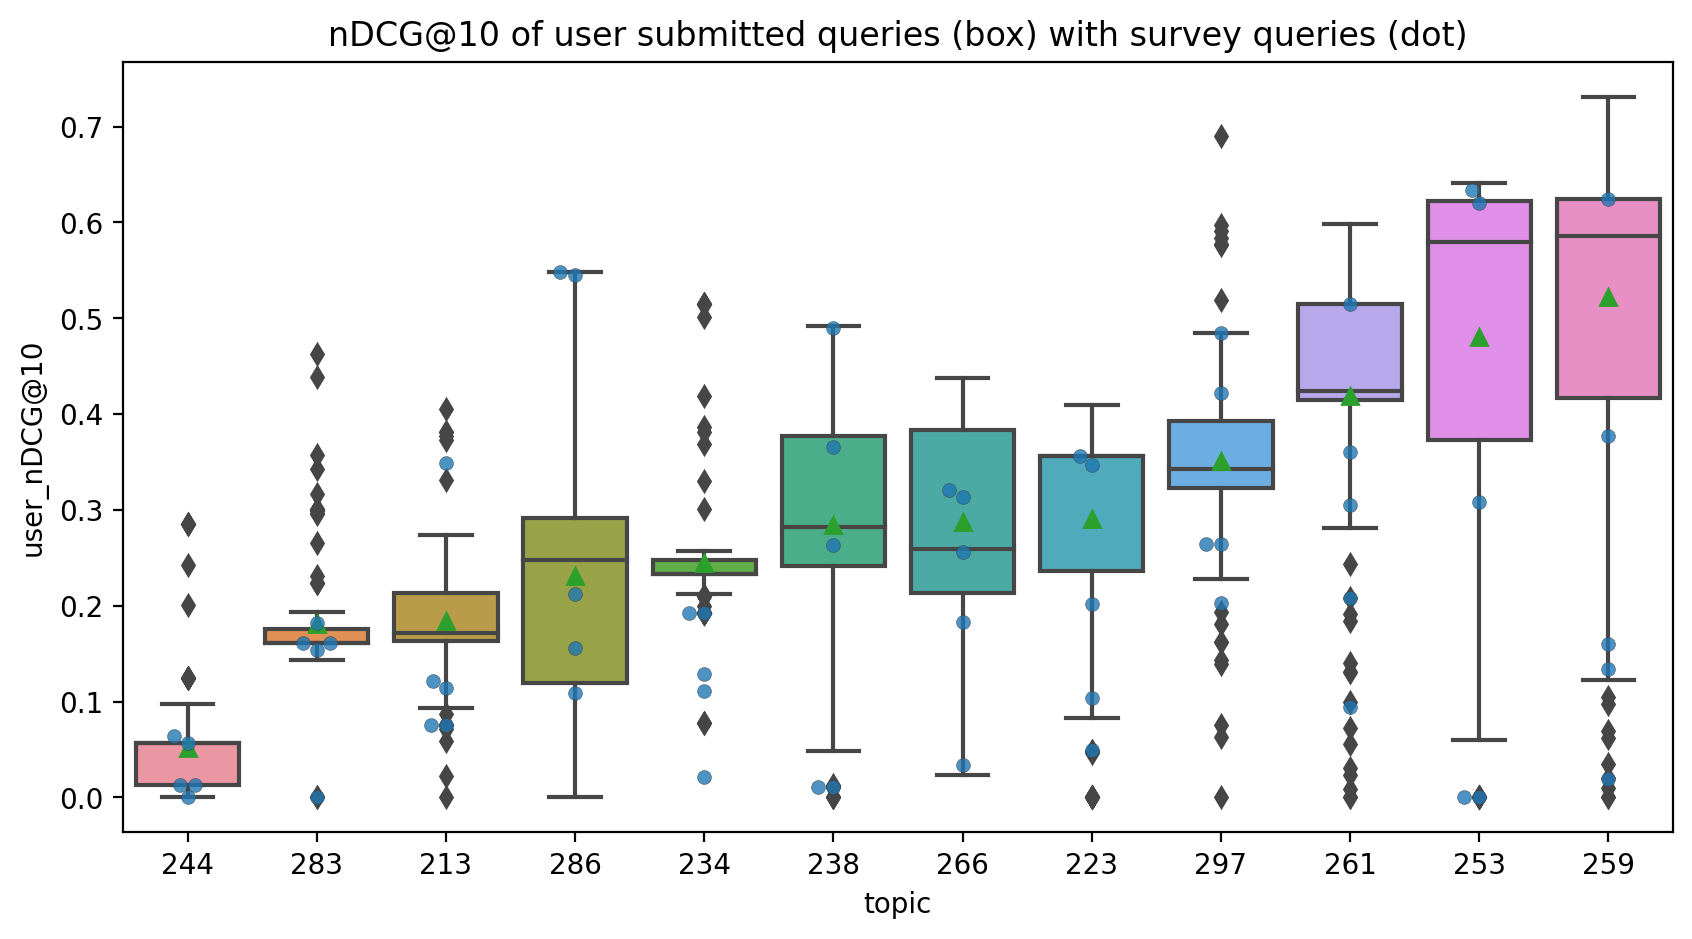

In [79]:
plt.figure(figsize=(10, 5), dpi=200)
sns.boxplot(data=user_qrs, x='topic', y='user_nDCG@10', order=order, showmeans=True)
sns.swarmplot(data=qdf_filtered, x='Topic', y='nDCG@10', order=order, alpha=0.8, linewidth=0.2)
plt.title('nDCG@10 of user submitted queries (box) with survey queries (dot)')

plt.show()

In [80]:
uqv_queries_df = pd.read_csv('data/uqv100-uniqueQueries.tsv', sep='\t')
# uqv_queries_df
_df = qdf_filtered.reset_index().merge(uqv_queries_df, left_on='query', right_on='query')
_df.loc[_df['qid_x'] != _df['qid_y'], ['qid_x', 'qid_y', 'query']]
# _df['qid_x'] == _df['qid_y']
# qdf_filtered

Empty DataFrame
Columns: [qid_x, qid_y, query]
Index: []

In [81]:
qdf_filtered.sort_values('nDCG@10')
# print(qdf_filtered.sort_index()[['query', 'nDCG@10']].to_markdown())

query   nDCG@10 Topic  \
qid                                                                         
253-1872                           treatment for jaw pain  0.000000   253   
283-8091                             ride in pennsylvania  0.000000   283   
244-6987                      old town scottsdale phoenix  0.000000   244   
253-1388                             tooth pain treatment  0.000000   253   
238-3199                                      george bush  0.011212   238   
238-7061                                  george h w bush  0.011212   238   
244-1723                              old town scottsdale  0.013212   244   
244-1606                      info on old town scottsdale  0.013212   244   
259-9374                                     pest control  0.019725   259   
234-1188                                     healthy food  0.020834   234   
266-7317                      heart and stroke foundation  0.033581   266   
223-9430                        healthy food pyramid diet  0.049922   223   
244-9854                      old town scottsdale history  0.056861   244   
244-5048           history of old town scottsdale arizona  0.064296   244   
213-2264                           carpal tunnel syndrome  0.075295   213   
213-5606                   what is carpal tunnel syndrome  0.075295   213   
261-6263                           home care cough remedy  0.094559   261   
223-9467                        usda nutrition guidelines  0.103866   223   
286-6720                                    schizophrenia  0.109451   286   
234-1823                  health impact of dark chocolate  0.110706   234   
213-7111                                    carpal tunnel  0.114385   213   
213-5173                      carpal tunnel syndrome wiki  0.121913   213   
234-4926                            dark chocolate health  0.129187   234   
259-8646                          hotline for bee control  0.134128   259   
283-2364    where in pennsylvania you can go on a hayride  0.153727   283   
286-3347            common drug therapy for schizophrenia  0.155850   286   
259-9412                                      bee removal  0.159759   259   
283-7317                             hayride pennsylvania  0.160705   283   
283-2264                          hayride in pennsylvania  0.160705   283   
283-1292                         pennsylvania usa hayride  0.181633   283   
266-8538                        heart attack symptom list  0.183137   266   
234-7913  how healthy is dark chocolate to the human body  0.192094   234   
234-3339                           healthy dark chocolate  0.192166   234   
223-6720                                     food pyramid  0.201439   223   
297-7913                how to overcome altitude sickness  0.202916   297   
261-5906                                      sore throat  0.207764   261   
286-6826                         schizophrenia medication  0.212521   286   
266-5597                         heart attack first steps  0.255818   266   
238-1870                         george hw bush biography  0.263513   238   
297-9981                     altitude sickness prevention  0.264538   297   
297-5173         mexico city altitude sickness prevention  0.264538   297   
261-4857  what are some homemade remedy for a sore throat  0.305223   261   
253-6283                                abscess treatment  0.307865   253   
266-5955                                     heart attack  0.313540   266   
266-9035             what to do to prevent a heart attack  0.321085   266   
223-8425                           food pyramid from usda  0.346546   223   
213-2326                                     cts syndrome  0.349312   213   
223-9981                                usda food pyramid  0.356010   223   
261-3964             what can i use to cure a sore throat  0.360681   261   
238-8725      what is a good biography on george h w bush  0.365688   238   
259-3561                            carpenter be

In [82]:
pd.read_csv('data/uqv100-systemInputRun-uniqueOnly-spelledNormQueries.tsv', sep='\t', header=None,
            names=['raw', 'query'])

raw  \
0     CW12|201-4|UQV100.001|slider-8939|1|4.390909091|1   
1     CW12|201-4|UQV100.001|slider-9971|6|4.390909091|1   
2     CW12|201-4|UQV100.001|textBox-2961|3|4.3909090...   
3     CW12|201-4|UQV100.001|textBox-5241|5|4.3909090...   
4     CW12|201-4|UQV100.001|textBox-1518|10|4.390909...   
...                                                 ...   
5760  CW12|300-0|UQV100.100|textBox-3229|1|4.7798165...   
5761  CW12|300-0|UQV100.100|textBox-7337|1|4.7798165...   
5762  CW12|300-0|UQV100.100|textBox-7350|12|4.779816...   
5763  CW12|300-0|UQV100.100|textBox-5526|1|4.7798165...   
5764  CW12|300-0|UQV100.100|textBox-6720|1|4.7798165...   

                                                  query  
0                                   amazon raspberry pi  
1                       best deal raspberry pi computer  
2                                      buy raspberry pi  
3                           buying a raspberry pi price  
4                                    cheap raspberry pi  
...                                                 ...  
5760                          what is the mean in maths  
5761                  what is the mean of these numbers  
5762                      what's the number of clusters  
5763                           work out mean of numbers  
5764  work out the mean of a set of numbers for a sa...  

[5765 rows x 2 columns]

In [83]:
from sklearn.metrics.pairwise import cosine_similarity

qdf_e = pd.read_pickle('data/embeddings/QueriesSurvey_df.pkl')
unique_user_queries_e = pd.read_pickle('data/embeddings/unique_normalized_user_queries_df.pkl')
sim_df = pd.DataFrame(index=qdf_e['query'], columns=unique_user_queries_e['query'],
                      data=cosine_similarity(np.load('data/embeddings/QueriesSurvey.npy'),
                                             np.load('data/embeddings/unique_normalized_user_queries.npy')))
# sim_df.loc['carpal tunnel', 'carpal tunnel']
sim_df.loc['sore throat home remedy', 'sore throat home remedy']
sim_df
#TODO: Match for each user the similarity of the ranked query to his own
# comb_df
# qdf_filtered
# user_qrs
usr_eqdf_emb = unique_user_queries_e.assign(topic=unique_user_queries_e.set_index('qid').index.str.split('-').str[0])
# all_user_queries
# all_user_queries[f'embeddings'] = all_user_queries['ref_qid'].apply(lambda x: unique_user_queries_e.set_index('qid').loc[x, 'embeddings'])
# all_user_queries.set_index(['topic', 'rid'])


In [84]:
from sklearn.manifold import TSNE
import plotly.express as px

canary_qids = qdf_e.set_index('qid').index.str.endswith('-0')
qdf_e = qdf_e.assign(topic=qdf_e.set_index('qid').index.str.split('-').str[0])
qdf_emb = qdf_e.loc[~canary_qids]

_df = pd.concat([qdf_emb, usr_eqdf_emb])

tsne = TSNE(n_components=2, random_state=1609, n_jobs=4, init='pca')
projections = tsne.fit_transform(np.stack(_df['embeddings']))
sur_projections = projections[:60]
usr_projections = projections[60:]

_df = _df.assign(x=projections[:, 0], y=projections[:, 1]).assign(size=['uqv'] * 60 + ['usr'] * len(_df[60:]))
_df
#Topic 234 has some queries within 223

/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/s3806763/miniconda3/envs/pds/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


qid  \
0                   261-2222   
1                   261-5906   
2                   261-6263   
3                   261-3964   
4                   261-4857   
..                       ...   
991  297-rating-843887168262   
992  297-ranking-47599303745   
993  297-ranking-10179138621   
994  297-rating-397327328054   
995  297-rating-594546549557   

                                                 query  \
0                              sore throat home remedy   
1                                          sore throat   
2                               home care cough remedy   
3                 what can i use to cure a sore throat   
4      what are some homemade remedy for a sore throat   
..                                                 ...   
991  what can you do to prevent altitude sickness i...   
992  what can you do to prevent high altitude sickn...   
993                          what is altitude sickness   
994  what to do to prevent altitude sickness on lon...   
995  will the altitude cause any problems when trav...   

                                            embeddings topic          x  \
0    [-0.0001788432418834418, -0.025770489126443863...   261 -51.917492   
1    [0.01846262998878956, -0.029567748308181763, 0...   261 -47.606277   
2    [-0.022930165752768517, -0.003079261165112257,...   261 -50.698544   
3    [0.011782892048358917, -0.007101575843989849, ...   261 -48.387230   
4    [-0.0014671504031866789, -0.011115031316876411...   261 -54.079624   
..                                                 ...   ...        ...   
991  [-0.05022071301937103, 0.04266071319580078, -0...   297 -27.516880   
992  [-0.013244218192994595, -0.05161745473742485, ...   297 -29.460234   
993  [-0.040079500526189804, -0.04469650611281395, ...   297 -24.861845   
994  [-0.029284292832016945, -0.014246388338506222,...   297 -27.199390   
995  [-0.07083772867918015, 0.07092809677124023, -0...   297 -19.885984   

             y size  
0    -2.882591  uqv  
1    -0.770611  uqv  
2     3.709471  uqv  
3    -3.013399  uqv  
4    -3.664494  uqv  
..         ...  ...  
991  11.019586  usr  
992  14.428142  usr  
993  16.857090  usr  
994  12.416137  usr  
995  14.306432  usr  

[1056 rows x 7 columns]

In [85]:
fig = px.scatter(_df, x='x', y='y', color='topic', labels={'color': 'topic'}, hover_name="query",
                 size=_df['size'].map({'uqv': 20, 'usr': 5}))
# fig.update_layout(hovermode="x")
fig.show()
plt.show()

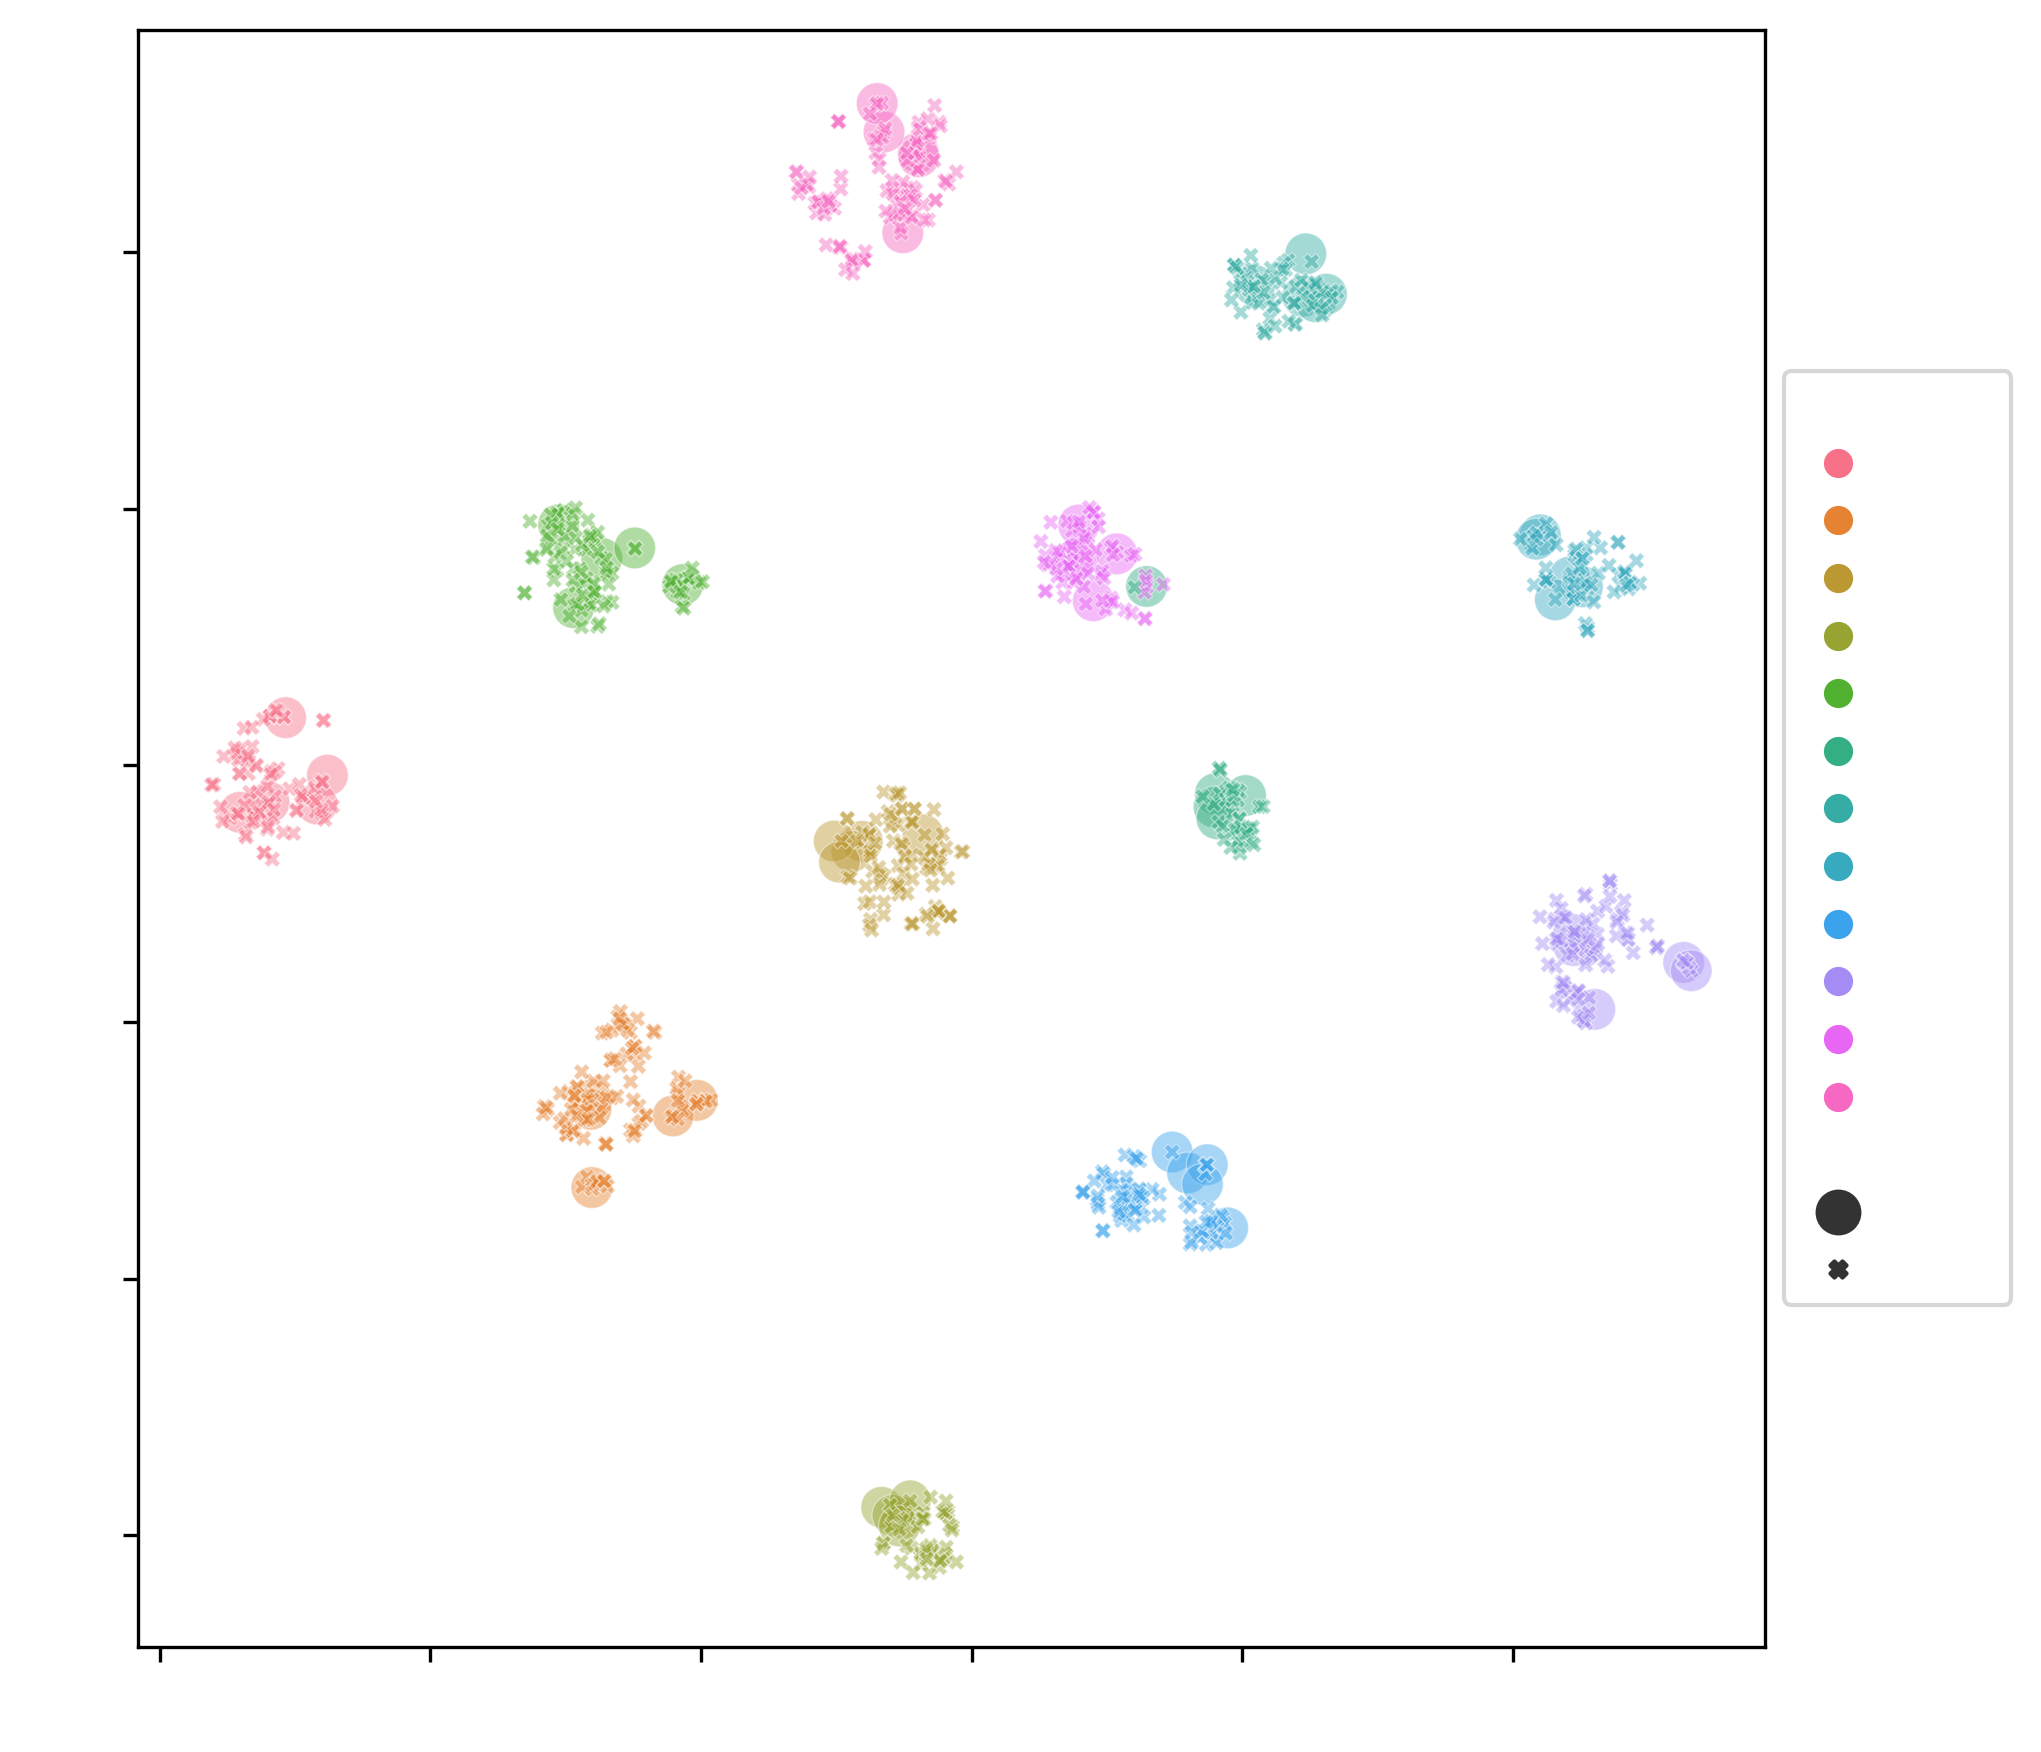

In [86]:
plt.rcParams.update(thesis_fmt)

# palette = fandb.get_interpolated_palette(fandb.SpectralPalette.SPEC, 12)
# palette = fandb.get_interpolated_palette(fandb.SpectralPalette.DEEPSPEC, 12)
palette = sns.color_palette("husl", 12)

plt.figure(figsize=(7, 7), dpi=300)
size_col_name = 'Type'
ax = sns.scatterplot(data=_df.rename(columns={'topic': 'Topic', 'size': size_col_name}), x='x', y='y', hue='Topic',
                     size=size_col_name, style=size_col_name, sizes=(15, 100), palette=palette, alpha=0.45,
                     legend='auto')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# Make the first n items in the plot larger than the rest
# for index, row in _df.head(60).iterrows():
#     plt.scatter(row["x"], row["y"], s=100)
# plt.title('Similarity of query embeddings per topic with tSNE dimensionality reduction')
# remove axis titles
plt.xlabel(None)
plt.ylabel(None)
plt.savefig('plots/queries_embeddings_tsne_husl.pdf', bbox_inches='tight')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# Add similarity to users' query
comb_df['sim_to_usr_qry'] = comb_df.apply(lambda x: sim_df.loc[x['query'], x['user_query']], axis=1)
print(comb_df[['query', 'user_query', 'sim_to_usr_qry', 'value']].nlargest(1000, columns='sim_to_usr_qry').tail(
    10).sort_values('sim_to_usr_qry').to_markdown())

In [ ]:
# add query length
comb_df['query_terms_len'] = comb_df['query'].str.split().str.len()
comb_df['query_chars_len'] = comb_df['query'].str.len()
comb_df['query_max_term_len'] = comb_df['query'].apply(lambda x: np.max([len(t) for t in x.split()]))
comb_df['query_avg_term_len'] = comb_df['query'].apply(lambda x: np.mean([len(t) for t in x.split()]))

qdf_filtered['query_terms_len'] = qdf_filtered['query'].str.split().str.len()
qdf_filtered['query_chars_len'] = qdf_filtered['query'].str.len()
qdf_filtered['query_max_term_len'] = qdf_filtered['query'].apply(lambda x: np.max([len(t) for t in x.split()]))
qdf_filtered['query_avg_term_len'] = qdf_filtered['query'].apply(lambda x: np.mean([len(t) for t in x.split()]))
qdf_filtered
# comb_df[['query', 'query_terms_len', 'query_chars_len', 'query_max_term_len', 'query_avg_term_len']]

In [ ]:
sns.pairplot(
    comb_df[['method', 'query_mean', 'query_terms_len', 'query_chars_len', 'query_max_term_len', 'query_avg_term_len']],
    hue='method', kind='reg', diag_kind='hist')
plt.show()

In [ ]:
sns.pairplot(
    comb_df[['method', 'value', 'query_terms_len', 'query_chars_len', 'query_max_term_len', 'query_avg_term_len']],
    hue='method', kind='reg', diag_kind='hist')
plt.show()

In [ ]:
def plot_query_len_value(qry_lengths_df, file_name='query_length.pdf'):
    _df = qry_lengths_df.rename(columns={'query_mean': 'value'})
    g = sns.catplot(data=_df, y='query_len', x='value', hue='method', row='query_len_type', kind='box', sharey=False,
                    showmeans=True, height=2, aspect=2, legend=True, margin_titles=False, zorder=10,
                    boxprops=dict(zorder=4), hue_order=['Ranking', 'Rating'], legend_out=True,
                    palette={'Ranking': '#008297', 'Rating': '#A14648'},
                    meanprops={"marker": "X", "markersize": 5, "markerfacecolor": (.4, .6, .8, .5),
                               "markeredgecolor": "black",
                               "color": (.9, .9, .9, .9), "linewidth": 2})

    for ax in g.axes.flat:
        ax.minorticks_on()
        ax.tick_params(axis='y', which='minor', left=True)
        ax.tick_params(axis='y', which='major', left=True)
        ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
        ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=0)
        ax.set_xlabel("Ranking/Rating value")

    g.axes[0, 0].set_ylabel('\# query terms')
    g.axes[1, 0].set_ylabel('\# query characters')

    g.map(plt.grid, visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
    g.map(plt.grid, visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.9,
          linewidth=0.5,
          ms=0)

    for ax in g.axes.flat:
        ax.set_title(None)
        for l in ax.lines + ax.collections:
            l.set_zorder(6)

    # g.set_titles("{row_name}")
    # plt.subplots_adjust(hspace=1)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, title=None)

    plt.tight_layout(h_pad=1.5)
    plt.savefig('plots/' + file_name, bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

qry_lengths_df = comb_df[['method', 'value', 'query_terms_len', 'query_chars_len']].melt(id_vars=['method', 'value'],
                                                                                         value_vars=['query_terms_len',
                                                                                                     'query_chars_len'],
                                                                                         var_name='query_len_type',
                                                                                         value_name='query_len')
plot_query_len_value(qry_lengths_df)

In [ ]:
print(qdf_filtered[['Rating', 'Ranking', 'nDCG@10', 'query_terms_len', 'query_chars_len']].corr(method='pearson').loc[
    ['Ranking', 'Rating', 'nDCG@10'], ['query_terms_len', 'query_chars_len']].to_markdown(
    floatfmt='.2g'))  #.to_latex(float_format="%.2f", bold_rows=True))

In [ ]:
_df = qdf_filtered.melt(id_vars=['query_chars_len', 'Topic'], value_vars=['Ranking', 'Rating'],
                        value_name="Users' mean").sort_values('Topic')  #.rename(columns={f'nDCG@{k}': f'NDCG@{k}'})
_rate_df = _df.loc[_df['variable'] == 'Rating']
_rank_df = _df.loc[_df['variable'] == 'Ranking']

x = 'query_chars_len'
y = "Users' mean"

markers = list(Line2D.filled_markers)
for m in {'8', 'h', 'H', '.'}:
    markers.remove(m)

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

g = sns.lmplot(data=_df, y=y, x=x, hue='Topic', col='variable', height=2.2, aspect=2.5, ci=None, fit_reg=False,
               markers=markers, col_wrap=1, scatter_kws=dict(s=15), palette="icefire", facet_kws=dict(sharey=False),
               row_order=['Ranking', 'Rating'])

sns.regplot(x=x, y=y, data=_rank_df, scatter=False, ax=g.axes[0], ci=95, line_kws=dict(color='#224F62', lw=1))
_rank_reg_res = stats.linregress(_rank_df[x], _rank_df[y])
rank_label = f'$ \hat{{y}}={_rank_reg_res.intercept:.3f} + {_rank_reg_res.slope:.3f}x $'
# rank_label = f'r = {_rank_reg_res.rvalue:.2g}\np = {_rank_reg_res.pvalue:.1g}'
# rank_line, = g.axes[0].plot(_rank_df[x], _rank_reg_res.intercept + _rank_reg_res.slope * _rank_df[x],
#                             color='#224F62', label=rank_label)

sns.regplot(x=x, y=y, data=_rate_df, scatter=False, ax=g.axes[1], ci=95, line_kws=dict(color='#224F62', lw=1))
_rate_reg_res = stats.linregress(_rate_df[x], _rate_df[y])
rate_label = f'$ \hat{{y}}={_rate_reg_res.intercept:.3f} + {_rate_reg_res.slope:.3f}x $'
# rate_label = f'r = {_rate_reg_res.rvalue:.2g}\np = {_rate_reg_res.pvalue:.1g}'
# rate_line, = g.axes[1].plot(_rate_df[x], _rate_reg_res.intercept + _rate_reg_res.slope * _rate_df[x],
#                             color='y', label=rate_label)

# ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
for ax in g.axes.flat:
    ax.minorticks_on()
    ax.grid(visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
    ax.grid(visible=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5,
            linewidth=0.5, ms=0)

# g.map(plt.grid, visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
# g.map(plt.grid, visible=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5,
#       linewidth=0.5, ms=0)

# g.axes[0].legend(handles=[rate_line], loc='upper left')
# g.axes[1].legend(handles=[rank_line], loc='upper left')

g.axes[0].text(.6, 0.1, rank_label, transform=g.axes[0].transAxes, rotation=0, size='small')
g.axes[1].text(.6, 0.1, rate_label, transform=g.axes[1].transAxes, rotation=0, size='small')

for ax in g.axes.flat:
    ax.set_ylabel(y)
    ax.set_xlabel('\# query characters')
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.3)

g.legend.set_frame_on(True)
frame = g.legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)

plt.savefig('plots/regplot_qlen_per_task.pdf', dpi=300, bbox_inches='tight')

print('Ranking reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rank_reg_res, _rank_reg_res._fields)])
print('Rating reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rate_reg_res, _rate_reg_res._fields)])

plt.show()

## Choice-supportive bias
Conclusion and questions:
* There is a significant correlation between the similarity of the submitted query to the valuation of each query
* The topic seems to affect it, perhaps hard/easy topics?
* Does the perception of the topic affects it?
* The interface might have a small effect on it

A possible way to test for such bias would be to check if similar queries tend to get higher values
both when they are valued high by users and low.

**Overall, it seems that users tend to value the query more if they are more similar to their submitted query,
and less if they are less similar. This might be due to choice supportive bias, but it seems more likely that
the users have some mental model of good and bad queries.**

In [ ]:
print('Number of samples per method:\n', comb_df.groupby('method')[['value']].count())
print('Mean similarity per method:\n')
print(comb_df.groupby('method')['sim_to_usr_qry'].mean().round(2))

In [ ]:
# Correlation between similarity and value
corr = 'pearson'
comb_df.groupby('method')[['value', 'sim_to_usr_qry']].corr(method=corr).loc[:, slice('value'), :][
    'sim_to_usr_qry'].droplevel(1).to_frame().apply(np.round, args=[2])

In [ ]:
# Correlation per topic and per method
sim_corr_df = \
    comb_df.groupby(['topic', 'method'])[['value', 'sim_to_usr_qry']].corr(method=corr).loc[:, :, slice('value')][
        'sim_to_usr_qry'].droplevel(2).to_frame().reset_index()
sns.boxplot(data=sim_corr_df, x='method', y='sim_to_usr_qry', showmeans=True)
sns.swarmplot(data=sim_corr_df, x='method', y='sim_to_usr_qry', color=".25")
plt.title('Correlation between similarity and value per topic and method')

plt.show()

In [ ]:
# macro-average correlation per topic
print(sim_corr_df.groupby('method')['sim_to_usr_qry'].mean().round(2))
# "micro-average" correlation per across topics
print(comb_df.groupby('method')[['value', 'sim_to_usr_qry']].corr(method=corr).loc[:, slice('value'), :][
          'sim_to_usr_qry'].droplevel(1).to_frame().round(2))

In [ ]:
sns.catplot(data=comb_df, x='value', y='sim_to_usr_qry', kind='point', errorbar=('ci', 95))

sns.catplot(data=comb_df, x='value', y='sim_to_usr_qry', kind='point', hue='method',
            palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=True, margin_titles=False, join=True,
            hue_order=['Ranking', 'Rating'])

plt.show()

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

plt.figure(figsize=(10, 4), dpi=300)
sns.boxplot(
    data=comb_df.rename(columns={'sim_to_usr_qry': 'Similarity to user\'s query', 'value': 'Ranking/Rating value'}),
    orient='h',
    y='Ranking/Rating value', x='Similarity to user\'s query', palette=sns.color_palette("husl", 5), meanline=False,
    showmeans=True,
    meanprops={"marker": "X", "markersize": 10, "markerfacecolor": (.4, .6, .8, .5), "markeredgecolor": "black",
               "color": (.9, .9, .9, .9), "linewidth": 3})
plt.savefig('plots/similarity_to_user_query_boxplot.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(8, 4), dpi=300)
ax = sns.boxplot(
    data=comb_df.rename(columns={'sim_to_usr_qry': 'Similarity to user\'s query', 'value': 'Ranking/Rating value'}),
    x='Ranking/Rating value', y='Similarity to user\'s query', hue='method', zorder=10, boxprops={'zorder': 5},
    palette={'Ranking': '#008297', 'Rating': '#A14648'}, hue_order=['Ranking', 'Rating'], showmeans=True,
    meanprops={"marker": "X", "markersize": 10, "markerfacecolor": (.4, .6, .8, .5), "markeredgecolor": "black",
               "color": (.9, .9, .9, .9), "linewidth": 3})

sns.despine(left=False, bottom=False)

ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=True)
ax.tick_params(axis='y', which='major', left=True)
ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=0)

ax.grid(visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
ax.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5,
        ms=0)

sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, title=None)

# g.legend.set_title(None)
plt.savefig('plots/similarity_to_user_query_boxplot_separated.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
sns.catplot(data=comb_df, x='value', y='sim_to_usr_qry', kind='point', col='topic', hue='method', col_wrap=4,
            palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=True, margin_titles=True, join=True,
            hue_order=['Ranking', 'Rating'])
sns.catplot(data=comb_df, x='value', y='sim_to_usr_qry', kind='box', col='topic', hue='method', col_wrap=4,
            palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=True, margin_titles=True, showmeans=True,
            flierprops={"marker": "x"}, meanline=False, hue_order=['Ranking', 'Rating'],
            meanprops={"marker": "X", "markerfacecolor": (.4, .6, .8, .5), "markeredgecolor": "black"})

plt.show()

In [ ]:
user_qrs.groupby(['topic', 'method'])['user_nDCG@10'].mean()

In [ ]:
# pd.cut(comb_df['sim_to_usr_qry'], bins=(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1),
#                                       precision=3, retbins=True, include_lowest=True)

# plt.rcParamsDefault
# _sr, bins = pd.qcut(comb_df['sim_to_usr_qry'].clip(upper=1), q=5, retbins=True)
_sr, bins = pd.cut(comb_df['sim_to_usr_qry'].clip(upper=1), bins=[0, 0.6, 0.75, 0.8, 0.9, 1], precision=3, retbins=True,
                   include_lowest=True)
_df = comb_df.assign(inter=_sr)

print(f'Bins are: {bins}')

g = sns.catplot(data=_df, x='inter', y='value', kind='point', col='topic', hue='method', col_wrap=4, height=3.5,
                aspect=1, scale=0.8, errwidth=1.3, capsize=0.3,
                palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=False, margin_titles=False, join=False,
                hue_order=['Ranking', 'Rating'])

# g = sns.catplot(data=_df, x='inter', y='value', kind='point', height=3.5, aspect=1, scale=0.8, errwidth=1.3,
#                 capsize=0.3, legend=True, margin_titles=False, join=False, col_wrap=4, col='topic')


for ax in g.axes.flat:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis='y', which='major', left=True)
    ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
    ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=0)

for ax in g.axes.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_xlabel("User's mean")


g.map(plt.grid, visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.9,
      linewidth=0.5,
      ms=0)

for ax in g.axes.flat:
    ax.legend(loc='upper left')
    #     ax.set_title(None)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

g.set_titles("Topic {col_name} User's Mean")
# plt.subplots_adjust(hspace=1)

plt.tight_layout(h_pad=1.5)
plt.savefig('plots/similarity_to_user_query_per_topic_method.pdf')

plt.show()

In [ ]:
sns.stripplot(data=_df, y='sim_to_usr_qry', x='value', hue='method',
              palette={'Ranking': '#008297', 'Rating': '#A14648'}, hue_order=['Ranking', 'Rating'])
plt.show()
# sns.stripplot(data=_df, y='sim_to_usr_qry', x='norm_value', hue='method',
#               palette={'Ranking': '#008297', 'Rating': '#A14648'}, hue_order=['Ranking', 'Rating'])
# plt.show()
_df['norm_value'] = np.ceil(_df['norm_value']).clip(1, 5)
sns.stripplot(data=_df, y='sim_to_usr_qry', x='norm_value', hue='method',
              palette={'Ranking': '#008297', 'Rating': '#A14648'}, hue_order=['Ranking', 'Rating'])
plt.title('Rounded normalized ratings')
plt.show()

In [ ]:
_df = comb_df.assign(rounded_norm=np.ceil(comb_df['normalized_value']).clip(1, 5))
g = sns.catplot(data=_df, x='rounded_norm', y='sim_to_usr_qry', kind='box', col='topic', hue='method', col_wrap=4,
                palette={'Ranking': '#008297', 'Rating': '#A14648'}, legend=True, margin_titles=True, showmeans=True,
                flierprops={"marker": "x"}, meanline=False, hue_order=['Ranking', 'Rating'],
                meanprops={"marker": "X", "markerfacecolor": (.4, .6, .8, .5), "markeredgecolor": "black"}, zorder=10)
for ax in g.axes.flat:
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis='y', which='major', left=True)
    ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
    ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=0)

for ax in g.axes.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_xlabel("User's mean")


g.map(plt.grid, visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.9,
      linewidth=0.5,
      ms=0)

for ax in g.axes.flat:
    ax.legend(loc='upper left')
    #     ax.set_title(None)
    for l in ax.lines + ax.collections:
        l.set_zorder(15)

g.set_titles("Topic {col_name} User's Mean")
# plt.subplots_adjust(hspace=1)

plt.tight_layout(h_pad=1.5)

plt.show()

In [ ]:
user_vars_counts_sr = all_user_queries.value_counts(['topic', 'user_query']).rename('count').sort_index()
user_vars_counts_sr.loc['261', 'sore throat home remedy']
# pd.MultiIndex.from_frame()

In [ ]:
# Add the uqv counts to the comb_df dataframe
# comb_df = comb_df.assign(uqv_vars_count=uqv_queries_df.set_index('qid').loc[comb_df['qid'], 'count'])
# Add user query counts to the comb_df dataframe
# comb_df = comb_df.assign(
#     user_vars_count=user_vars_counts_sr.reindex(pd.MultiIndex.from_frame(comb_df[['topic', 'query']])).fillna(
#         0).to_numpy())
# uqv_queries_df
qdf_filtered = qdf_filtered.assign(
    uqv_vars_count=np.log(1 + uqv_queries_df.set_index('qid').loc[qdf_filtered.index, 'count']))
qdf_filtered = qdf_filtered.assign(user_vars_count=np.log(1 + user_vars_counts_sr.reindex(
    pd.MultiIndex.from_frame(qdf_filtered[['Topic', 'query']].astype({'Topic': int}))).fillna(0).to_numpy()))
# qdf_filtered.to_pickle('qdf_filtered.pkl')
qdf_filtered

In [ ]:
print('Pearson Corr:\n')
print(qdf_filtered.corr(method='pearson', numeric_only=True).to_markdown(floatfmt='.2f'))
print('\nSpearman Corr:\n')
print(qdf_filtered.corr(method='spearman', numeric_only=True).to_markdown(floatfmt='.2f'))
print('\nKendall Corr:\n')
print(qdf_filtered.corr(method='kendall', numeric_only=True).to_markdown(floatfmt='.2f'))

In [ ]:
x = 'uqv_vars_count'
# y = 'uqv_vars_count'
_df = qdf_filtered.melt(id_vars=[x, 'Topic'], value_vars=['Ranking', 'Rating'],
                        value_name="Users' mean").sort_values('Topic')
_rate_df = _df.loc[_df['variable'] == 'Rating']
_rank_df = _df.loc[_df['variable'] == 'Ranking']

y = "Users' mean"
# y = f'uqv_vars_count'
markers = list(Line2D.filled_markers)
for m in {'8', 'h', 'H', '.'}:
    markers.remove(m)
g = sns.lmplot(data=_df, y=y, x=x, hue='Topic', col='variable', height=2.5, aspect=1.5, ci=None, fit_reg=False,
               markers=markers, scatter_kws=dict(s=15), palette="icefire", facet_kws=dict(sharey=False),
               col_order=['Ranking', 'Rating'])

# sns.regplot(x=x, y=y, data=_df.loc[_df['variable'] == 'Ranking'], scatter=False, ax=g.axes[0, 1], ci=None, line_kws=dict(color='#224F62', lw=2))
_rank_reg_res = stats.linregress(_rank_df[x], _rank_df[y])
rank_label = f'$ \hat{{y}}={_rank_reg_res.intercept:.3f} + {_rank_reg_res.slope:.3f}x $'
# rank_label = f'r = {_rank_reg_res.rvalue:.2g}\np = {_rank_reg_res.pvalue:.1g}'
rank_line, = g.axes[0, 0].plot(_rank_df[x], _rank_reg_res.intercept + _rank_reg_res.slope * _rank_df[x],
                               color='#224F62', label=rank_label)

# sns.regplot(x=x, y=y, data=_df.loc[_df['variable'] == 'Rating'], scatter=False, ax=g.axes[0, 0], ci=None, line_kws=dict(color='#224F62'))
_rate_reg_res = stats.linregress(_rate_df[x], _rate_df[y])
rate_label = f'$ \hat{{y}}={_rate_reg_res.intercept:.3f} + {_rate_reg_res.slope:.3f}x $'
# rate_label = f'r = {_rate_reg_res.rvalue:.2g}\np = {_rate_reg_res.pvalue:.1g}'
rate_line, = g.axes[0, 1].plot(_rate_df[x], _rate_reg_res.intercept + _rate_reg_res.slope * _rate_df[x],
                               color='#224F62', label=rate_label)

# ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
for ax in g.axes.flat:
    ax.minorticks_on()

g.map(plt.grid, visible=True, which='major', axis='both', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, visible=True, which='minor', axis='both', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5,
      linewidth=0.5, ms=0)

# g.axes[0,0].legend(handles=[rate_line], loc='upper left')
# g.axes[0,1].legend(handles=[rank_line], loc='upper left')

g.axes[0, 0].text(.038, 0.92, rank_label, transform=g.axes[0, 0].transAxes, rotation=0, size='small')
g.axes[0, 1].text(.038, 0.92, rate_label, transform=g.axes[0, 1].transAxes, rotation=0, size='small')

for ax in g.axes.flat:
    ax.set_ylabel(y)
    for l in ax.lines + ax.collections:
        l.set_zorder(5)

g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.3)

g.legend.set_frame_on(True)
frame = g.legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)

plt.savefig('plots/regplot_per_task.pdf')

print('Ranking reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rank_reg_res, _rank_reg_res._fields)])
print('Rating reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rate_reg_res, _rate_reg_res._fields)])

plt.show()

In [ ]:
ranks_df.groupby('topic').apply(
    lambda _df: _df.groupby('rid').apply(lambda _df_: _df_.sort_values(by='value', ascending=False)['query'].to_list()))

In [ ]:
# Based on code from:
# Original author
# __author__ = "Michael G. Parker"
# __contact__ = "http://omgitsmgp.com/"
# Fork creator
# __author__ = "Woctezuma"
# __contact__ = "https://github.com/woctezuma/"

def _compute_p(d, candidate_names):
    """Computes the p array in the Schulze method.

    p[V,W] is the strength of the strongest path from candidate V to W.
    """
    p = {}
    for candidate_name1 in candidate_names:
        for candidate_name2 in candidate_names:
            if candidate_name1 != candidate_name2:
                strength = d.get((candidate_name1, candidate_name2), 0)
                if strength > d.get((candidate_name2, candidate_name1), 0):
                    p[candidate_name1, candidate_name2] = strength

    for candidate_name1 in candidate_names:
        for candidate_name2 in candidate_names:
            if candidate_name1 != candidate_name2:
                for candidate_name3 in candidate_names:
                    if (candidate_name1 != candidate_name3) and (candidate_name2 != candidate_name3):
                        curr_value = p.get((candidate_name2, candidate_name3), 0)
                        new_value = min(
                            p.get((candidate_name2, candidate_name1), 0),
                            p.get((candidate_name1, candidate_name3), 0))
                        if new_value > curr_value:
                            p[candidate_name2, candidate_name3] = new_value

    return p


def _rank_p(candidate_names, p):
    """Ranks the candidates by p."""
    candidate_wins = defaultdict(list)

    for candidate_name1 in candidate_names:
        num_wins = 0

        # Compute the number of wins this candidate has over all other candidates.
        for candidate_name2 in candidate_names:
            if candidate_name1 == candidate_name2:
                continue
            candidate1_score = p.get((candidate_name1, candidate_name2), 0)
            candidate2_score = p.get((candidate_name2, candidate_name1), 0)
            if candidate1_score > candidate2_score:
                num_wins += 1

        candidate_wins[num_wins].append(candidate_name1)

    sorted_wins = sorted(candidate_wins.keys(), reverse=True)
    return [candidate_wins[num_wins] for num_wins in sorted_wins]

In [ ]:
def construct_distances_matrix(_sr):
    # (_sr.to_numpy() < _sr.to_numpy()[:, None]).astype(int)
    return pd.DataFrame((_sr.to_numpy() < _sr.to_numpy()[:, None]).astype(int), index=_sr.index, columns=_sr.index)


def calc_schulze(df):
    result = {}
    for topic, _df in df.groupby('topic'):
        sums = []
        for rid, _df_ in _df.groupby('rid'):
            _sr = _df_.sort_values('value', ascending=False).set_index('query')['value']
            sums.append(construct_distances_matrix(_sr))
        _d = sum(sums).stack()
        candidate_names = _d.index.get_level_values(0).unique().to_list()
        d = _d.to_dict()
        p = _compute_p(d, candidate_names)
        result[topic] = _rank_p(candidate_names, p)
    return result


schulze_ranks_result = calc_schulze(ranks_df)
schulze_rates_result = calc_schulze(rates_df)
schulze_comb_result = calc_schulze(comb_df)

In [ ]:
same = 0
ranking_ties = 0
rating_ties = 0
for topic in schulze_comb_result.keys():
    print(f'\nTopic {topic}')
    print(schulze_comb_result[topic])
    print(schulze_ranks_result[topic])
    print(schulze_rates_result[topic])
    # check if two lists that contain lists within have the same order
    _same = True
    for i, j in zip(schulze_ranks_result[topic], schulze_rates_result[topic]):
        if len(i) > 1:
            ranking_ties += 1
        if len(j) > 1:
            rating_ties += 1
        if i != j:
            _same = False
    else:
        same += bool(_same)
        print('Same' if _same else 'Different')
print('Total identical orderings of topics using Schulze ', same)
print('Total ranking ties ', ranking_ties)
print('Total rating ties ', rating_ties)

In [ ]:
# calc borda count
def calc_borda(df):
    result = {}
    for topic, _df in df.groupby('topic'):
        sums = []
        for rid, _df_ in _df.groupby('rid'):
            _sr = _df_.sort_values('value', ascending=False).set_index('query')['value'].rank(ascending=True) - 1
            sums.append(_sr)
        _d = sum(sums).sort_values(ascending=False).rank(ascending=False)
        result[topic] = [x.index.to_list() for _, x in _d.groupby(_d)]
    return result


borda_ranks_result = calc_borda(ranks_df)
borda_rates_result = calc_borda(rates_df)
borda_comb_result = calc_borda(comb_df)

In [ ]:
same = 0
rating_ties = 0
ranking_ties = 0
for topic in borda_comb_result.keys():
    print(f'\nTopic {topic}')
    print(borda_comb_result[topic])
    print(borda_ranks_result[topic])
    print(borda_rates_result[topic])
    _same = True
    # check if two lists that contain lists within have the same order
    for i, j in zip(borda_ranks_result[topic], borda_rates_result[topic]):
        if len(i) > 1:
            ranking_ties += 1
        if len(j) > 1:
            rating_ties += 1
        if i != j:
            _same = False
    else:
        same += bool(_same)
        print('Same' if _same else 'Different')
print('Total identical orderings of topics using Borda count ', same)
print('Total ranking ties ', ranking_ties)
print('Total rating ties ', rating_ties)

In [ ]:
def dict_of_lists_to_series(di):
    schulze_comb_ranks_dict = {}
    for topic, queries in di.items():
        for r, qrs in enumerate(queries, 1):
            if isinstance(qrs, list):
                for q in qrs:
                    schulze_comb_ranks_dict[(topic, q)] = r
            else:
                schulze_comb_ranks_dict[(topic, qrs)] = r
    pd.Series(schulze_comb_ranks_dict)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

paper_fmt = {
    # "font.family": "Lato",
    "font.serif": ["Linux Libertine O"],
    'font.size': 16,
    "font.sans-serif": ["Linux Libertine O", "Linux Biolinum O", "New TX"],
    'figure.figsize': (6, 2),
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'medium',
    'legend.title_fontsize': 'small',
    "axes.labelpad": 5.0,
    'axes.titlesize': 'medium',
    'axes.labelsize': 'medium',
    'axes.edgecolor': '0.8',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'large',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
}

poster_fmt = {
    "font.family": "Lato",
    # "font.serif": ["Linux Libertine O"],
    'font.size': 20,
    # "font.sans-serif": ["Linux Libertine O", "Linux Biolinum O", "New TX"],
    'figure.figsize': (6, 2),
    'figure.facecolor': '#dfe7ea',
    # 'figure.facecolor': '#BFCED5',
    'savefig.dpi': 300,
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'medium',
    'legend.title_fontsize': 'small',
    "axes.labelpad": 5.0,
    'axes.titlesize': 'medium',
    'axes.labelsize': 'medium',
    'axes.edgecolor': '0.8',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'large',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
}

slides_fmt = {
    "font.family": "Fira Sans",
    # "font.family": ["Century Schoolbook Std", "Linux Libertine O", "serif", 'sans-serif'],
    # "font.serif": "Fira",
    # "font.serif": ["New Century Schoolbook", "Century Schoolbook L", "Century Schoolbook Std"],
    'font.size': 9,
    # 'font.size': 10,
    # "font.sans-serif": "Linux Biolinum",
    'figure.facecolor': (0.98, 0.98, 0.98),
    'text.color': '#23373b',
    'axes.labelcolor': '#23373b',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 4.5),
    'legend.borderaxespad': 0.5,
    # "axes.labelpad": 20.0
    "axes.labelpad": 10.0
}

thesis_fmt = {
    "ps.useafm": True,
    # "ps.usedistiller": "xpdf",
    "font.family": "serif",
    "font.serif": ['garamond', 'urw-garamond', 'Garamond 3 URW'],
    # "text.latex.preamble": r"\usepackage{mathdesign}",
    "text.latex.preamble": r"\usepackage{microtype}"
                           r"\usepackage{lmodern}"
                           r"\usepackage[scaled]{beramono}"
                           r"\usepackage[urw-garamond, uppercase=upright]{mathdesign}"
                           r"\usepackage{garamondx}"
                           r"\renewcommand{\ttdefault}{lmtt}"
                           r"\usepackage{pifont}"
                           r"\usepackage{setspace}"
                           r"\linespread{1.05}"
                           r"\DeclareMathAlphabet{\xcal}{OMS}{cmsy}{m}{n}",
    # "mathtext.default": 'it',
    # "mathtext.fontset": 'custom',
    # "mathtext.rm": 'Garamond 3 URW Italic',
    # "mathtext.it": 'Garamond 3 URW Italic',
    'text.usetex': True,
    # "font.sans-serif": "Linux Biolinum",
    'font.size': 16,
    # 'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (10, 5),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}

plt.rcParams.update(thesis_fmt)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  #

In [ ]:
_rel_df = comb_df.groupby(['method']).apply(
    lambda _df: _df.pivot(columns='query', index='rid', values='value'))
rel_df = _rel_df.groupby(['method']).apply(
    lambda _df: krippendorff.alpha(reliability_data=_df, level_of_measurement='ordinal'))
print("Krippendorff's alpha:\n")
rel_df.round(2)

In [ ]:
_rel_df = comb_df.groupby(['method']).apply(
    lambda _df: _df.pivot(columns='query', index='rid', values='normalized_value'))
rel_df = _rel_df.groupby(['method']).apply(
    lambda _df: krippendorff.alpha(reliability_data=_df, level_of_measurement='ordinal'))
print("Krippendorff's alpha rating as ranks:\n")
rel_df.round(2)

In [ ]:
_reliability_df = comb_df.groupby(['method', 'topic']).apply(
    lambda _df: _df.pivot(columns='query', index='rid', values='value'))
reliability_df = _reliability_df.groupby(['method', 'topic']).apply(
    lambda _df: krippendorff.alpha(reliability_data=_df.dropna(axis=1), level_of_measurement='ordinal'))
topics_order = reliability_df.loc['Ranking'].sub(reliability_df.loc['Rating']).sort_values(ascending=False).index
krip_table = reliability_df.reset_index().pivot(index='topic', columns='method').droplevel(0, axis=1).loc[topics_order]
print(krip_table.to_markdown(floatfmt='.3f'))
plt.figure(figsize=(10, 6), dpi=100)
_df = reliability_df.reset_index().rename(columns={0: "$\\alpha$", 'topic': 'Topic'})
_means = _df.groupby('method')["$\\alpha$"].mean()
ax = sns.barplot(data=_df, x='Topic', y="$\\alpha$", hue='method', order=topics_order,
                 palette={'Ranking': '#008297', 'Rating': '#A14648'}, zorder=5)
# ax = sns.pointplot(data=_df, x='Topic', y="$\\alpha$", hue='method', order=topics_order, scale=2.2,
#                    palette={'Ranking': '#008297', 'Rating': '#A14648'})
sns.despine()

for l in ax.lines:
    l.set_zorder(5)
for l in ax.collections:
    l.set_zorder(10)

ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False, labelleft=False)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=45)

ax.grid(visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
ax.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5, ms=0)
plt.legend(title=None)
# ax.spines['left'].set_color('0.8')
# ax.spines['bottom'].set_color('0.8')
plt.tight_layout(h_pad=1.5)

# plt.savefig('plots/krippendorfs_pointplot.pdf')
plt.savefig('plots/krippendorfs_barplot.pdf')
plt.show()

krip_table = krip_table.sort_values(['Ranking', 'Rating'])
print(_means.to_markdown(floatfmt='.2g'))
print(krip_table.sort_values(['Rating', 'Ranking']).T.to_latex(float_format="%.2f", bold_rows=True))

In [ ]:
krip_table.loc['Macro Average'] = krip_table.mean()
print(krip_table.T.to_latex(float_format="%.2f", bold_rows=True))
# krip_table.sort_values(['Ranking', 'Rating'])

In [ ]:
krip_table.loc[topics_order]

In [ ]:
_reliability_df = comb_df.groupby(['method', 'topic']).apply(
    lambda _df: _df.pivot(columns='query', index='rid', values='normalized_value'))
reliability_df = _reliability_df.groupby(['method', 'topic']).apply(
    lambda _df: krippendorff.alpha(reliability_data=_df.dropna(axis=1), level_of_measurement='ordinal'))
topics_order = reliability_df.loc['Ranking'].sub(reliability_df.loc['Rating']).sort_values(ascending=False).index
krip_table = reliability_df.reset_index().pivot(index='topic', columns='method').droplevel(0, axis=1).loc[
    topics_order]
print(krip_table.to_markdown(floatfmt='.3f'))
plt.figure(figsize=(10, 6), dpi=100)
_df = reliability_df.reset_index().rename(columns={0: "$\\alpha$", 'topic': 'Topic'})
_means = _df.groupby('method')["$\\alpha$"].mean()
ax = sns.barplot(data=_df, x='Topic', y="$\\alpha$", hue='method', order=topics_order,
                 palette={'Ranking': '#008297', 'Rating': '#A14648'}, zorder=5)
# ax = sns.pointplot(data=_df, x='Topic', y="$\\alpha$", hue='method', order=topics_order, scale=2.2,
#                    palette={'Ranking': '#008297', 'Rating': '#A14648'})
sns.despine()

for l in ax.lines:
    l.set_zorder(5)
for l in ax.collections:
    l.set_zorder(10)

ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False, labelleft=False)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True, labelrotation=45)

ax.grid(visible=True, which='major', axis='y', color='#E5E5E5', linestyle='-.', zorder=1, linewidth=1, ms=0)
ax.grid(visible=True, which='minor', axis='y', color='#E5E5E5', linestyle=':', zorder=0, alpha=0.5, linewidth=0.5, ms=0)
plt.legend(title=None)
# ax.spines['left'].set_color('0.8')
# ax.spines['bottom'].set_color('0.8')
plt.tight_layout(h_pad=1.5)

# plt.savefig('plots/krippendorfs_normalized_pointplot.pdf')
plt.savefig('plots/krippendorfs_normalized_barplot.pdf')
plt.show()

krip_table = krip_table.sort_values(['Ranking', 'Rating'])
print(_means.to_markdown(floatfmt='.2g'))
print(krip_table.round(2).sort_values(['Rating', 'Ranking']).T.to_latex(float_format="%.2f", bold_rows=True))

In [ ]:
krip_table.loc['Macro Average'] = krip_table.mean()
print(krip_table.T.to_latex(float_format="%.2f", bold_rows=True))

In [ ]:
print(
    f"Average alpha per method, Ranking: {reliability_df.loc['Ranking'].mean():.2f} Rating: {reliability_df.loc['Rating'].mean():.2f} Overall: {reliability_df.mean():.2f}")
print(
    f"Using related two-sided t-test the p-value is {stats.ttest_rel(reliability_df['Ranking'], reliability_df['Rating'], alternative='two-sided').pvalue:.3f}")

plt.figure(figsize=(6, 4), dpi=150)
sns.pointplot(data=reliability_df.reset_index().pivot(index='topic', columns='method').droplevel(0, axis=1),
              errorbar='sd',
              palette={'Ranking': '#008297', 'Rating': '#A14648'})
plt.title('Average Krippendorf\'s $\\alpha$ with SD')
plt.show()

In [ ]:
# TODO: calculate confidence intervals for K-a using bootstrap to resample the data.

def bsk(data):
    print('new')
    print(data.head().dropna(axis=1))
    print('end')
    # return stats.bootstrap(data, lambda x: krippendorff.alpha(reliability_data=x, level_of_measurement='ordinal'),
    #                        n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95,
    #                        method='BCa', random_state=1234)
    return krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal')


# _reliability_df.groupby(['method', 'topic']).apply(lambda _df: bsk(_df))
_reliability_df

In [ ]:
import lzma
import csv
import pandas as pd
from glob import glob

In [ ]:
docs_file = 'trec_res_docs.tsv'
run_files = glob('../PL2.DFR.SD-trec.run')
wanted_docids = set()
try:
    existing_docids = set(pd.read_csv(docs_file, sep='\t', header=None)[0])
except pd.errors.EmptyDataError:
    existing_docids = set()

print(len(existing_docids))
for run in run_files:
    wanted_docids.update(set(pd.read_csv(run, header=None, delim_whitespace=True)[2]))
print(len(wanted_docids))
missing_docids = wanted_docids.difference(existing_docids)
print(len(missing_docids))

In [ ]:
cw12_docs = '/research/remote/petabyte/users/pepper/for_oleg/CW12B-BP.txt.xz'


def fun_write(docs_dict):
    with open(docs_file, 'a') as f:
        fieldnames = docs_dict.keys()
        writer = csv.writer(f, dialect='excel-tab')
        writer.writerows(docs_dict.items())

    # docs_dict = {}


wanted_docids = {'clueweb12-0919wb-15-03094'}
_doctext = []
_text_flag = False
with lzma.open(cw12_docs, 'r') as f:
    for line in f:
        line = line.strip()
if len(missing_docids) == 0:
    break
#         print(line)
if line == b'<DOC>' or line == b'':
    continue
if line.startswith(b'<DOCNO>'):
    _docid = line.decode().strip('<DOCNO>').strip('</DOCNO>')
    #             print(_docid)
    continue
elif line == b'<TEXT>':
    _text_flag = True
    continue

elif line == b'</TEXT>':

In [ ]:
            _text_flag = False
continue

if _text_flag:
    _doctext.append(line.decode())
elif line == b'</DOC>':
    if _docid in missing_docids:
        #                 docs_dict[_docid] = ' '.join(_doctext)
        fun_write({_docid: ' '.join(_doctext)})
        #                 print(missing_docids)
        missing_docids.remove(_docid)
    else:
        _doctext = []